In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
from torch.autograd import Variable
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedavg'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl import Predicter
from logdeep.tools.train_sl import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out
    
class loganomaly_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
#         self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, (outpreh, outprec) = self.lstm1(input1, (h0_1, c0_1))
#         multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
#         out = self.fc(multi_out)
        return out1, outpreh, outprec


class loganomaly_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, hPrevious, cPrevious, device):
        input0, input1 = features[0], features[1]

#         h0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)
#         c0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (hPrevious, cPrevious))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = loganomaly_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = loganomaly_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 84/1058 [00:00<00:01, 839.99it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:22 | Learning rate: 0.000313


Train loss: 3.29887:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:23 | Learning rate: 0.000625


Train loss: 3.18718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:24 | Learning rate: 0.001250


Train loss: 2.47023:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:24 | Learning rate: 0.002500


Train loss: 1.87414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:24 | Learning rate: 0.005000


Train loss: 1.78831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:24 | Learning rate: 0.010000


Train loss: 1.59707:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:25 | Learning rate: 0.010000


Train loss: 1.36444:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:25 
Validation loss: 1.3903379440307617
Starting epoch: 7 | phase: train | ⏰: 01:12:25 | Learning rate: 0.010000


Train loss: 1.18217:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:25 | Learning rate: 0.010000


Train loss: 0.95904:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:26 
Validation loss: 0.9933946132659912
Starting epoch: 9 | phase: train | ⏰: 01:12:26 | Learning rate: 0.010000


Train loss: 0.95359: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▉                                                                         | 78/1046 [00:00<00:01, 764.71it/s]

sampling...


Train loss: 3.36168:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:38 | Learning rate: 0.000313


Train loss: 3.29890:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:39 | Learning rate: 0.000625


Train loss: 3.18769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.85it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:39 | Learning rate: 0.001250


Train loss: 2.58528:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:39 | Learning rate: 0.002500


Train loss: 1.87675:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:39 | Learning rate: 0.005000


Train loss: 1.73701:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:40 | Learning rate: 0.010000


Train loss: 1.49800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:40 | Learning rate: 0.010000


Train loss: 1.32767:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:40 
Validation loss: 1.3217716217041016
Starting epoch: 7 | phase: train | ⏰: 01:12:40 | Learning rate: 0.010000


Train loss: 1.09841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:40 | Learning rate: 0.010000


Train loss: 0.96144:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:41 
Validation loss: 0.964758574962616
Starting epoch: 9 | phase: train | ⏰: 01:12:41 | Learning rate: 0.010000


Train loss: 0.94681: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 949.99it/s]

sampling...


Train loss: 3.36303:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:53 | Learning rate: 0.000313


Train loss: 3.29984:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:53 | Learning rate: 0.000625


Train loss: 3.18886:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:54 | Learning rate: 0.001250


Train loss: 2.59471:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:54 | Learning rate: 0.002500


Train loss: 1.89288:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:54 | Learning rate: 0.005000


Train loss: 1.80070:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:54 | Learning rate: 0.010000


Train loss: 1.56964:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:55 | Learning rate: 0.010000


Train loss: 1.39482:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:55 
Validation loss: 1.4106920957565308
Starting epoch: 7 | phase: train | ⏰: 01:12:55 | Learning rate: 0.010000


Train loss: 1.16834:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:55 | Learning rate: 0.010000


Train loss: 1.03545:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:55 
Validation loss: 1.057008147239685
Starting epoch: 9 | phase: train | ⏰: 01:12:55 | Learning rate: 0.010000


Train loss: 0.99384: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 95/1057 [00:00<00:01, 950.00it/s]

sampling...


Train loss: 3.36189:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:08 | Learning rate: 0.000313


Train loss: 3.29910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 01:13:08 | Learning rate: 0.000625


Train loss: 3.18524:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:08 | Learning rate: 0.001250


Train loss: 2.59120:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 01:13:09 | Learning rate: 0.002500


Train loss: 1.85691:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:09 | Learning rate: 0.005000


Train loss: 1.76896:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 01:13:09 | Learning rate: 0.010000


Train loss: 1.51846:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:09 | Learning rate: 0.010000


Train loss: 1.30622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:13:10 
Validation loss: 1.3246122598648071
Starting epoch: 7 | phase: train | ⏰: 01:13:10 | Learning rate: 0.010000


Train loss: 1.06977:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:10 | Learning rate: 0.010000


Train loss: 0.96658:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:13:10 
Validation loss: 0.9106156229972839
Starting epoch: 9 | phase: train | ⏰: 01:13:10 | Learning rate: 0.010000


Train loss: 0.96328: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


Train loss: 3.36326:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:13:23 | Learning rate: 0.000313


Train loss: 3.30838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 01:13:23 | Learning rate: 0.000625


Train loss: 3.18521:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 01:13:23 | Learning rate: 0.001250


Train loss: 2.58681:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 01:13:23 | Learning rate: 0.002500


Train loss: 1.87165:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 01:13:24 | Learning rate: 0.005000


Train loss: 1.76438:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.08it/s]

Starting epoch: 5 | phase: train | ⏰: 01:13:24 | Learning rate: 0.010000


Train loss: 1.52575:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 01:13:24 | Learning rate: 0.010000


Train loss: 1.32164:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:13:24 
Validation loss: 1.354267954826355
Starting epoch: 7 | phase: train | ⏰: 01:13:24 | Learning rate: 0.010000


Train loss: 1.13464:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 8 | phase: train | ⏰: 01:13:25 | Learning rate: 0.010000


Train loss: 0.96891:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:13:25 
Validation loss: 0.9652094841003418
Starting epoch: 9 | phase: train | ⏰: 01:13:25 | Learning rate: 0.010000


Train loss: 0.94573: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.49it/s]


============ Test epoch 0 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:38, 26.55it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:45<00:00, 24.84it/s]


false positive (FP): 486, false negative (FN): 24, Precision: 87.307%, Recall: 99.287%, F1-measure: 92.913%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.553
Finished Predicting
elapsed_time: 647.0257301330566
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:18, 28.04it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:04<00:00, 17.61it/s]


false positive (FP): 525, false negative (FN): 25, Precision: 86.424%, Recall: 99.257%, F1-measure: 92.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.518
Finished Predicting
elapsed_time: 544.3689796924591
Client  2


  0%|                                                                                 | 2/5730 [00:00<04:46, 20.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:01<00:00, 18.17it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 631.9165785312653
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:49,  8.85it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:05<00:00, 17.74it/s]


false positive (FP): 448, false negative (FN): 28, Precision: 88.170%, Recall: 99.168%, F1-measure: 93.346%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 602.8508565425873
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:24<00:00, 46.41it/s]


false positive (FP): 523, false negative (FN): 32, Precision: 86.444%, Recall: 99.050%, F1-measure: 92.318%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.513
Finished Predicting
elapsed_time: 422.4473555088043
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▏                                                                 | 166/1058 [00:00<00:01, 834.01it/s]

sampling...


Train loss: 0.90806:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:10 | Learning rate: 0.000313


Train loss: 0.87642:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 02:01:10 | Learning rate: 0.000625


Train loss: 0.85104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 02:01:10 | Learning rate: 0.001250


Train loss: 0.81921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 02:01:11 | Learning rate: 0.002500


Train loss: 0.79437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 02:01:11 | Learning rate: 0.005000


Train loss: 0.84404:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 02:01:11 | Learning rate: 0.010000


Train loss: 0.79914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 02:01:11 | Learning rate: 0.010000


Train loss: 0.74125:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:01:12 
Validation loss: 0.7476369738578796
Starting epoch: 7 | phase: train | ⏰: 02:01:12 | Learning rate: 0.010000


Train loss: 0.69564:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 02:01:12 | Learning rate: 0.010000


Train loss: 0.76098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:01:12 
Validation loss: 0.7103293538093567
Starting epoch: 9 | phase: train | ⏰: 02:01:12 | Learning rate: 0.010000


Train loss: 0.76143: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|████████████▉                                                                 | 174/1046 [00:00<00:01, 851.47it/s]

sampling...


Train loss: 0.90362:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:24 | Learning rate: 0.000313


Train loss: 0.89009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 02:01:25 | Learning rate: 0.000625


Train loss: 0.87221:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 02:01:25 | Learning rate: 0.001250


Train loss: 0.85050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 02:01:25 | Learning rate: 0.002500


Train loss: 0.82533:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 02:01:25 | Learning rate: 0.005000


Train loss: 0.78552:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 02:01:26 | Learning rate: 0.010000


Train loss: 0.76323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 02:01:26 | Learning rate: 0.010000


Train loss: 0.75705:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:01:26 
Validation loss: 0.7536998987197876
Starting epoch: 7 | phase: train | ⏰: 02:01:26 | Learning rate: 0.010000


Train loss: 0.74860:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 02:01:26 | Learning rate: 0.010000


Train loss: 0.69634:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:01:27 
Validation loss: 0.6840421557426453
Starting epoch: 9 | phase: train | ⏰: 02:01:27 | Learning rate: 0.010000


Train loss: 0.67516: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 0.92808:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:39 | Learning rate: 0.000313


Train loss: 0.89723:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 02:01:39 | Learning rate: 0.000625


Train loss: 0.87377:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:01:39 | Learning rate: 0.001250


Train loss: 0.85523:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 02:01:39 | Learning rate: 0.002500


Train loss: 0.82136:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 02:01:40 | Learning rate: 0.005000


Train loss: 0.82888:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 02:01:40 | Learning rate: 0.010000


Train loss: 0.76160:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 02:01:40 | Learning rate: 0.010000


Train loss: 0.83435:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:01:40 
Validation loss: 0.7533777952194214
Starting epoch: 7 | phase: train | ⏰: 02:01:40 | Learning rate: 0.010000


Train loss: 0.72601:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 02:01:41 | Learning rate: 0.010000


Train loss: 0.68766:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:01:41 
Validation loss: 0.7177773714065552
Starting epoch: 9 | phase: train | ⏰: 02:01:41 | Learning rate: 0.010000


Train loss: 0.69413: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 83/1057 [00:00<00:01, 813.73it/s]

sampling...


Train loss: 0.87948:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:01:53 | Learning rate: 0.000313


Train loss: 0.87534:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 02:01:53 | Learning rate: 0.000625


Train loss: 0.83967:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:01:53 | Learning rate: 0.001250


Train loss: 0.82425:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 02:01:54 | Learning rate: 0.002500


Train loss: 0.81229:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 02:01:54 | Learning rate: 0.005000


Train loss: 0.79042:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 02:01:54 | Learning rate: 0.010000


Train loss: 0.73981:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 6 | phase: train | ⏰: 02:01:54 | Learning rate: 0.010000


Train loss: 0.70710:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:01:54 
Validation loss: 0.665023148059845
Starting epoch: 7 | phase: train | ⏰: 02:01:55 | Learning rate: 0.010000


Train loss: 0.67584:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 02:01:55 | Learning rate: 0.010000


Train loss: 0.65650:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:01:55 
Validation loss: 0.6327769160270691
Starting epoch: 9 | phase: train | ⏰: 02:01:55 | Learning rate: 0.010000


Train loss: 0.64929: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▋                                                                     | 105/1044 [00:00<00:00, 1050.00it/s]

sampling...


Train loss: 0.91598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:02:07 | Learning rate: 0.000313


Train loss: 0.90265:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 02:02:07 | Learning rate: 0.000625


Train loss: 0.87261:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:02:07 | Learning rate: 0.001250


Train loss: 0.85966:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 02:02:07 | Learning rate: 0.002500


Train loss: 0.82902:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 02:02:08 | Learning rate: 0.005000


Train loss: 0.84850:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 02:02:08 | Learning rate: 0.010000


Train loss: 0.79050:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 02:02:08 | Learning rate: 0.010000


Train loss: 0.73320:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:02:08 
Validation loss: 0.6812500953674316
Starting epoch: 7 | phase: train | ⏰: 02:02:08 | Learning rate: 0.010000


Train loss: 0.69086:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 02:02:09 | Learning rate: 0.010000


Train loss: 0.66685:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:02:09 
Validation loss: 0.6184176802635193
Starting epoch: 9 | phase: train | ⏰: 02:02:09 | Learning rate: 0.010000


Train loss: 0.65640: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


============ Test epoch 1 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:33, 27.21it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:05<00:00, 17.39it/s]


false positive (FP): 364, false negative (FN): 72, Precision: 90.052%, Recall: 97.862%, F1-measure: 93.794%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 662.2354457378387
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:09<00:00, 16.32it/s]


false positive (FP): 403, false negative (FN): 73, Precision: 89.099%, Recall: 97.832%, F1-measure: 93.262%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 618.3338251113892
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:25, 21.58it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:07<00:00, 16.62it/s]


false positive (FP): 342, false negative (FN): 83, Precision: 90.568%, Recall: 97.535%, F1-measure: 93.922%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 599.9979298114777
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:44,  6.49it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:08<00:00, 16.86it/s]


false positive (FP): 337, false negative (FN): 83, Precision: 90.693%, Recall: 97.535%, F1-measure: 93.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 666.6267201900482
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:40, 16.53it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:52<00:00, 21.40it/s]


false positive (FP): 406, false negative (FN): 82, Precision: 89.000%, Recall: 97.565%, F1-measure: 93.086%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.572
Finished Predicting
elapsed_time: 563.444785118103
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.63086:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:54:16 | Learning rate: 0.000313


Train loss: 0.62890:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 02:54:16 | Learning rate: 0.000625


Train loss: 0.62275:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 02:54:16 | Learning rate: 0.001250


Train loss: 0.61194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 02:54:16 | Learning rate: 0.002500


Train loss: 0.58278:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 02:54:17 | Learning rate: 0.005000


Train loss: 0.67469:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 02:54:17 | Learning rate: 0.010000


Train loss: 0.61820:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 02:54:17 | Learning rate: 0.010000


Train loss: 0.57848:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:54:17 
Validation loss: 0.5808022022247314
Starting epoch: 7 | phase: train | ⏰: 02:54:17 | Learning rate: 0.010000


Train loss: 0.50462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 02:54:18 | Learning rate: 0.010000


Train loss: 0.46117:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:54:18 
Validation loss: 0.48263609409332275
Starting epoch: 9 | phase: train | ⏰: 02:54:18 | Learning rate: 0.010000


Train loss: 0.45448: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 15%|███████████▊                                                                  | 158/1046 [00:00<00:01, 786.05it/s]

sampling...


Train loss: 0.64580:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:54:30 | Learning rate: 0.000313


Train loss: 0.63946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 02:54:30 | Learning rate: 0.000625


Train loss: 0.62940:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 2 | phase: train | ⏰: 02:54:30 | Learning rate: 0.001250


Train loss: 0.61270:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 02:54:30 | Learning rate: 0.002500


Train loss: 0.60213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 02:54:31 | Learning rate: 0.005000


Train loss: 0.59048:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 02:54:31 | Learning rate: 0.010000


Train loss: 0.54707:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 02:54:31 | Learning rate: 0.010000


Train loss: 0.47572:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:54:31 
Validation loss: 0.5104015469551086
Starting epoch: 7 | phase: train | ⏰: 02:54:31 | Learning rate: 0.010000


Train loss: 0.43866:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 02:54:32 | Learning rate: 0.010000


Train loss: 0.40240:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:54:32 
Validation loss: 0.4204939603805542
Starting epoch: 9 | phase: train | ⏰: 02:54:32 | Learning rate: 0.010000


Train loss: 0.38540: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 0.66493:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:54:44 | Learning rate: 0.000313


Train loss: 0.64649:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 1 | phase: train | ⏰: 02:54:44 | Learning rate: 0.000625


Train loss: 0.64287:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 02:54:44 | Learning rate: 0.001250


Train loss: 0.62959:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 02:54:45 | Learning rate: 0.002500


Train loss: 0.62142:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 4 | phase: train | ⏰: 02:54:45 | Learning rate: 0.005000


Train loss: 0.61492:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 02:54:45 | Learning rate: 0.010000


Train loss: 0.55340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 02:54:45 | Learning rate: 0.010000


Train loss: 0.51707:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:54:46 
Validation loss: 0.5166157484054565
Starting epoch: 7 | phase: train | ⏰: 02:54:46 | Learning rate: 0.010000


Train loss: 0.53480:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 02:54:46 | Learning rate: 0.010000


Train loss: 0.58218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:54:46 
Validation loss: 0.546198308467865
Starting epoch: 9 | phase: train | ⏰: 02:54:46 | Learning rate: 0.010000


Train loss: 0.55756: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▍                                                                 | 168/1057 [00:00<00:01, 843.58it/s]

sampling...


Train loss: 0.64426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:54:58 | Learning rate: 0.000313


Train loss: 0.62766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 02:54:59 | Learning rate: 0.000625


Train loss: 0.62349:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 02:54:59 | Learning rate: 0.001250


Train loss: 0.61161:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 02:54:59 | Learning rate: 0.002500


Train loss: 0.60213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 02:54:59 | Learning rate: 0.005000


Train loss: 0.57886:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 02:55:00 | Learning rate: 0.010000


Train loss: 0.53285:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 02:55:00 | Learning rate: 0.010000


Train loss: 0.49038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:55:00 
Validation loss: 0.5012155771255493
Starting epoch: 7 | phase: train | ⏰: 02:55:00 | Learning rate: 0.010000


Train loss: 0.49034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 02:55:00 | Learning rate: 0.010000


Train loss: 0.42374:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:55:01 
Validation loss: 0.43337270617485046
Starting epoch: 9 | phase: train | ⏰: 02:55:01 | Learning rate: 0.010000


Train loss: 0.42665: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▉                                                                | 186/1044 [00:00<00:00, 922.54it/s]

sampling...


Train loss: 0.64452:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:55:12 | Learning rate: 0.000313


Train loss: 0.65045:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 02:55:13 | Learning rate: 0.000625


Train loss: 0.64339:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:55:13 | Learning rate: 0.001250


Train loss: 0.63548:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 02:55:13 | Learning rate: 0.002500


Train loss: 0.62177:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 4 | phase: train | ⏰: 02:55:13 | Learning rate: 0.005000


Train loss: 0.60763:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 02:55:14 | Learning rate: 0.010000


Train loss: 0.59674:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 02:55:14 | Learning rate: 0.010000


Train loss: 0.55935:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:55:14 
Validation loss: 0.5686495304107666
Starting epoch: 7 | phase: train | ⏰: 02:55:14 | Learning rate: 0.010000


Train loss: 0.52192:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 02:55:14 | Learning rate: 0.010000


Train loss: 0.51366:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:55:15 
Validation loss: 0.5175644159317017
Starting epoch: 9 | phase: train | ⏰: 02:55:15 | Learning rate: 0.010000


Train loss: 0.50132: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 2 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:10, 30.53it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:05<00:00, 17.32it/s]


false positive (FP): 502, false negative (FN): 54, Precision: 86.841%, Recall: 98.396%, F1-measure: 92.258%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 655.3557548522949
Client  1


  0%|                                                                                 | 2/5574 [00:00<07:28, 12.42it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:03<00:00, 17.90it/s]


false positive (FP): 526, false negative (FN): 43, Precision: 86.338%, Recall: 98.723%, F1-measure: 92.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.501
Finished Predicting
elapsed_time: 563.1107325553894
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:50, 24.79it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:08<00:00, 16.43it/s]


false positive (FP): 474, false negative (FN): 56, Precision: 87.477%, Recall: 98.337%, F1-measure: 92.589%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.535
Finished Predicting
elapsed_time: 647.3919944763184
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:18,  7.19it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:10<00:00, 16.35it/s]


false positive (FP): 453, false negative (FN): 51, Precision: 87.981%, Recall: 98.485%, F1-measure: 92.937%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.558
Finished Predicting
elapsed_time: 601.2677476406097
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:07<00:00, 16.71it/s]


false positive (FP): 513, false negative (FN): 59, Precision: 86.574%, Recall: 98.248%, F1-measure: 92.042%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 588.1387774944305
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 96/1058 [00:00<00:01, 959.99it/s]

sampling...


Train loss: 0.38347:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:46:25 | Learning rate: 0.000313


Train loss: 0.38361:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 03:46:25 | Learning rate: 0.000625


Train loss: 0.39404:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 2 | phase: train | ⏰: 03:46:26 | Learning rate: 0.001250


Train loss: 0.37338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 03:46:26 | Learning rate: 0.002500


Train loss: 0.36003:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 03:46:26 | Learning rate: 0.005000


Train loss: 0.35655:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 03:46:26 | Learning rate: 0.010000


Train loss: 0.41290:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 03:46:27 | Learning rate: 0.010000


Train loss: 0.46909:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:46:27 
Validation loss: 0.3714459538459778
Starting epoch: 7 | phase: train | ⏰: 03:46:27 | Learning rate: 0.010000


Train loss: 0.41037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 03:46:27 | Learning rate: 0.010000


Train loss: 0.36399:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:46:27 
Validation loss: 0.3770817220211029
Starting epoch: 9 | phase: train | ⏰: 03:46:27 | Learning rate: 0.010000


Train loss: 0.37765: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 870.00it/s]

sampling...


Train loss: 0.40291:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:46:39 | Learning rate: 0.000313


Train loss: 0.39185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 1 | phase: train | ⏰: 03:46:39 | Learning rate: 0.000625


Train loss: 0.38359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 03:46:39 | Learning rate: 0.001250


Train loss: 0.37643:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 03:46:40 | Learning rate: 0.002500


Train loss: 0.36682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 03:46:40 | Learning rate: 0.005000


Train loss: 0.36005:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 03:46:40 | Learning rate: 0.010000


Train loss: 0.34610:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 03:46:40 | Learning rate: 0.010000


Train loss: 0.52439:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:46:41 
Validation loss: 0.5041179060935974
Starting epoch: 7 | phase: train | ⏰: 03:46:41 | Learning rate: 0.010000


Train loss: 0.47754:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 03:46:41 | Learning rate: 0.010000


Train loss: 0.41585:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:46:41 
Validation loss: 0.44826507568359375
Starting epoch: 9 | phase: train | ⏰: 03:46:41 | Learning rate: 0.010000


Train loss: 0.40455: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▍                                                                 | 168/1051 [00:00<00:01, 847.37it/s]

sampling...


Train loss: 0.42432:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:46:53 | Learning rate: 0.000313


Train loss: 0.41092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 03:46:53 | Learning rate: 0.000625


Train loss: 0.40616:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 03:46:53 | Learning rate: 0.001250


Train loss: 0.39679:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 03:46:53 | Learning rate: 0.002500


Train loss: 0.38671:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 03:46:54 | Learning rate: 0.005000


Train loss: 0.37819:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 03:46:54 | Learning rate: 0.010000


Train loss: 0.36451:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 03:46:54 | Learning rate: 0.010000


Train loss: 0.41510:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:46:54 
Validation loss: 0.4584226608276367
Starting epoch: 7 | phase: train | ⏰: 03:46:54 | Learning rate: 0.010000


Train loss: 0.36909:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 03:46:55 | Learning rate: 0.010000


Train loss: 0.35172:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:46:55 
Validation loss: 0.3312031030654907
Starting epoch: 9 | phase: train | ⏰: 03:46:55 | Learning rate: 0.010000


Train loss: 0.34272: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 850.00it/s]

sampling...


Train loss: 0.40167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:47:07 | Learning rate: 0.000313


Train loss: 0.39999:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 1 | phase: train | ⏰: 03:47:07 | Learning rate: 0.000625


Train loss: 0.38464:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 03:47:07 | Learning rate: 0.001250


Train loss: 0.38347:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 03:47:07 | Learning rate: 0.002500


Train loss: 0.37126:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 03:47:08 | Learning rate: 0.005000


Train loss: 0.34184:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 03:47:08 | Learning rate: 0.010000


Train loss: 0.35299:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 03:47:08 | Learning rate: 0.010000


Train loss: 0.46994:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:47:08 
Validation loss: 0.36453312635421753
Starting epoch: 7 | phase: train | ⏰: 03:47:08 | Learning rate: 0.010000


Train loss: 0.49957:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 03:47:08 | Learning rate: 0.010000


Train loss: 0.46320:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:47:09 
Validation loss: 0.5076431035995483
Starting epoch: 9 | phase: train | ⏰: 03:47:09 | Learning rate: 0.010000


Train loss: 0.45637: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 0.43062:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:47:20 | Learning rate: 0.000313


Train loss: 0.41681:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 03:47:21 | Learning rate: 0.000625


Train loss: 0.40852:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:47:21 | Learning rate: 0.001250


Train loss: 0.39736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 03:47:21 | Learning rate: 0.002500


Train loss: 0.39389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 03:47:21 | Learning rate: 0.005000


Train loss: 0.38023:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 03:47:22 | Learning rate: 0.010000


Train loss: 0.43351:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 03:47:22 | Learning rate: 0.010000


Train loss: 0.50718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:47:22 
Validation loss: 0.5016007423400879
Starting epoch: 7 | phase: train | ⏰: 03:47:22 | Learning rate: 0.010000


Train loss: 0.43951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 03:47:22 | Learning rate: 0.010000


Train loss: 0.41055:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:47:22 
Validation loss: 0.3677632808685303
Starting epoch: 9 | phase: train | ⏰: 03:47:23 | Learning rate: 0.010000


Train loss: 0.41536: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


============ Test epoch 3 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:36, 26.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:13<00:00, 15.52it/s]


false positive (FP): 240, false negative (FN): 176, Precision: 93.005%, Recall: 94.773%, F1-measure: 93.881%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.635
Finished Predicting
elapsed_time: 643.894730091095
Client  1


  0%|                                                                                 | 2/5574 [00:00<07:09, 12.99it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:15<00:00, 15.06it/s]


false positive (FP): 254, false negative (FN): 183, Precision: 92.612%, Recall: 94.565%, F1-measure: 93.578%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 617.9803612232208
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:23, 21.74it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:15<00:00, 14.79it/s]


false positive (FP): 221, false negative (FN): 207, Precision: 93.463%, Recall: 93.852%, F1-measure: 93.657%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 639.7138381004333
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:18,  7.19it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:19<00:00, 14.57it/s]


false positive (FP): 209, false negative (FN): 188, Precision: 93.831%, Recall: 94.416%, F1-measure: 94.123%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 646.2589707374573
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:50, 13.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:15<00:00, 14.83it/s]


false positive (FP): 247, false negative (FN): 208, Precision: 92.748%, Recall: 93.822%, F1-measure: 93.282%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 622.5905923843384
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 872.56it/s]

sampling...


Train loss: 0.35395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:40:28 | Learning rate: 0.000313


Train loss: 0.32862:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 04:40:28 | Learning rate: 0.000625


Train loss: 0.32266:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:40:28 | Learning rate: 0.001250


Train loss: 0.31737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 04:40:29 | Learning rate: 0.002500


Train loss: 0.31479:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 04:40:29 | Learning rate: 0.005000


Train loss: 0.30891:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 04:40:29 | Learning rate: 0.010000


Train loss: 0.30704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 04:40:29 | Learning rate: 0.010000


Train loss: 0.29512:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:40:30 
Validation loss: 0.34295639395713806
Starting epoch: 7 | phase: train | ⏰: 04:40:30 | Learning rate: 0.010000


Train loss: 0.29648:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 04:40:30 | Learning rate: 0.010000


Train loss: 0.28157:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:40:30 
Validation loss: 0.35041582584381104
Starting epoch: 9 | phase: train | ⏰: 04:40:30 | Learning rate: 0.010000


Train loss: 0.28937: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 99/1046 [00:00<00:00, 980.20it/s]

sampling...


Train loss: 0.35097:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:40:42 | Learning rate: 0.000313


Train loss: 0.33816:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 04:40:42 | Learning rate: 0.000625


Train loss: 0.32852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 04:40:42 | Learning rate: 0.001250


Train loss: 0.32244:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 04:40:43 | Learning rate: 0.002500


Train loss: 0.31229:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 04:40:43 | Learning rate: 0.005000


Train loss: 0.31256:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 04:40:43 | Learning rate: 0.010000


Train loss: 0.31447:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 04:40:43 | Learning rate: 0.010000


Train loss: 0.30152:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:40:43 
Validation loss: 0.3263658583164215
Starting epoch: 7 | phase: train | ⏰: 04:40:44 | Learning rate: 0.010000


Train loss: 0.29606:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 04:40:44 | Learning rate: 0.010000


Train loss: 0.29841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:40:44 
Validation loss: 0.3073285222053528
Starting epoch: 9 | phase: train | ⏰: 04:40:44 | Learning rate: 0.010000


Train loss: 0.29658: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 81/1051 [00:00<00:01, 801.98it/s]

sampling...


Train loss: 0.36515:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:40:56 | Learning rate: 0.000313


Train loss: 0.35152:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 04:40:56 | Learning rate: 0.000625


Train loss: 0.34455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 04:40:56 | Learning rate: 0.001250


Train loss: 0.33523:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 04:40:56 | Learning rate: 0.002500


Train loss: 0.33736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 4 | phase: train | ⏰: 04:40:56 | Learning rate: 0.005000


Train loss: 0.32586:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 04:40:57 | Learning rate: 0.010000


Train loss: 0.32692:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 04:40:57 | Learning rate: 0.010000


Train loss: 0.31488:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:40:57 
Validation loss: 0.3096592128276825
Starting epoch: 7 | phase: train | ⏰: 04:40:57 | Learning rate: 0.010000


Train loss: 0.30980:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 04:40:57 | Learning rate: 0.010000


Train loss: 0.30125:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:40:58 
Validation loss: 0.3096145987510681
Starting epoch: 9 | phase: train | ⏰: 04:40:58 | Learning rate: 0.010000


Train loss: 0.30585: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.37it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|████████████                                                                  | 163/1057 [00:00<00:01, 818.29it/s]

sampling...


Train loss: 0.36609:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:41:09 | Learning rate: 0.000313


Train loss: 0.33614:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 04:41:10 | Learning rate: 0.000625


Train loss: 0.32800:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:41:10 | Learning rate: 0.001250


Train loss: 0.33022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 04:41:10 | Learning rate: 0.002500


Train loss: 0.31496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 04:41:10 | Learning rate: 0.005000


Train loss: 0.31008:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 04:41:11 | Learning rate: 0.010000


Train loss: 0.31950:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 04:41:11 | Learning rate: 0.010000


Train loss: 0.32015:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:41:11 
Validation loss: 0.3474634289741516
Starting epoch: 7 | phase: train | ⏰: 04:41:11 | Learning rate: 0.010000


Train loss: 0.31299:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 04:41:11 | Learning rate: 0.010000


Train loss: 0.29775:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:41:12 
Validation loss: 0.32624170184135437
Starting epoch: 9 | phase: train | ⏰: 04:41:12 | Learning rate: 0.010000


Train loss: 0.29683: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 931.37it/s]

sampling...


Train loss: 0.39230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:41:23 | Learning rate: 0.000313


Train loss: 0.35798:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 04:41:23 | Learning rate: 0.000625


Train loss: 0.34840:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 04:41:24 | Learning rate: 0.001250


Train loss: 0.34220:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 04:41:24 | Learning rate: 0.002500


Train loss: 0.33245:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 04:41:24 | Learning rate: 0.005000


Train loss: 0.34061:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 04:41:24 | Learning rate: 0.010000


Train loss: 0.32606:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 04:41:25 | Learning rate: 0.010000


Train loss: 0.33493:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:41:25 
Validation loss: 0.3152957856655121
Starting epoch: 7 | phase: train | ⏰: 04:41:25 | Learning rate: 0.010000


Train loss: 0.31208:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 04:41:25 | Learning rate: 0.010000


Train loss: 0.31143:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:41:25 
Validation loss: 0.31448835134506226
Starting epoch: 9 | phase: train | ⏰: 04:41:25 | Learning rate: 0.010000


Train loss: 0.31005: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


============ Test epoch 4 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:09<00:00, 16.29it/s]


false positive (FP): 250, false negative (FN): 185, Precision: 92.716%, Recall: 94.505%, F1-measure: 93.602%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 647.125039100647
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:27, 14.39it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:17<00:00, 14.72it/s]


false positive (FP): 275, false negative (FN): 191, Precision: 92.031%, Recall: 94.327%, F1-measure: 93.165%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.591
Finished Predicting
elapsed_time: 596.5257501602173
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:06, 23.26it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:00<00:00, 18.59it/s]


false positive (FP): 237, false negative (FN): 221, Precision: 92.994%, Recall: 93.436%, F1-measure: 93.215%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 601.1257476806641
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:27, 14.81it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:21<00:00, 14.25it/s]


false positive (FP): 221, false negative (FN): 203, Precision: 93.471%, Recall: 93.971%, F1-measure: 93.720%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 645.6992704868317
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:41, 13.99it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:18<00:00, 14.25it/s]


false positive (FP): 256, false negative (FN): 227, Precision: 92.462%, Recall: 93.258%, F1-measure: 92.858%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 609.8152508735657
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 0.29106:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:33:21 | Learning rate: 0.000313


Train loss: 0.28661:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 05:33:21 | Learning rate: 0.000625


Train loss: 0.28136:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 05:33:21 | Learning rate: 0.001250


Train loss: 0.27997:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 05:33:21 | Learning rate: 0.002500


Train loss: 0.27682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 05:33:22 | Learning rate: 0.005000


Train loss: 0.27931:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 05:33:22 | Learning rate: 0.010000


Train loss: 0.53248:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 05:33:22 | Learning rate: 0.010000


Train loss: 0.64286:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:33:22 
Validation loss: 0.9304035902023315
Starting epoch: 7 | phase: train | ⏰: 05:33:22 | Learning rate: 0.010000


Train loss: 0.46061:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 05:33:23 | Learning rate: 0.010000


Train loss: 0.37197:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:33:23 
Validation loss: 0.4173359274864197
Starting epoch: 9 | phase: train | ⏰: 05:33:23 | Learning rate: 0.010000


Train loss: 0.39350: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.46it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 76/1046 [00:00<00:01, 760.00it/s]

sampling...


Train loss: 0.28874:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:33:34 | Learning rate: 0.000313


Train loss: 0.29023:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 05:33:35 | Learning rate: 0.000625


Train loss: 0.29982:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 05:33:35 | Learning rate: 0.001250


Train loss: 0.28713:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 05:33:35 | Learning rate: 0.002500


Train loss: 0.29737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 05:33:35 | Learning rate: 0.005000


Train loss: 0.51460:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 05:33:36 | Learning rate: 0.010000


Train loss: 0.40814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 05:33:36 | Learning rate: 0.010000


Train loss: 0.36622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:33:36 
Validation loss: 0.35520249605178833
Starting epoch: 7 | phase: train | ⏰: 05:33:36 | Learning rate: 0.010000


Train loss: 0.32745:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 05:33:36 | Learning rate: 0.010000


Train loss: 0.32056:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:33:37 
Validation loss: 0.30814051628112793
Starting epoch: 9 | phase: train | ⏰: 05:33:37 | Learning rate: 0.010000


Train loss: 0.31913: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 0.30760:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:33:48 | Learning rate: 0.000313


Train loss: 0.30464:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 05:33:49 | Learning rate: 0.000625


Train loss: 0.29998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 2 | phase: train | ⏰: 05:33:49 | Learning rate: 0.001250


Train loss: 0.29729:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 05:33:49 | Learning rate: 0.002500


Train loss: 0.29739:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 05:33:49 | Learning rate: 0.005000


Train loss: 0.32200:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 05:33:49 | Learning rate: 0.010000


Train loss: 0.36078:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 05:33:50 | Learning rate: 0.010000


Train loss: 0.36075:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:33:50 
Validation loss: 0.4136415123939514
Starting epoch: 7 | phase: train | ⏰: 05:33:50 | Learning rate: 0.010000


Train loss: 0.33554:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 05:33:50 | Learning rate: 0.010000


Train loss: 0.31217:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:33:50 
Validation loss: 0.3310317397117615
Starting epoch: 9 | phase: train | ⏰: 05:33:50 | Learning rate: 0.010000


Train loss: 0.31673: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 95/1057 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 0.30238:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:34:03 | Learning rate: 0.000313


Train loss: 0.29187:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 05:34:03 | Learning rate: 0.000625


Train loss: 0.28914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 05:34:03 | Learning rate: 0.001250


Train loss: 0.29165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 05:34:03 | Learning rate: 0.002500


Train loss: 0.29174:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 05:34:04 | Learning rate: 0.005000


Train loss: 0.43934:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 05:34:04 | Learning rate: 0.010000


Train loss: 0.51781:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 05:34:04 | Learning rate: 0.010000


Train loss: 0.45586:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:34:04 
Validation loss: 0.5583504438400269
Starting epoch: 7 | phase: train | ⏰: 05:34:04 | Learning rate: 0.010000


Train loss: 0.43636:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 05:34:05 | Learning rate: 0.010000


Train loss: 0.42398:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:34:05 
Validation loss: 0.510761559009552
Starting epoch: 9 | phase: train | ⏰: 05:34:05 | Learning rate: 0.010000


Train loss: 0.41681: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 15%|███████████▊                                                                  | 158/1044 [00:00<00:01, 801.40it/s]

sampling...


Train loss: 0.31554:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:34:17 | Learning rate: 0.000313


Train loss: 0.31669:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 05:34:17 | Learning rate: 0.000625


Train loss: 0.29422:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:34:17 | Learning rate: 0.001250


Train loss: 0.31012:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 05:34:18 | Learning rate: 0.002500


Train loss: 0.30262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 05:34:18 | Learning rate: 0.005000


Train loss: 0.30290:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 05:34:18 | Learning rate: 0.010000


Train loss: 0.43326:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 05:34:18 | Learning rate: 0.010000


Train loss: 0.39939:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:34:18 
Validation loss: 0.418794184923172
Starting epoch: 7 | phase: train | ⏰: 05:34:18 | Learning rate: 0.010000


Train loss: 0.35468:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 05:34:19 | Learning rate: 0.010000


Train loss: 0.42346:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:34:19 
Validation loss: 0.3709867298603058
Starting epoch: 9 | phase: train | ⏰: 05:34:19 | Learning rate: 0.010000


Train loss: 0.39570: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


============ Test epoch 5 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:00, 32.26it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:11<00:00, 15.95it/s]


false positive (FP): 240, false negative (FN): 139, Precision: 93.080%, Recall: 95.872%, F1-measure: 94.455%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 632.883722782135
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:38, 13.99it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:14<00:00, 15.33it/s]


false positive (FP): 258, false negative (FN): 153, Precision: 92.569%, Recall: 95.456%, F1-measure: 93.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 615.5955817699432
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:08, 23.08it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:13<00:00, 15.21it/s]


false positive (FP): 233, false negative (FN): 173, Precision: 93.201%, Recall: 94.862%, F1-measure: 94.024%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.644
Finished Predicting
elapsed_time: 620.2183120250702
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:32,  7.63it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:16<00:00, 15.06it/s]


false positive (FP): 212, false negative (FN): 160, Precision: 93.799%, Recall: 95.248%, F1-measure: 94.518%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.674
Finished Predicting
elapsed_time: 667.797315120697
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:47, 13.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:13<00:00, 15.34it/s]


false positive (FP): 269, false negative (FN): 166, Precision: 92.248%, Recall: 95.070%, F1-measure: 93.638%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 603.5802531242371
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▎                                                                        | 85/1058 [00:00<00:01, 833.34it/s]

sampling...


Train loss: 0.31709:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:26:54 | Learning rate: 0.000313


Train loss: 0.29146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 06:26:54 | Learning rate: 0.000625


Train loss: 0.29634:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:26:55 | Learning rate: 0.001250


Train loss: 0.28311:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 06:26:55 | Learning rate: 0.002500


Train loss: 0.27859:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 06:26:55 | Learning rate: 0.005000


Train loss: 0.27924:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.25it/s]

Starting epoch: 5 | phase: train | ⏰: 06:26:55 | Learning rate: 0.010000


Train loss: 0.28184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 06:26:56 | Learning rate: 0.010000


Train loss: 0.27721:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:26:56 
Validation loss: 0.3183838427066803
Starting epoch: 7 | phase: train | ⏰: 06:26:56 | Learning rate: 0.010000


Train loss: 0.26722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 06:26:56 | Learning rate: 0.010000


Train loss: 0.25847:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:26:56 
Validation loss: 0.30055728554725647
Starting epoch: 9 | phase: train | ⏰: 06:26:56 | Learning rate: 0.010000


Train loss: 0.26192: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▏                                                                        | 82/1046 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 0.32329:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:27:08 | Learning rate: 0.000313


Train loss: 0.30306:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 06:27:08 | Learning rate: 0.000625


Train loss: 0.30131:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 06:27:08 | Learning rate: 0.001250


Train loss: 0.28437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 06:27:09 | Learning rate: 0.002500


Train loss: 0.27997:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 06:27:09 | Learning rate: 0.005000


Train loss: 0.28795:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.08it/s]

Starting epoch: 5 | phase: train | ⏰: 06:27:09 | Learning rate: 0.010000


Train loss: 0.29027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 06:27:09 | Learning rate: 0.010000


Train loss: 0.27337:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:27:10 
Validation loss: 0.28278234601020813
Starting epoch: 7 | phase: train | ⏰: 06:27:10 | Learning rate: 0.010000


Train loss: 0.30550:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 06:27:10 | Learning rate: 0.010000


Train loss: 0.37048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:27:10 
Validation loss: 0.3677222430706024
Starting epoch: 9 | phase: train | ⏰: 06:27:10 | Learning rate: 0.010000


Train loss: 0.37276: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 821.78it/s]

sampling...


Train loss: 0.33604:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:27:22 | Learning rate: 0.000313


Train loss: 0.31814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 06:27:22 | Learning rate: 0.000625


Train loss: 0.30831:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 06:27:22 | Learning rate: 0.001250


Train loss: 0.30045:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 06:27:22 | Learning rate: 0.002500


Train loss: 0.29260:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 4 | phase: train | ⏰: 06:27:23 | Learning rate: 0.005000


Train loss: 0.29515:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 06:27:23 | Learning rate: 0.010000


Train loss: 0.31318:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 06:27:23 | Learning rate: 0.010000


Train loss: 0.29459:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:27:23 
Validation loss: 0.29687395691871643
Starting epoch: 7 | phase: train | ⏰: 06:27:23 | Learning rate: 0.010000


Train loss: 0.28822:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 06:27:24 | Learning rate: 0.010000


Train loss: 0.28107:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:27:24 
Validation loss: 0.2893047630786896
Starting epoch: 9 | phase: train | ⏰: 06:27:24 | Learning rate: 0.010000


Train loss: 0.28030: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 870.00it/s]

sampling...


Train loss: 0.32354:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:27:36 | Learning rate: 0.000313


Train loss: 0.30335:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 06:27:36 | Learning rate: 0.000625


Train loss: 0.31829:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 06:27:36 | Learning rate: 0.001250


Train loss: 0.29329:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 06:27:36 | Learning rate: 0.002500


Train loss: 0.28837:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 06:27:37 | Learning rate: 0.005000


Train loss: 0.29952:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 06:27:37 | Learning rate: 0.010000


Train loss: 0.28261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 06:27:37 | Learning rate: 0.010000


Train loss: 0.27942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:27:37 
Validation loss: 0.2560647130012512
Starting epoch: 7 | phase: train | ⏰: 06:27:37 | Learning rate: 0.010000


Train loss: 0.28473:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 06:27:38 | Learning rate: 0.010000


Train loss: 0.27943:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:27:38 
Validation loss: 0.25065428018569946
Starting epoch: 9 | phase: train | ⏰: 06:27:38 | Learning rate: 0.010000


Train loss: 0.26512: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 909.99it/s]

sampling...


Train loss: 0.34569:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:27:49 | Learning rate: 0.000313


Train loss: 0.31816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 06:27:49 | Learning rate: 0.000625


Train loss: 0.32098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 06:27:50 | Learning rate: 0.001250


Train loss: 0.31410:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 06:27:50 | Learning rate: 0.002500


Train loss: 0.30542:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 06:27:50 | Learning rate: 0.005000


Train loss: 0.29432:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 06:27:50 | Learning rate: 0.010000


Train loss: 0.28924:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 06:27:51 | Learning rate: 0.010000


Train loss: 0.28103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:27:51 
Validation loss: 0.2851007580757141
Starting epoch: 7 | phase: train | ⏰: 06:27:51 | Learning rate: 0.010000


Train loss: 0.27933:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 06:27:51 | Learning rate: 0.010000


Train loss: 0.27190:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:27:51 
Validation loss: 0.29364681243896484
Starting epoch: 9 | phase: train | ⏰: 06:27:51 | Learning rate: 0.010000


Train loss: 0.27851: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


============ Test epoch 6 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:49, 34.19it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:13<00:00, 15.45it/s]


false positive (FP): 242, false negative (FN): 172, Precision: 92.959%, Recall: 94.892%, F1-measure: 93.915%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 624.8052744865417
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:35, 14.08it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:08<00:00, 16.75it/s]


false positive (FP): 249, false negative (FN): 185, Precision: 92.743%, Recall: 94.505%, F1-measure: 93.616%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 598.5330309867859
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:10, 22.90it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:15<00:00, 14.84it/s]


false positive (FP): 224, false negative (FN): 199, Precision: 93.396%, Recall: 94.090%, F1-measure: 93.742%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 664.9547197818756
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:24,  7.14it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:12<00:00, 16.01it/s]


false positive (FP): 196, false negative (FN): 183, Precision: 94.201%, Recall: 94.565%, F1-measure: 94.383%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 662.5417397022247
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:49, 19.42it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:16<00:00, 14.69it/s]


false positive (FP): 235, false negative (FN): 198, Precision: 93.096%, Recall: 94.119%, F1-measure: 93.605%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 602.4452357292175
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 861.38it/s]

sampling...


Train loss: 0.27760:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:20:40 | Learning rate: 0.000313


Train loss: 0.26762:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 07:20:40 | Learning rate: 0.000625


Train loss: 0.26443:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 07:20:40 | Learning rate: 0.001250


Train loss: 0.25697:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 07:20:41 | Learning rate: 0.002500


Train loss: 0.26089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 07:20:41 | Learning rate: 0.005000


Train loss: 0.26820:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 07:20:41 | Learning rate: 0.010000


Train loss: 0.28948:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 07:20:41 | Learning rate: 0.010000


Train loss: 0.57092:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:20:42 
Validation loss: 0.3817964196205139
Starting epoch: 7 | phase: train | ⏰: 07:20:42 | Learning rate: 0.010000


Train loss: 0.45475:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 07:20:42 | Learning rate: 0.010000


Train loss: 0.37031:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:20:42 
Validation loss: 0.3875284492969513
Starting epoch: 9 | phase: train | ⏰: 07:20:42 | Learning rate: 0.010000


Train loss: 0.35169: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 0.26518:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:20:54 | Learning rate: 0.000313


Train loss: 0.26612:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 07:20:54 | Learning rate: 0.000625


Train loss: 0.25595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 07:20:54 | Learning rate: 0.001250


Train loss: 0.25554:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 07:20:54 | Learning rate: 0.002500


Train loss: 0.25764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 07:20:54 | Learning rate: 0.005000


Train loss: 0.26485:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 07:20:55 | Learning rate: 0.010000


Train loss: 0.41001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 07:20:55 | Learning rate: 0.010000


Train loss: 0.44663:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:20:55 
Validation loss: 0.4461328089237213
Starting epoch: 7 | phase: train | ⏰: 07:20:55 | Learning rate: 0.010000


Train loss: 0.33205:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 07:20:55 | Learning rate: 0.010000


Train loss: 0.29558:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:20:56 
Validation loss: 0.30909764766693115
Starting epoch: 9 | phase: train | ⏰: 07:20:56 | Learning rate: 0.010000


Train loss: 0.30040: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 85/1051 [00:00<00:01, 825.24it/s]

sampling...


Train loss: 0.29045:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:21:07 | Learning rate: 0.000313


Train loss: 0.28325:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 07:21:08 | Learning rate: 0.000625


Train loss: 0.26888:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 07:21:08 | Learning rate: 0.001250


Train loss: 0.27464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 07:21:08 | Learning rate: 0.002500


Train loss: 0.27561:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 07:21:08 | Learning rate: 0.005000


Train loss: 0.28343:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 07:21:08 | Learning rate: 0.010000


Train loss: 0.28137:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 07:21:09 | Learning rate: 0.010000


Train loss: 0.27491:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:21:09 
Validation loss: 0.3112246096134186
Starting epoch: 7 | phase: train | ⏰: 07:21:09 | Learning rate: 0.010000


Train loss: 0.26615:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 07:21:09 | Learning rate: 0.010000


Train loss: 0.30436:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:21:09 
Validation loss: 0.3170754015445709
Starting epoch: 9 | phase: train | ⏰: 07:21:09 | Learning rate: 0.010000


Train loss: 0.29627: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 96/1057 [00:00<00:01, 960.00it/s]

sampling...


Train loss: 0.28482:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:21:21 | Learning rate: 0.000313


Train loss: 0.27629:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 07:21:22 | Learning rate: 0.000625


Train loss: 0.26949:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 07:21:22 | Learning rate: 0.001250


Train loss: 0.27262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 07:21:22 | Learning rate: 0.002500


Train loss: 0.26870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 07:21:22 | Learning rate: 0.005000


Train loss: 0.26397:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 07:21:22 | Learning rate: 0.010000


Train loss: 0.27022:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 07:21:23 | Learning rate: 0.010000


Train loss: 0.26777:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:21:23 
Validation loss: 0.30259689688682556
Starting epoch: 7 | phase: train | ⏰: 07:21:23 | Learning rate: 0.010000


Train loss: 0.28550:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 07:21:23 | Learning rate: 0.010000


Train loss: 0.31136:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:21:23 
Validation loss: 0.31295064091682434
Starting epoch: 9 | phase: train | ⏰: 07:21:23 | Learning rate: 0.010000


Train loss: 0.31365: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▍                                                                     | 101/1044 [00:00<00:00, 1009.99it/s]

sampling...


Train loss: 0.28658:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:21:35 | Learning rate: 0.000313


Train loss: 0.28359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 07:21:35 | Learning rate: 0.000625


Train loss: 0.27800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 07:21:36 | Learning rate: 0.001250


Train loss: 0.27561:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 07:21:36 | Learning rate: 0.002500


Train loss: 0.27383:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 07:21:36 | Learning rate: 0.005000


Train loss: 0.28800:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 07:21:36 | Learning rate: 0.010000


Train loss: 0.33366:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 07:21:36 | Learning rate: 0.010000


Train loss: 0.30426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:21:37 
Validation loss: 0.31688231229782104
Starting epoch: 7 | phase: train | ⏰: 07:21:37 | Learning rate: 0.010000


Train loss: 0.30258:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 07:21:37 | Learning rate: 0.010000


Train loss: 0.28250:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:21:37 
Validation loss: 0.29921576380729675
Starting epoch: 9 | phase: train | ⏰: 07:21:37 | Learning rate: 0.010000


Train loss: 0.28714: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


============ Test epoch 7 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:44, 25.86it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:10<00:00, 16.05it/s]


false positive (FP): 244, false negative (FN): 123, Precision: 93.005%, Recall: 96.347%, F1-measure: 94.646%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 642.9657318592072
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:16, 14.81it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:12<00:00, 15.64it/s]


false positive (FP): 260, false negative (FN): 136, Precision: 92.552%, Recall: 95.961%, F1-measure: 94.226%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.653
Finished Predicting
elapsed_time: 615.3693187236786
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:34, 20.83it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:09<00:00, 16.17it/s]


false positive (FP): 243, false negative (FN): 156, Precision: 92.965%, Recall: 95.367%, F1-measure: 94.150%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 636.1667330265045
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:32,  9.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:00<00:00, 19.04it/s]


false positive (FP): 220, false negative (FN): 142, Precision: 93.614%, Recall: 95.783%, F1-measure: 94.686%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.683
Finished Predicting
elapsed_time: 633.4493253231049
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:31, 16.95it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:12<00:00, 15.55it/s]


false positive (FP): 267, false negative (FN): 150, Precision: 92.336%, Recall: 95.545%, F1-measure: 93.913%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 596.1464929580688
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 0.29880:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:13:57 | Learning rate: 0.000313


Train loss: 0.28018:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 08:13:57 | Learning rate: 0.000625


Train loss: 0.28448:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:13:57 | Learning rate: 0.001250


Train loss: 0.26959:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 08:13:57 | Learning rate: 0.002500


Train loss: 0.25880:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 08:13:58 | Learning rate: 0.005000


Train loss: 0.26401:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 08:13:58 | Learning rate: 0.010000


Train loss: 0.26989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 08:13:58 | Learning rate: 0.010000


Train loss: 0.25242:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:13:58 
Validation loss: 0.28696486353874207
Starting epoch: 7 | phase: train | ⏰: 08:13:58 | Learning rate: 0.010000


Train loss: 0.25231:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 08:13:59 | Learning rate: 0.010000


Train loss: 0.25559:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:13:59 
Validation loss: 0.2825718820095062
Starting epoch: 9 | phase: train | ⏰: 08:13:59 | Learning rate: 0.010000


Train loss: 0.25665: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 892.17it/s]

sampling...


Train loss: 0.30652:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:14:10 | Learning rate: 0.000313


Train loss: 0.28975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 08:14:11 | Learning rate: 0.000625


Train loss: 0.27405:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 08:14:11 | Learning rate: 0.001250


Train loss: 0.26930:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 08:14:11 | Learning rate: 0.002500


Train loss: 0.26413:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 08:14:11 | Learning rate: 0.005000


Train loss: 0.25643:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 08:14:12 | Learning rate: 0.010000


Train loss: 0.25876:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 08:14:12 | Learning rate: 0.010000


Train loss: 0.25501:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:14:12 
Validation loss: 0.2984490394592285
Starting epoch: 7 | phase: train | ⏰: 08:14:12 | Learning rate: 0.010000


Train loss: 0.25169:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 08:14:12 | Learning rate: 0.010000


Train loss: 0.25687:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:14:13 
Validation loss: 0.29382288455963135
Starting epoch: 9 | phase: train | ⏰: 08:14:13 | Learning rate: 0.010000


Train loss: 0.25495: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 0.31488:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:14:24 | Learning rate: 0.000313


Train loss: 0.29741:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 08:14:25 | Learning rate: 0.000625


Train loss: 0.29122:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 08:14:25 | Learning rate: 0.001250


Train loss: 0.28425:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 08:14:25 | Learning rate: 0.002500


Train loss: 0.27259:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 08:14:25 | Learning rate: 0.005000


Train loss: 0.26588:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.08it/s]

Starting epoch: 5 | phase: train | ⏰: 08:14:26 | Learning rate: 0.010000


Train loss: 0.27826:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 08:14:26 | Learning rate: 0.010000


Train loss: 0.26229:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:14:26 
Validation loss: 0.2934628129005432
Starting epoch: 7 | phase: train | ⏰: 08:14:26 | Learning rate: 0.010000


Train loss: 0.26835:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 08:14:26 | Learning rate: 0.010000


Train loss: 0.26122:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:14:27 
Validation loss: 0.28976568579673767
Starting epoch: 9 | phase: train | ⏰: 08:14:27 | Learning rate: 0.010000


Train loss: 0.26451: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▎                                                                       | 98/1057 [00:00<00:00, 980.00it/s]

sampling...


Train loss: 0.30150:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:14:38 | Learning rate: 0.000313


Train loss: 0.28673:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 08:14:38 | Learning rate: 0.000625


Train loss: 0.27991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 08:14:39 | Learning rate: 0.001250


Train loss: 0.27395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 08:14:39 | Learning rate: 0.002500


Train loss: 0.26366:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 4 | phase: train | ⏰: 08:14:39 | Learning rate: 0.005000


Train loss: 0.26425:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.08it/s]

Starting epoch: 5 | phase: train | ⏰: 08:14:39 | Learning rate: 0.010000


Train loss: 0.27180:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 6 | phase: train | ⏰: 08:14:40 | Learning rate: 0.010000


Train loss: 0.26283:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:14:40 
Validation loss: 0.28008195757865906
Starting epoch: 7 | phase: train | ⏰: 08:14:40 | Learning rate: 0.010000


Train loss: 0.26716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 08:14:40 | Learning rate: 0.010000


Train loss: 0.27631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.86it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:14:40 
Validation loss: 0.3081761300563812
Starting epoch: 9 | phase: train | ⏰: 08:14:40 | Learning rate: 0.010000


Train loss: 0.26554: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 862.75it/s]

sampling...


Train loss: 0.33910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:14:52 | Learning rate: 0.000313


Train loss: 0.29482:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 08:14:52 | Learning rate: 0.000625


Train loss: 0.28768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 08:14:53 | Learning rate: 0.001250


Train loss: 0.28242:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 08:14:53 | Learning rate: 0.002500


Train loss: 0.27605:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 08:14:53 | Learning rate: 0.005000


Train loss: 0.27428:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 08:14:53 | Learning rate: 0.010000


Train loss: 0.27026:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 08:14:53 | Learning rate: 0.010000


Train loss: 0.26339:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:14:54 
Validation loss: 0.262881338596344
Starting epoch: 7 | phase: train | ⏰: 08:14:54 | Learning rate: 0.010000


Train loss: 0.25650:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 08:14:54 | Learning rate: 0.010000


Train loss: 0.26121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:14:54 
Validation loss: 0.25237026810646057
Starting epoch: 9 | phase: train | ⏰: 08:14:54 | Learning rate: 0.010000


Train loss: 0.25604: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


============ Test epoch 8 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:58, 32.52it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:01<00:00, 18.38it/s]


false positive (FP): 256, false negative (FN): 179, Precision: 92.567%, Recall: 94.684%, F1-measure: 93.613%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 615.6038200855255
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:14, 17.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:21<00:00, 14.04it/s]


false positive (FP): 244, false negative (FN): 194, Precision: 92.859%, Recall: 94.238%, F1-measure: 93.544%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 638.741792678833
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:54, 24.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:08<00:00, 16.24it/s]


false positive (FP): 232, false negative (FN): 201, Precision: 93.172%, Recall: 94.030%, F1-measure: 93.599%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 638.4108655452728
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:57,  9.62it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:22<00:00, 14.04it/s]


false positive (FP): 204, false negative (FN): 186, Precision: 93.973%, Recall: 94.476%, F1-measure: 94.224%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.658
Finished Predicting
elapsed_time: 641.5817320346832
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:13, 15.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:18<00:00, 14.30it/s]


false positive (FP): 248, false negative (FN): 201, Precision: 92.736%, Recall: 94.030%, F1-measure: 93.379%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 610.2857563495636
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▉                                                                         | 79/1058 [00:00<00:01, 782.18it/s]

sampling...


Train loss: 0.25756:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:07:34 | Learning rate: 0.000313


Train loss: 0.25187:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 09:07:34 | Learning rate: 0.000625


Train loss: 0.25700:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 09:07:34 | Learning rate: 0.001250


Train loss: 0.25131:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 09:07:35 | Learning rate: 0.002500


Train loss: 0.24557:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 09:07:35 | Learning rate: 0.005000


Train loss: 0.25481:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 09:07:35 | Learning rate: 0.010000


Train loss: 0.31039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 09:07:35 | Learning rate: 0.010000


Train loss: 0.27915:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:07:36 
Validation loss: 0.3467359244823456
Starting epoch: 7 | phase: train | ⏰: 09:07:36 | Learning rate: 0.010000


Train loss: 0.28477:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 09:07:36 | Learning rate: 0.010000


Train loss: 0.26466:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:07:36 
Validation loss: 0.2983919382095337
Starting epoch: 9 | phase: train | ⏰: 09:07:36 | Learning rate: 0.010000


Train loss: 0.25688: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 14%|██████████▋                                                                   | 143/1046 [00:00<00:01, 697.82it/s]

sampling...


Train loss: 0.24901:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:07:48 | Learning rate: 0.000313


Train loss: 0.25245:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 09:07:49 | Learning rate: 0.000625


Train loss: 0.24726:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 09:07:49 | Learning rate: 0.001250


Train loss: 0.25101:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 09:07:49 | Learning rate: 0.002500


Train loss: 0.24989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 4 | phase: train | ⏰: 09:07:49 | Learning rate: 0.005000


Train loss: 0.24375:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 09:07:50 | Learning rate: 0.010000


Train loss: 0.25790:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 09:07:50 | Learning rate: 0.010000


Train loss: 0.28876:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:07:50 
Validation loss: 0.23851630091667175
Starting epoch: 7 | phase: train | ⏰: 09:07:50 | Learning rate: 0.010000


Train loss: 0.38042:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 09:07:50 | Learning rate: 0.010000


Train loss: 0.40111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:07:50 
Validation loss: 0.3804098963737488
Starting epoch: 9 | phase: train | ⏰: 09:07:50 | Learning rate: 0.010000


Train loss: 0.38521: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  6%|█████                                                                          | 68/1051 [00:00<00:01, 680.00it/s]

sampling...


Train loss: 0.28146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:03 | Learning rate: 0.000313


Train loss: 0.26388:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 09:08:03 | Learning rate: 0.000625


Train loss: 0.26791:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 09:08:03 | Learning rate: 0.001250


Train loss: 0.26336:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 09:08:03 | Learning rate: 0.002500


Train loss: 0.25787:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 09:08:04 | Learning rate: 0.005000


Train loss: 0.27079:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 09:08:04 | Learning rate: 0.010000


Train loss: 0.61449:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 09:08:04 | Learning rate: 0.010000


Train loss: 0.45612:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:08:04 
Validation loss: 0.499793142080307
Starting epoch: 7 | phase: train | ⏰: 09:08:04 | Learning rate: 0.010000


Train loss: 0.39775:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 09:08:05 | Learning rate: 0.010000


Train loss: 0.35602:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:08:05 
Validation loss: 0.41186174750328064
Starting epoch: 9 | phase: train | ⏰: 09:08:05 | Learning rate: 0.010000


Train loss: 0.35165: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 14%|██████████▉                                                                   | 149/1057 [00:00<00:01, 737.21it/s]

sampling...


Train loss: 0.26373:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:17 | Learning rate: 0.000313


Train loss: 0.25696:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 09:08:17 | Learning rate: 0.000625


Train loss: 0.25955:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 09:08:17 | Learning rate: 0.001250


Train loss: 0.25500:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 09:08:18 | Learning rate: 0.002500


Train loss: 0.25975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 09:08:18 | Learning rate: 0.005000


Train loss: 0.26131:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 09:08:18 | Learning rate: 0.010000


Train loss: 0.28075:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 09:08:18 | Learning rate: 0.010000


Train loss: 0.26901:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:08:18 
Validation loss: 0.2790156602859497
Starting epoch: 7 | phase: train | ⏰: 09:08:18 | Learning rate: 0.010000


Train loss: 0.27080:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 09:08:19 | Learning rate: 0.010000


Train loss: 0.28501:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:08:19 
Validation loss: 0.3446706235408783
Starting epoch: 9 | phase: train | ⏰: 09:08:19 | Learning rate: 0.010000


Train loss: 0.28002: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▌                                                                 | 168/1044 [00:00<00:01, 748.82it/s]

sampling...


Train loss: 0.26791:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:08:31 | Learning rate: 0.000313


Train loss: 0.26629:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 09:08:31 | Learning rate: 0.000625


Train loss: 0.27219:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 09:08:31 | Learning rate: 0.001250


Train loss: 0.26371:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 09:08:32 | Learning rate: 0.002500


Train loss: 0.25871:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 09:08:32 | Learning rate: 0.005000


Train loss: 0.25931:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 09:08:32 | Learning rate: 0.010000


Train loss: 0.26166:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 09:08:32 | Learning rate: 0.010000


Train loss: 0.26961:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:08:33 
Validation loss: 0.3085765242576599
Starting epoch: 7 | phase: train | ⏰: 09:08:33 | Learning rate: 0.010000


Train loss: 0.32403:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 09:08:33 | Learning rate: 0.010000


Train loss: 0.30863:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:08:33 
Validation loss: 0.33445268869400024
Starting epoch: 9 | phase: train | ⏰: 09:08:33 | Learning rate: 0.010000


Train loss: 0.30319: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


============ Test epoch 9 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:04, 31.50it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:16<00:00, 14.89it/s]


false positive (FP): 203, false negative (FN): 185, Precision: 94.003%, Recall: 94.505%, F1-measure: 94.254%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 665.9892945289612
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:30, 14.29it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:21<00:00, 13.97it/s]


false positive (FP): 211, false negative (FN): 200, Precision: 93.754%, Recall: 94.060%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 626.8378946781158
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:52, 24.59it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:14<00:00, 14.96it/s]


false positive (FP): 194, false negative (FN): 213, Precision: 94.205%, Recall: 93.674%, F1-measure: 93.939%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 607.2782764434814
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:06,  8.62it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:22<00:00, 14.10it/s]


false positive (FP): 170, false negative (FN): 194, Precision: 94.915%, Recall: 94.238%, F1-measure: 94.575%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.681
Finished Predicting
elapsed_time: 651.686726808548
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:18<00:00, 14.21it/s]


false positive (FP): 216, false negative (FN): 209, Precision: 93.598%, Recall: 93.793%, F1-measure: 93.695%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 653.1127262115479
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:01, 960.40it/s]

sampling...


Train loss: 0.32652:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:02:13 | Learning rate: 0.000313


Train loss: 0.29965:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 10:02:13 | Learning rate: 0.000625


Train loss: 0.26704:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:02:14 | Learning rate: 0.001250


Train loss: 0.25724:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 10:02:14 | Learning rate: 0.002500


Train loss: 0.25036:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 10:02:14 | Learning rate: 0.005000


Train loss: 0.23911:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 10:02:14 | Learning rate: 0.010000


Train loss: 0.23404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 10:02:15 | Learning rate: 0.010000


Train loss: 0.22954:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:02:15 
Validation loss: 0.2719813287258148
Starting epoch: 7 | phase: train | ⏰: 10:02:15 | Learning rate: 0.010000


Train loss: 0.22826:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 10:02:15 | Learning rate: 0.010000


Train loss: 0.21765:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:02:15 
Validation loss: 0.2746874690055847
Starting epoch: 9 | phase: train | ⏰: 10:02:15 | Learning rate: 0.010000


Train loss: 0.22103: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.34067:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:02:27 | Learning rate: 0.000313


Train loss: 0.29104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 10:02:27 | Learning rate: 0.000625


Train loss: 0.26910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 10:02:27 | Learning rate: 0.001250


Train loss: 0.25484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 10:02:28 | Learning rate: 0.002500


Train loss: 0.25366:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 10:02:28 | Learning rate: 0.005000


Train loss: 0.23354:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 10:02:28 | Learning rate: 0.010000


Train loss: 0.22108:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 10:02:28 | Learning rate: 0.010000


Train loss: 0.23265:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:02:29 
Validation loss: 0.261004775762558
Starting epoch: 7 | phase: train | ⏰: 10:02:29 | Learning rate: 0.010000


Train loss: 0.22053:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 10:02:29 | Learning rate: 0.010000


Train loss: 0.21699:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:02:29 
Validation loss: 0.25748100876808167
Starting epoch: 9 | phase: train | ⏰: 10:02:29 | Learning rate: 0.010000


Train loss: 0.21148: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 0.35003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:02:41 | Learning rate: 0.000313


Train loss: 0.30829:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 10:02:41 | Learning rate: 0.000625


Train loss: 0.28076:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:02:41 | Learning rate: 0.001250


Train loss: 0.26314:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 10:02:42 | Learning rate: 0.002500


Train loss: 0.25843:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 10:02:42 | Learning rate: 0.005000


Train loss: 0.25503:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 10:02:42 | Learning rate: 0.010000


Train loss: 0.25003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 10:02:42 | Learning rate: 0.010000


Train loss: 0.22726:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:02:42 
Validation loss: 0.22989815473556519
Starting epoch: 7 | phase: train | ⏰: 10:02:43 | Learning rate: 0.010000


Train loss: 0.23630:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 10:02:43 | Learning rate: 0.010000


Train loss: 0.22805:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:02:43 
Validation loss: 0.2119579166173935
Starting epoch: 9 | phase: train | ⏰: 10:02:43 | Learning rate: 0.010000


Train loss: 0.22967: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▋                                                                     | 106/1057 [00:00<00:00, 1039.22it/s]

sampling...


Train loss: 0.33729:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:02:55 | Learning rate: 0.000313


Train loss: 0.30276:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 10:02:55 | Learning rate: 0.000625


Train loss: 0.26541:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 10:02:55 | Learning rate: 0.001250


Train loss: 0.25797:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 10:02:55 | Learning rate: 0.002500


Train loss: 0.24729:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 10:02:56 | Learning rate: 0.005000


Train loss: 0.24507:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 10:02:56 | Learning rate: 0.010000


Train loss: 0.23339:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 10:02:56 | Learning rate: 0.010000


Train loss: 0.23187:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:02:56 
Validation loss: 0.23677018284797668
Starting epoch: 7 | phase: train | ⏰: 10:02:56 | Learning rate: 0.010000


Train loss: 0.22441:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 10:02:57 | Learning rate: 0.010000


Train loss: 0.22975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:02:57 
Validation loss: 0.23528437316417694
Starting epoch: 9 | phase: train | ⏰: 10:02:57 | Learning rate: 0.010000


Train loss: 0.22145: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 833.34it/s]

sampling...


Train loss: 0.36998:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:03:08 | Learning rate: 0.000313


Train loss: 0.31724:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 1 | phase: train | ⏰: 10:03:08 | Learning rate: 0.000625


Train loss: 0.27271:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 2 | phase: train | ⏰: 10:03:09 | Learning rate: 0.001250


Train loss: 0.26744:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 10:03:09 | Learning rate: 0.002500


Train loss: 0.25915:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 4 | phase: train | ⏰: 10:03:09 | Learning rate: 0.005000


Train loss: 0.25802:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 10:03:09 | Learning rate: 0.010000


Train loss: 0.24046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 10:03:10 | Learning rate: 0.010000


Train loss: 0.23616:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:03:10 
Validation loss: 0.26022014021873474
Starting epoch: 7 | phase: train | ⏰: 10:03:10 | Learning rate: 0.010000


Train loss: 0.24631:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 10:03:10 | Learning rate: 0.010000


Train loss: 0.23417:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:03:10 
Validation loss: 0.26353955268859863
Starting epoch: 9 | phase: train | ⏰: 10:03:10 | Learning rate: 0.010000


Train loss: 0.23148: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 10 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:27, 27.97it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:09<00:00, 16.29it/s]


false positive (FP): 227, false negative (FN): 184, Precision: 93.343%, Recall: 94.535%, F1-measure: 93.935%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 642.1958246231079
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:35, 14.08it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:21<00:00, 14.02it/s]


false positive (FP): 229, false negative (FN): 196, Precision: 93.265%, Recall: 94.179%, F1-measure: 93.720%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 613.5971622467041
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:27, 21.43it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:19<00:00, 13.99it/s]


false positive (FP): 210, false negative (FN): 205, Precision: 93.772%, Recall: 93.911%, F1-measure: 93.842%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 613.7487542629242
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:22<00:00, 14.00it/s]


false positive (FP): 194, false negative (FN): 189, Precision: 94.247%, Recall: 94.387%, F1-measure: 94.317%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.664
Finished Predicting
elapsed_time: 628.6537942886353
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:13, 15.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:19<00:00, 14.07it/s]


false positive (FP): 236, false negative (FN): 207, Precision: 93.051%, Recall: 93.852%, F1-measure: 93.450%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 633.5372979640961
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▎                                                                 | 167/1058 [00:00<00:01, 837.73it/s]

sampling...


Train loss: 0.23121:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:37 | Learning rate: 0.000313


Train loss: 0.22523:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 10:55:38 | Learning rate: 0.000625


Train loss: 0.22048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 10:55:38 | Learning rate: 0.001250


Train loss: 0.21613:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 10:55:38 | Learning rate: 0.002500


Train loss: 0.21076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 10:55:38 | Learning rate: 0.005000


Train loss: 0.39332:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 10:55:39 | Learning rate: 0.010000


Train loss: 0.30049:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 6 | phase: train | ⏰: 10:55:39 | Learning rate: 0.010000


Train loss: 0.24704:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:55:39 
Validation loss: 0.2609662711620331
Starting epoch: 7 | phase: train | ⏰: 10:55:39 | Learning rate: 0.010000


Train loss: 0.23958:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 10:55:39 | Learning rate: 0.010000


Train loss: 0.23645:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:55:40 
Validation loss: 0.2550984025001526
Starting epoch: 9 | phase: train | ⏰: 10:55:40 | Learning rate: 0.010000


Train loss: 0.23104: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 0.20947:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:55:51 | Learning rate: 0.000313


Train loss: 0.21024:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 10:55:51 | Learning rate: 0.000625


Train loss: 0.21601:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 10:55:52 | Learning rate: 0.001250


Train loss: 0.21068:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 10:55:52 | Learning rate: 0.002500


Train loss: 0.21040:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 4 | phase: train | ⏰: 10:55:52 | Learning rate: 0.005000


Train loss: 0.21280:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 10:55:52 | Learning rate: 0.010000


Train loss: 0.21220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 10:55:53 | Learning rate: 0.010000


Train loss: 0.33930:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:55:53 
Validation loss: 0.3445594012737274
Starting epoch: 7 | phase: train | ⏰: 10:55:53 | Learning rate: 0.010000


Train loss: 0.35826:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 10:55:53 | Learning rate: 0.010000


Train loss: 0.27247:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:55:53 
Validation loss: 0.2724924385547638
Starting epoch: 9 | phase: train | ⏰: 10:55:53 | Learning rate: 0.010000


Train loss: 0.26896: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████                                                                | 190/1051 [00:00<00:00, 893.75it/s]

sampling...


Train loss: 0.24583:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:56:05 | Learning rate: 0.000313


Train loss: 0.23316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 10:56:05 | Learning rate: 0.000625


Train loss: 0.23382:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 10:56:05 | Learning rate: 0.001250


Train loss: 0.22861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 10:56:06 | Learning rate: 0.002500


Train loss: 0.22352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 10:56:06 | Learning rate: 0.005000


Train loss: 0.22776:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 10:56:06 | Learning rate: 0.010000


Train loss: 0.23653:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 10:56:06 | Learning rate: 0.010000


Train loss: 0.23794:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:56:07 
Validation loss: 0.22378821671009064
Starting epoch: 7 | phase: train | ⏰: 10:56:07 | Learning rate: 0.010000


Train loss: 0.23533:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 10:56:07 | Learning rate: 0.010000


Train loss: 0.22600:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:56:07 
Validation loss: 0.21579432487487793
Starting epoch: 9 | phase: train | ⏰: 10:56:07 | Learning rate: 0.010000


Train loss: 0.22937: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 0.22383:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:56:19 | Learning rate: 0.000313


Train loss: 0.21810:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 10:56:19 | Learning rate: 0.000625


Train loss: 0.21578:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 10:56:19 | Learning rate: 0.001250


Train loss: 0.21461:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 10:56:20 | Learning rate: 0.002500


Train loss: 0.21926:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 10:56:20 | Learning rate: 0.005000


Train loss: 0.40712:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 10:56:20 | Learning rate: 0.010000


Train loss: 0.32101:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 10:56:20 | Learning rate: 0.010000


Train loss: 0.28084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:56:21 
Validation loss: 0.2988262474536896
Starting epoch: 7 | phase: train | ⏰: 10:56:21 | Learning rate: 0.010000


Train loss: 0.25792:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 10:56:21 | Learning rate: 0.010000


Train loss: 0.24340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:56:21 
Validation loss: 0.28682854771614075
Starting epoch: 9 | phase: train | ⏰: 10:56:21 | Learning rate: 0.010000


Train loss: 0.24107: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 99/1044 [00:00<00:00, 970.59it/s]

sampling...


Train loss: 0.23806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:56:33 | Learning rate: 0.000313


Train loss: 0.22583:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 10:56:33 | Learning rate: 0.000625


Train loss: 0.22749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 10:56:33 | Learning rate: 0.001250


Train loss: 0.22116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 10:56:33 | Learning rate: 0.002500


Train loss: 0.21702:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 10:56:34 | Learning rate: 0.005000


Train loss: 0.21721:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 10:56:34 | Learning rate: 0.010000


Train loss: 0.43116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 10:56:34 | Learning rate: 0.010000


Train loss: 0.29412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:56:34 
Validation loss: 0.26259714365005493
Starting epoch: 7 | phase: train | ⏰: 10:56:34 | Learning rate: 0.010000


Train loss: 0.25815:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 10:56:35 | Learning rate: 0.010000


Train loss: 0.23925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:56:35 
Validation loss: 0.22451744973659515
Starting epoch: 9 | phase: train | ⏰: 10:56:35 | Learning rate: 0.010000


Train loss: 0.23921: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


============ Test epoch 11 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:27, 28.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:21<00:00, 14.00it/s]


false positive (FP): 214, false negative (FN): 213, Precision: 93.646%, Recall: 93.674%, F1-measure: 93.660%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 653.6272451877594
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:35, 14.08it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:17<00:00, 14.64it/s]


false positive (FP): 231, false negative (FN): 225, Precision: 93.151%, Recall: 93.317%, F1-measure: 93.234%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.600
Finished Predicting
elapsed_time: 600.6783571243286
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:44, 20.13it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:14<00:00, 15.10it/s]


false positive (FP): 206, false negative (FN): 235, Precision: 93.829%, Recall: 93.020%, F1-measure: 93.423%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 651.4179358482361
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:27<00:00, 13.30it/s]


false positive (FP): 184, false negative (FN): 210, Precision: 94.493%, Recall: 93.763%, F1-measure: 94.126%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 607.6388311386108
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:29, 12.50it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:24<00:00, 13.21it/s]


false positive (FP): 236, false negative (FN): 236, Precision: 92.991%, Recall: 92.991%, F1-measure: 92.991%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 656.2967252731323
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 77/1058 [00:00<00:01, 770.00it/s]

sampling...


Train loss: 0.22858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:49:40 | Learning rate: 0.000313


Train loss: 0.23302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 1 | phase: train | ⏰: 11:49:40 | Learning rate: 0.000625


Train loss: 0.21824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 11:49:40 | Learning rate: 0.001250


Train loss: 0.21674:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 11:49:41 | Learning rate: 0.002500


Train loss: 0.21477:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 11:49:41 | Learning rate: 0.005000


Train loss: 0.20829:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 11:49:41 | Learning rate: 0.010000


Train loss: 0.21972:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 11:49:41 | Learning rate: 0.010000


Train loss: 0.22193:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:49:42 
Validation loss: 0.2841200828552246
Starting epoch: 7 | phase: train | ⏰: 11:49:42 | Learning rate: 0.010000


Train loss: 0.23634:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 11:49:42 | Learning rate: 0.010000


Train loss: 0.22822:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:49:42 
Validation loss: 0.29922592639923096
Starting epoch: 9 | phase: train | ⏰: 11:49:42 | Learning rate: 0.010000


Train loss: 0.22931: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▋                                                                | 183/1046 [00:00<00:00, 917.64it/s]

sampling...


Train loss: 0.21857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:49:54 | Learning rate: 0.000313


Train loss: 0.22137:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 11:49:54 | Learning rate: 0.000625


Train loss: 0.21592:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 11:49:54 | Learning rate: 0.001250


Train loss: 0.20576:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 3 | phase: train | ⏰: 11:49:54 | Learning rate: 0.002500


Train loss: 0.21826:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 11:49:55 | Learning rate: 0.005000


Train loss: 0.21787:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.99it/s]

Starting epoch: 5 | phase: train | ⏰: 11:49:55 | Learning rate: 0.010000


Train loss: 0.23007:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 11:49:55 | Learning rate: 0.010000


Train loss: 0.22858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:49:55 
Validation loss: 0.21541431546211243
Starting epoch: 7 | phase: train | ⏰: 11:49:55 | Learning rate: 0.010000


Train loss: 0.21863:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 11:49:56 | Learning rate: 0.010000


Train loss: 0.20535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:49:56 
Validation loss: 0.21210262179374695
Starting epoch: 9 | phase: train | ⏰: 11:49:56 | Learning rate: 0.010000


Train loss: 0.21464: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 0.23784:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:50:08 | Learning rate: 0.000313


Train loss: 0.23555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 11:50:08 | Learning rate: 0.000625


Train loss: 0.23291:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 11:50:08 | Learning rate: 0.001250


Train loss: 0.22659:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 11:50:08 | Learning rate: 0.002500


Train loss: 0.22341:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 11:50:08 | Learning rate: 0.005000


Train loss: 0.23141:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 11:50:09 | Learning rate: 0.010000


Train loss: 0.22778:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 11:50:09 | Learning rate: 0.010000


Train loss: 0.22798:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:50:09 
Validation loss: 0.24456316232681274
Starting epoch: 7 | phase: train | ⏰: 11:50:09 | Learning rate: 0.010000


Train loss: 0.22903:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 11:50:09 | Learning rate: 0.010000


Train loss: 0.22731:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:50:10 
Validation loss: 0.2607005834579468
Starting epoch: 9 | phase: train | ⏰: 11:50:10 | Learning rate: 0.010000


Train loss: 0.22938: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 0.22698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:50:21 | Learning rate: 0.000313


Train loss: 0.22849:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 11:50:22 | Learning rate: 0.000625


Train loss: 0.21718:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:50:22 | Learning rate: 0.001250


Train loss: 0.21304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 11:50:22 | Learning rate: 0.002500


Train loss: 0.21786:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 4 | phase: train | ⏰: 11:50:22 | Learning rate: 0.005000


Train loss: 0.22738:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 11:50:23 | Learning rate: 0.010000


Train loss: 0.22950:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 11:50:23 | Learning rate: 0.010000


Train loss: 0.22897:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:50:23 
Validation loss: 0.22842814028263092
Starting epoch: 7 | phase: train | ⏰: 11:50:23 | Learning rate: 0.010000


Train loss: 0.21800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 11:50:23 | Learning rate: 0.010000


Train loss: 0.22076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:50:24 
Validation loss: 0.23017317056655884
Starting epoch: 9 | phase: train | ⏰: 11:50:24 | Learning rate: 0.010000


Train loss: 0.21640: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 0.24004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:50:35 | Learning rate: 0.000313


Train loss: 0.23414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 11:50:35 | Learning rate: 0.000625


Train loss: 0.22710:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.00it/s]

Starting epoch: 2 | phase: train | ⏰: 11:50:36 | Learning rate: 0.001250


Train loss: 0.22266:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 11:50:36 | Learning rate: 0.002500


Train loss: 0.22946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 11:50:36 | Learning rate: 0.005000


Train loss: 0.23570:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 11:50:36 | Learning rate: 0.010000


Train loss: 0.22522:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 11:50:36 | Learning rate: 0.010000


Train loss: 0.22385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:50:37 
Validation loss: 0.2756263315677643
Starting epoch: 7 | phase: train | ⏰: 11:50:37 | Learning rate: 0.010000


Train loss: 0.22314:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 11:50:37 | Learning rate: 0.010000


Train loss: 0.21000:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:50:37 
Validation loss: 0.2548612952232361
Starting epoch: 9 | phase: train | ⏰: 11:50:37 | Learning rate: 0.010000


Train loss: 0.21648: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.69it/s]


============ Test epoch 12 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:33, 27.21it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:22<00:00, 13.73it/s]


false positive (FP): 212, false negative (FN): 206, Precision: 93.715%, Recall: 93.882%, F1-measure: 93.798%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 659.7835755348206
Client  1


  0%|                                                                                 | 2/5574 [00:00<07:17, 12.74it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.13it/s]


false positive (FP): 225, false negative (FN): 222, Precision: 93.323%, Recall: 93.407%, F1-measure: 93.365%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 653.2007775306702
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:38, 20.55it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:23<00:00, 13.37it/s]


false positive (FP): 204, false negative (FN): 238, Precision: 93.879%, Recall: 92.931%, F1-measure: 93.403%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 656.3358399868011
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:35,  7.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.15it/s]


false positive (FP): 181, false negative (FN): 212, Precision: 94.574%, Recall: 93.704%, F1-measure: 94.137%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 637.0191218852997
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:30, 14.39it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.17it/s]


false positive (FP): 241, false negative (FN): 233, Precision: 92.859%, Recall: 93.080%, F1-measure: 92.969%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 636.5901207923889
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|████████████                                                                  | 163/1058 [00:00<00:01, 816.38it/s]

sampling...


Train loss: 0.22214:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:44:56 | Learning rate: 0.000313


Train loss: 0.21530:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 1 | phase: train | ⏰: 12:44:56 | Learning rate: 0.000625


Train loss: 0.21550:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:44:56 | Learning rate: 0.001250


Train loss: 0.21688:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 12:44:56 | Learning rate: 0.002500


Train loss: 0.20838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 12:44:57 | Learning rate: 0.005000


Train loss: 0.21022:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 12:44:57 | Learning rate: 0.010000


Train loss: 0.21575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 12:44:57 | Learning rate: 0.010000


Train loss: 0.22089:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:44:57 
Validation loss: 0.26332807540893555
Starting epoch: 7 | phase: train | ⏰: 12:44:57 | Learning rate: 0.010000


Train loss: 0.23611:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: train | ⏰: 12:44:58 | Learning rate: 0.010000


Train loss: 0.37657:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:44:58 
Validation loss: 0.2780156433582306
Starting epoch: 9 | phase: train | ⏰: 12:44:58 | Learning rate: 0.010000


Train loss: 0.37408: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████                                                                         | 81/1046 [00:00<00:01, 801.98it/s]

sampling...


Train loss: 0.21502:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:45:09 | Learning rate: 0.000313


Train loss: 0.20783:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 12:45:10 | Learning rate: 0.000625


Train loss: 0.20420:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 12:45:10 | Learning rate: 0.001250


Train loss: 0.20435:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 12:45:10 | Learning rate: 0.002500


Train loss: 0.19437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 12:45:10 | Learning rate: 0.005000


Train loss: 0.19979:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 12:45:11 | Learning rate: 0.010000


Train loss: 0.20224:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 12:45:11 | Learning rate: 0.010000


Train loss: 0.22037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:45:11 
Validation loss: 0.27216988801956177
Starting epoch: 7 | phase: train | ⏰: 12:45:11 | Learning rate: 0.010000


Train loss: 0.24550:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 12:45:11 | Learning rate: 0.010000


Train loss: 0.21661:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:45:12 
Validation loss: 0.27630743384361267
Starting epoch: 9 | phase: train | ⏰: 12:45:12 | Learning rate: 0.010000


Train loss: 0.22384: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 0.22755:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:45:23 | Learning rate: 0.000313


Train loss: 0.22273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 12:45:24 | Learning rate: 0.000625


Train loss: 0.23124:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 12:45:24 | Learning rate: 0.001250


Train loss: 0.22599:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 12:45:24 | Learning rate: 0.002500


Train loss: 0.20567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 12:45:24 | Learning rate: 0.005000


Train loss: 0.22069:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 12:45:24 | Learning rate: 0.010000


Train loss: 0.23111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 12:45:25 | Learning rate: 0.010000


Train loss: 0.21363:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:45:25 
Validation loss: 0.22124634683132172
Starting epoch: 7 | phase: train | ⏰: 12:45:25 | Learning rate: 0.010000


Train loss: 0.22517:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 12:45:25 | Learning rate: 0.010000


Train loss: 0.21927:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:45:25 
Validation loss: 0.22588589787483215
Starting epoch: 9 | phase: train | ⏰: 12:45:26 | Learning rate: 0.010000


Train loss: 0.21750: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 764.71it/s]

sampling...


Train loss: 0.21719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:45:37 | Learning rate: 0.000313


Train loss: 0.21687:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 12:45:37 | Learning rate: 0.000625


Train loss: 0.21882:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 2 | phase: train | ⏰: 12:45:38 | Learning rate: 0.001250


Train loss: 0.21205:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 12:45:38 | Learning rate: 0.002500


Train loss: 0.20817:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 12:45:38 | Learning rate: 0.005000


Train loss: 0.21344:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 12:45:38 | Learning rate: 0.010000


Train loss: 0.22021:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 12:45:39 | Learning rate: 0.010000


Train loss: 0.21132:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:45:39 
Validation loss: 0.2456495612859726
Starting epoch: 7 | phase: train | ⏰: 12:45:39 | Learning rate: 0.010000


Train loss: 0.21195:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 12:45:39 | Learning rate: 0.010000


Train loss: 0.21262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:45:39 
Validation loss: 0.25351542234420776
Starting epoch: 9 | phase: train | ⏰: 12:45:39 | Learning rate: 0.010000


Train loss: 0.21573: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████                                                                  | 162/1044 [00:00<00:01, 803.73it/s]

sampling...


Train loss: 0.23858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:45:51 | Learning rate: 0.000313


Train loss: 0.23437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 12:45:51 | Learning rate: 0.000625


Train loss: 0.22932:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 12:45:52 | Learning rate: 0.001250


Train loss: 0.21954:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 12:45:52 | Learning rate: 0.002500


Train loss: 0.21422:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 12:45:52 | Learning rate: 0.005000


Train loss: 0.21162:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 12:45:52 | Learning rate: 0.010000


Train loss: 0.22022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 12:45:53 | Learning rate: 0.010000


Train loss: 0.21349:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:45:53 
Validation loss: 0.22893096506595612
Starting epoch: 7 | phase: train | ⏰: 12:45:53 | Learning rate: 0.010000


Train loss: 0.21523:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 12:45:53 | Learning rate: 0.010000


Train loss: 0.21021:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:45:53 
Validation loss: 0.23005430400371552
Starting epoch: 9 | phase: train | ⏰: 12:45:53 | Learning rate: 0.010000


Train loss: 0.20931: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


============ Test epoch 13 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:29, 27.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.17it/s]


false positive (FP): 211, false negative (FN): 207, Precision: 93.741%, Recall: 93.852%, F1-measure: 93.796%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 656.495753288269
Client  1


  0%|                                                                                 | 1/5574 [00:00<09:50,  9.43it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.20it/s]


false positive (FP): 226, false negative (FN): 217, Precision: 93.306%, Recall: 93.555%, F1-measure: 93.430%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 630.9277353286743
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:17, 22.22it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:03<00:00, 17.65it/s]


false positive (FP): 207, false negative (FN): 234, Precision: 93.802%, Recall: 93.050%, F1-measure: 93.425%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 537.823130607605
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:03,  9.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:04<00:00, 17.92it/s]


false positive (FP): 177, false negative (FN): 205, Precision: 94.699%, Recall: 93.911%, F1-measure: 94.304%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 502.0754482746124
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:06, 18.35it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:03<00:00, 17.78it/s]


false positive (FP): 230, false negative (FN): 229, Precision: 93.171%, Recall: 93.199%, F1-measure: 93.185%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 489.06097197532654
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 909.99it/s]

sampling...


Train loss: 0.22039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.20it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:33:05 | Learning rate: 0.000313


Train loss: 0.21844:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 13:33:05 | Learning rate: 0.000625


Train loss: 0.21387:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 13:33:05 | Learning rate: 0.001250


Train loss: 0.21156:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 13:33:05 | Learning rate: 0.002500


Train loss: 0.20990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 13:33:06 | Learning rate: 0.005000


Train loss: 0.20891:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 13:33:06 | Learning rate: 0.010000


Train loss: 0.20777:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 13:33:06 | Learning rate: 0.010000


Train loss: 0.21591:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:33:06 
Validation loss: 0.24839119613170624
Starting epoch: 7 | phase: train | ⏰: 13:33:06 | Learning rate: 0.010000


Train loss: 0.21164:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 13:33:07 | Learning rate: 0.010000


Train loss: 0.21489:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:33:07 
Validation loss: 0.2517799437046051
Starting epoch: 9 | phase: train | ⏰: 13:33:07 | Learning rate: 0.010000


Train loss: 0.21496: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 98/1046 [00:00<00:00, 970.30it/s]

sampling...


Train loss: 0.20931:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:33:18 | Learning rate: 0.000313


Train loss: 0.20685:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 1 | phase: train | ⏰: 13:33:18 | Learning rate: 0.000625


Train loss: 0.20301:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 2 | phase: train | ⏰: 13:33:18 | Learning rate: 0.001250


Train loss: 0.19924:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 13:33:19 | Learning rate: 0.002500


Train loss: 0.20003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 13:33:19 | Learning rate: 0.005000


Train loss: 0.20604:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 5 | phase: train | ⏰: 13:33:19 | Learning rate: 0.010000


Train loss: 0.20806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 6 | phase: train | ⏰: 13:33:19 | Learning rate: 0.010000


Train loss: 0.20682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:33:19 
Validation loss: 0.21077995002269745
Starting epoch: 7 | phase: train | ⏰: 13:33:19 | Learning rate: 0.010000


Train loss: 0.20660:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 13:33:20 | Learning rate: 0.010000


Train loss: 0.20567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:33:20 
Validation loss: 0.22081361711025238
Starting epoch: 9 | phase: train | ⏰: 13:33:20 | Learning rate: 0.010000


Train loss: 0.20310: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 10%|███████▍                                                                      | 100/1051 [00:00<00:00, 980.40it/s]

sampling...


Train loss: 0.23859:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:33:31 | Learning rate: 0.000313


Train loss: 0.22248:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.86it/s]

Starting epoch: 1 | phase: train | ⏰: 13:33:32 | Learning rate: 0.000625


Train loss: 0.21719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 13:33:32 | Learning rate: 0.001250


Train loss: 0.20968:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 13:33:32 | Learning rate: 0.002500


Train loss: 0.20963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 13:33:32 | Learning rate: 0.005000


Train loss: 0.21504:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 13:33:32 | Learning rate: 0.010000


Train loss: 0.25087:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 13:33:33 | Learning rate: 0.010000


Train loss: 0.22977:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:33:33 
Validation loss: 0.251626193523407
Starting epoch: 7 | phase: train | ⏰: 13:33:33 | Learning rate: 0.010000


Train loss: 0.23189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 13:33:33 | Learning rate: 0.010000


Train loss: 0.22756:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:33:33 
Validation loss: 0.23451830446720123
Starting epoch: 9 | phase: train | ⏰: 13:33:33 | Learning rate: 0.010000


Train loss: 0.22315: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 0.22149:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:33:45 | Learning rate: 0.000313


Train loss: 0.21116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 13:33:45 | Learning rate: 0.000625


Train loss: 0.21074:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 2 | phase: train | ⏰: 13:33:45 | Learning rate: 0.001250


Train loss: 0.20834:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 13:33:46 | Learning rate: 0.002500


Train loss: 0.20280:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 13:33:46 | Learning rate: 0.005000


Train loss: 0.20419:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 13:33:46 | Learning rate: 0.010000


Train loss: 0.21561:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 13:33:46 | Learning rate: 0.010000


Train loss: 0.22328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:33:46 
Validation loss: 0.2195264846086502
Starting epoch: 7 | phase: train | ⏰: 13:33:46 | Learning rate: 0.010000


Train loss: 0.21087:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 13:33:47 | Learning rate: 0.010000


Train loss: 0.20424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:33:47 
Validation loss: 0.20927870273590088
Starting epoch: 9 | phase: train | ⏰: 13:33:47 | Learning rate: 0.010000


Train loss: 0.20388: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 830.00it/s]

sampling...


Train loss: 0.22488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:33:58 | Learning rate: 0.000313


Train loss: 0.22383:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 13:33:58 | Learning rate: 0.000625


Train loss: 0.21611:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 13:33:59 | Learning rate: 0.001250


Train loss: 0.21712:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 13:33:59 | Learning rate: 0.002500


Train loss: 0.20408:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 13:33:59 | Learning rate: 0.005000


Train loss: 0.21599:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 13:33:59 | Learning rate: 0.010000


Train loss: 0.22608:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 13:33:59 | Learning rate: 0.010000


Train loss: 0.21802:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:34:00 
Validation loss: 0.24628959596157074
Starting epoch: 7 | phase: train | ⏰: 13:34:00 | Learning rate: 0.010000


Train loss: 0.20861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 13:34:00 | Learning rate: 0.010000


Train loss: 0.20356:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:34:00 
Validation loss: 0.24455606937408447
Starting epoch: 9 | phase: train | ⏰: 13:34:00 | Learning rate: 0.010000


Train loss: 0.20690: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


============ Test epoch 14 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:54, 33.33it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.71it/s]


false positive (FP): 204, false negative (FN): 208, Precision: 93.934%, Recall: 93.822%, F1-measure: 93.878%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 471.8068025112152
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:52, 19.05it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:04<00:00, 17.73it/s]


false positive (FP): 222, false negative (FN): 231, Precision: 93.389%, Recall: 93.139%, F1-measure: 93.264%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 485.7747163772583
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:26, 27.78it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:02<00:00, 17.83it/s]


false positive (FP): 196, false negative (FN): 236, Precision: 94.109%, Recall: 92.991%, F1-measure: 93.546%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 471.03283882141113
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:51,  9.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:03<00:00, 18.23it/s]


false positive (FP): 173, false negative (FN): 205, Precision: 94.813%, Recall: 93.911%, F1-measure: 94.360%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 502.8607897758484
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:03, 18.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:02<00:00, 18.05it/s]


false positive (FP): 229, false negative (FN): 224, Precision: 93.209%, Recall: 93.347%, F1-measure: 93.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 457.493807554245
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 0.22247:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:14:04 | Learning rate: 0.000313


Train loss: 0.21316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 1 | phase: train | ⏰: 14:14:04 | Learning rate: 0.000625


Train loss: 0.21237:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 14:14:04 | Learning rate: 0.001250


Train loss: 0.20936:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.86it/s]

Starting epoch: 3 | phase: train | ⏰: 14:14:05 | Learning rate: 0.002500


Train loss: 0.20768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 14:14:05 | Learning rate: 0.005000


Train loss: 0.20492:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 14:14:05 | Learning rate: 0.010000


Train loss: 0.20689:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 14:14:05 | Learning rate: 0.010000


Train loss: 0.20335:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:14:05 
Validation loss: 0.22009038925170898
Starting epoch: 7 | phase: train | ⏰: 14:14:05 | Learning rate: 0.010000


Train loss: 0.20565:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 14:14:06 | Learning rate: 0.010000


Train loss: 0.19312:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:14:06 
Validation loss: 0.20971588790416718
Starting epoch: 9 | phase: train | ⏰: 14:14:06 | Learning rate: 0.010000


Train loss: 0.20455: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▍                                                               | 194/1046 [00:00<00:00, 927.97it/s]

sampling...


Train loss: 0.20626:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:14:17 | Learning rate: 0.000313


Train loss: 0.20354:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 14:14:17 | Learning rate: 0.000625


Train loss: 0.19519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 14:14:18 | Learning rate: 0.001250


Train loss: 0.19542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 14:14:18 | Learning rate: 0.002500


Train loss: 0.19618:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 14:14:18 | Learning rate: 0.005000


Train loss: 0.20222:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 14:14:18 | Learning rate: 0.010000


Train loss: 0.20004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 14:14:18 | Learning rate: 0.010000


Train loss: 0.19787:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:14:19 
Validation loss: 0.26541954278945923
Starting epoch: 7 | phase: train | ⏰: 14:14:19 | Learning rate: 0.010000


Train loss: 0.19992:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 14:14:19 | Learning rate: 0.010000


Train loss: 0.20224:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:14:19 
Validation loss: 0.25416406989097595
Starting epoch: 9 | phase: train | ⏰: 14:14:19 | Learning rate: 0.010000


Train loss: 0.19941: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 821.79it/s]

sampling...


Train loss: 0.22047:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:14:31 | Learning rate: 0.000313


Train loss: 0.21703:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 1 | phase: train | ⏰: 14:14:31 | Learning rate: 0.000625


Train loss: 0.20955:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 14:14:31 | Learning rate: 0.001250


Train loss: 0.20817:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 14:14:31 | Learning rate: 0.002500


Train loss: 0.20911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 14:14:31 | Learning rate: 0.005000


Train loss: 0.20552:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 14:14:32 | Learning rate: 0.010000


Train loss: 0.20956:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 6 | phase: train | ⏰: 14:14:32 | Learning rate: 0.010000


Train loss: 0.20635:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:14:32 
Validation loss: 0.24016422033309937
Starting epoch: 7 | phase: train | ⏰: 14:14:32 | Learning rate: 0.010000


Train loss: 0.20782:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 8 | phase: train | ⏰: 14:14:32 | Learning rate: 0.010000


Train loss: 0.20915:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:14:33 
Validation loss: 0.2380274385213852
Starting epoch: 9 | phase: train | ⏰: 14:14:33 | Learning rate: 0.010000


Train loss: 0.20298: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▍                                                                      | 100/1057 [00:00<00:00, 980.41it/s]

sampling...


Train loss: 0.21390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:14:44 | Learning rate: 0.000313


Train loss: 0.21401:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 14:14:44 | Learning rate: 0.000625


Train loss: 0.20427:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 14:14:44 | Learning rate: 0.001250


Train loss: 0.20451:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 14:14:45 | Learning rate: 0.002500


Train loss: 0.20588:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 14:14:45 | Learning rate: 0.005000


Train loss: 0.20630:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 14:14:45 | Learning rate: 0.010000


Train loss: 0.20532:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 14:14:45 | Learning rate: 0.010000


Train loss: 0.20889:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:14:45 
Validation loss: 0.2542654275894165
Starting epoch: 7 | phase: train | ⏰: 14:14:45 | Learning rate: 0.010000


Train loss: 0.20627:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 14:14:46 | Learning rate: 0.010000


Train loss: 0.20421:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:14:46 
Validation loss: 0.24663856625556946
Starting epoch: 9 | phase: train | ⏰: 14:14:46 | Learning rate: 0.010000


Train loss: 0.20451: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▊                                                                        | 90/1044 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 0.21845:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:14:57 | Learning rate: 0.000313


Train loss: 0.21785:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 14:14:57 | Learning rate: 0.000625


Train loss: 0.21472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 14:14:58 | Learning rate: 0.001250


Train loss: 0.20501:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 14:14:58 | Learning rate: 0.002500


Train loss: 0.20520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 14:14:58 | Learning rate: 0.005000


Train loss: 0.20504:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 14:14:58 | Learning rate: 0.010000


Train loss: 0.21066:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 14:14:59 | Learning rate: 0.010000


Train loss: 0.20481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:14:59 
Validation loss: 0.24066168069839478
Starting epoch: 7 | phase: train | ⏰: 14:14:59 | Learning rate: 0.010000


Train loss: 0.19909:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 14:14:59 | Learning rate: 0.010000


Train loss: 0.19812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:14:59 
Validation loss: 0.23989517986774445
Starting epoch: 9 | phase: train | ⏰: 14:14:59 | Learning rate: 0.010000


Train loss: 0.20330: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


============ Test epoch 15 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:00, 32.26it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:58<00:00, 19.52it/s]


false positive (FP): 194, false negative (FN): 195, Precision: 94.236%, Recall: 94.208%, F1-measure: 94.222%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.659
Finished Predicting
elapsed_time: 501.6197900772095
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:23, 17.24it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:55<00:00, 20.64it/s]


false positive (FP): 203, false negative (FN): 212, Precision: 93.955%, Recall: 93.704%, F1-measure: 93.829%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 444.6518144607544
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:43, 34.97it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:01<00:00, 18.32it/s]


false positive (FP): 188, false negative (FN): 216, Precision: 94.370%, Recall: 93.585%, F1-measure: 93.976%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.646
Finished Predicting
elapsed_time: 477.81280040740967
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:46,  9.80it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:03<00:00, 18.39it/s]


false positive (FP): 159, false negative (FN): 196, Precision: 95.225%, Recall: 94.179%, F1-measure: 94.699%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.689
Finished Predicting
elapsed_time: 471.25480222702026
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:20, 17.54it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:00<00:00, 18.42it/s]


false positive (FP): 209, false negative (FN): 217, Precision: 93.778%, Recall: 93.555%, F1-measure: 93.666%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 489.05579566955566
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.20755:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:54:58 | Learning rate: 0.000313


Train loss: 0.20723:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 14:54:59 | Learning rate: 0.000625


Train loss: 0.20333:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 14:54:59 | Learning rate: 0.001250


Train loss: 0.20173:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 3 | phase: train | ⏰: 14:54:59 | Learning rate: 0.002500


Train loss: 0.20210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 14:54:59 | Learning rate: 0.005000


Train loss: 0.20051:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 14:55:00 | Learning rate: 0.010000


Train loss: 0.20821:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 14:55:00 | Learning rate: 0.010000


Train loss: 0.20477:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:55:00 
Validation loss: 0.24887774884700775
Starting epoch: 7 | phase: train | ⏰: 14:55:00 | Learning rate: 0.010000


Train loss: 0.23390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 14:55:00 | Learning rate: 0.010000


Train loss: 0.23425:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:55:00 
Validation loss: 0.2578207850456238
Starting epoch: 9 | phase: train | ⏰: 14:55:00 | Learning rate: 0.010000


Train loss: 0.23367: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▉                                                               | 200/1046 [00:00<00:00, 934.07it/s]

sampling...


Train loss: 0.20314:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:55:12 | Learning rate: 0.000313


Train loss: 0.19727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 14:55:12 | Learning rate: 0.000625


Train loss: 0.19333:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 14:55:12 | Learning rate: 0.001250


Train loss: 0.19475:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 14:55:12 | Learning rate: 0.002500


Train loss: 0.19083:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 14:55:13 | Learning rate: 0.005000


Train loss: 0.19514:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 14:55:13 | Learning rate: 0.010000


Train loss: 0.20359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 14:55:13 | Learning rate: 0.010000


Train loss: 0.20416:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:55:13 
Validation loss: 0.23808704316616058
Starting epoch: 7 | phase: train | ⏰: 14:55:13 | Learning rate: 0.010000


Train loss: 0.20690:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 14:55:14 | Learning rate: 0.010000


Train loss: 0.20906:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.86it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:55:14 
Validation loss: 0.23447605967521667
Starting epoch: 9 | phase: train | ⏰: 14:55:14 | Learning rate: 0.010000


Train loss: 0.20906: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 900.00it/s]

sampling...


Train loss: 0.22016:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:55:25 | Learning rate: 0.000313


Train loss: 0.21111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 14:55:25 | Learning rate: 0.000625


Train loss: 0.20664:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 2 | phase: train | ⏰: 14:55:25 | Learning rate: 0.001250


Train loss: 0.20273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 3 | phase: train | ⏰: 14:55:26 | Learning rate: 0.002500


Train loss: 0.20377:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 14:55:26 | Learning rate: 0.005000


Train loss: 0.21035:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 14:55:26 | Learning rate: 0.010000


Train loss: 0.22469:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 14:55:26 | Learning rate: 0.010000


Train loss: 0.20970:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:55:27 
Validation loss: 0.2151966691017151
Starting epoch: 7 | phase: train | ⏰: 14:55:27 | Learning rate: 0.010000


Train loss: 0.20831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 8 | phase: train | ⏰: 14:55:27 | Learning rate: 0.010000


Train loss: 0.20717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:55:27 
Validation loss: 0.21403463184833527
Starting epoch: 9 | phase: train | ⏰: 14:55:27 | Learning rate: 0.010000


Train loss: 0.20620: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 77/1057 [00:00<00:01, 747.58it/s]

sampling...


Train loss: 0.20856:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:55:38 | Learning rate: 0.000313


Train loss: 0.20047:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 14:55:39 | Learning rate: 0.000625


Train loss: 0.20079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 14:55:39 | Learning rate: 0.001250


Train loss: 0.19704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 14:55:39 | Learning rate: 0.002500


Train loss: 0.19931:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 14:55:39 | Learning rate: 0.005000


Train loss: 0.20083:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 14:55:40 | Learning rate: 0.010000


Train loss: 0.20706:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 14:55:40 | Learning rate: 0.010000


Train loss: 0.20050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:55:40 
Validation loss: 0.20851847529411316
Starting epoch: 7 | phase: train | ⏰: 14:55:40 | Learning rate: 0.010000


Train loss: 0.20157:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: train | ⏰: 14:55:40 | Learning rate: 0.010000


Train loss: 0.20651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:55:40 
Validation loss: 0.20738983154296875
Starting epoch: 9 | phase: train | ⏰: 14:55:40 | Learning rate: 0.010000


Train loss: 0.20651: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 99/1044 [00:00<00:00, 989.99it/s]

sampling...


Train loss: 0.21518:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:55:52 | Learning rate: 0.000313


Train loss: 0.21230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 14:55:52 | Learning rate: 0.000625


Train loss: 0.20375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 2 | phase: train | ⏰: 14:55:52 | Learning rate: 0.001250


Train loss: 0.20097:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 14:55:52 | Learning rate: 0.002500


Train loss: 0.19994:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.09it/s]

Starting epoch: 4 | phase: train | ⏰: 14:55:53 | Learning rate: 0.005000


Train loss: 0.19510:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 14:55:53 | Learning rate: 0.010000


Train loss: 0.20715:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 14:55:53 | Learning rate: 0.010000


Train loss: 0.19577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:55:53 
Validation loss: 0.2590538263320923
Starting epoch: 7 | phase: train | ⏰: 14:55:53 | Learning rate: 0.010000


Train loss: 0.19862:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 14:55:53 | Learning rate: 0.010000


Train loss: 0.20119:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:55:54 
Validation loss: 0.2551446557044983
Starting epoch: 9 | phase: train | ⏰: 14:55:54 | Learning rate: 0.010000


Train loss: 0.20045: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


============ Test epoch 16 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:44<00:00, 25.53it/s]


false positive (FP): 195, false negative (FN): 198, Precision: 94.203%, Recall: 94.119%, F1-measure: 94.161%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 487.71279668807983
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:24, 38.46it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:04<00:00, 17.72it/s]


false positive (FP): 206, false negative (FN): 206, Precision: 93.882%, Recall: 93.882%, F1-measure: 93.882%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 441.9779951572418
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:18, 28.78it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:17<00:00, 14.40it/s]


false positive (FP): 188, false negative (FN): 217, Precision: 94.368%, Recall: 93.555%, F1-measure: 93.960%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 668.7602784633636
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:55,  8.77it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.98it/s]


false positive (FP): 160, false negative (FN): 193, Precision: 95.201%, Recall: 94.268%, F1-measure: 94.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.690
Finished Predicting
elapsed_time: 686.4457883834839
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:15, 12.90it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:26<00:00, 12.91it/s]


false positive (FP): 212, false negative (FN): 227, Precision: 93.675%, Recall: 93.258%, F1-measure: 93.466%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 688.9887104034424
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 76/1058 [00:00<00:01, 752.48it/s]

sampling...


Train loss: 0.21028:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:45:44 | Learning rate: 0.000313


Train loss: 0.20516:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 1 | phase: train | ⏰: 15:45:44 | Learning rate: 0.000625


Train loss: 0.19951:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 15:45:44 | Learning rate: 0.001250


Train loss: 0.19157:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 15:45:45 | Learning rate: 0.002500


Train loss: 0.19396:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 15:45:45 | Learning rate: 0.005000


Train loss: 0.20331:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.33it/s]

Starting epoch: 5 | phase: train | ⏰: 15:45:45 | Learning rate: 0.010000


Train loss: 0.20649:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 15:45:45 | Learning rate: 0.010000


Train loss: 0.21372:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:45:46 
Validation loss: 0.28214314579963684
Starting epoch: 7 | phase: train | ⏰: 15:45:46 | Learning rate: 0.010000


Train loss: 0.21514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 15:45:46 | Learning rate: 0.010000


Train loss: 0.20320:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:45:46 
Validation loss: 0.280667781829834
Starting epoch: 9 | phase: train | ⏰: 15:45:46 | Learning rate: 0.010000


Train loss: 0.20301: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 862.74it/s]

sampling...


Train loss: 0.19603:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:45:58 | Learning rate: 0.000313


Train loss: 0.20073:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 15:45:58 | Learning rate: 0.000625


Train loss: 0.19769:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:45:59 | Learning rate: 0.001250


Train loss: 0.19210:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 15:45:59 | Learning rate: 0.002500


Train loss: 0.19128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 15:45:59 | Learning rate: 0.005000


Train loss: 0.18524:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 15:45:59 | Learning rate: 0.010000


Train loss: 0.19248:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:46:00 | Learning rate: 0.010000


Train loss: 0.20457:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:46:00 
Validation loss: 0.2667976915836334
Starting epoch: 7 | phase: train | ⏰: 15:46:00 | Learning rate: 0.010000


Train loss: 0.20010:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 15:46:00 | Learning rate: 0.010000


Train loss: 0.19229:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:46:00 
Validation loss: 0.24929693341255188
Starting epoch: 9 | phase: train | ⏰: 15:46:00 | Learning rate: 0.010000


Train loss: 0.19682: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.24it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 0.21201:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:46:13 | Learning rate: 0.000313


Train loss: 0.21345:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 15:46:13 | Learning rate: 0.000625


Train loss: 0.20452:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 15:46:13 | Learning rate: 0.001250


Train loss: 0.20289:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 15:46:13 | Learning rate: 0.002500


Train loss: 0.20314:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 15:46:14 | Learning rate: 0.005000


Train loss: 0.21562:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 15:46:14 | Learning rate: 0.010000


Train loss: 0.20756:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:46:14 | Learning rate: 0.010000


Train loss: 0.21553:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:46:14 
Validation loss: 0.2623940110206604
Starting epoch: 7 | phase: train | ⏰: 15:46:14 | Learning rate: 0.010000


Train loss: 0.20582:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: train | ⏰: 15:46:15 | Learning rate: 0.010000


Train loss: 0.20455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:46:15 
Validation loss: 0.26309749484062195
Starting epoch: 9 | phase: train | ⏰: 15:46:15 | Learning rate: 0.010000


Train loss: 0.20625: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 890.00it/s]

sampling...


Train loss: 0.20697:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:46:27 | Learning rate: 0.000313


Train loss: 0.20384:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 15:46:27 | Learning rate: 0.000625


Train loss: 0.19767:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 2 | phase: train | ⏰: 15:46:27 | Learning rate: 0.001250


Train loss: 0.20021:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 15:46:28 | Learning rate: 0.002500


Train loss: 0.19678:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 15:46:28 | Learning rate: 0.005000


Train loss: 0.19481:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 15:46:28 | Learning rate: 0.010000


Train loss: 0.20239:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 15:46:28 | Learning rate: 0.010000


Train loss: 0.19885:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:46:29 
Validation loss: 0.21902498602867126
Starting epoch: 7 | phase: train | ⏰: 15:46:29 | Learning rate: 0.010000


Train loss: 0.19937:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 15:46:29 | Learning rate: 0.010000


Train loss: 0.19775:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:46:29 
Validation loss: 0.2202332615852356
Starting epoch: 9 | phase: train | ⏰: 15:46:29 | Learning rate: 0.010000


Train loss: 0.19724: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.75it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 880.00it/s]

sampling...


Train loss: 0.21900:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:46:41 | Learning rate: 0.000313


Train loss: 0.20927:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 15:46:41 | Learning rate: 0.000625


Train loss: 0.20155:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 15:46:42 | Learning rate: 0.001250


Train loss: 0.19723:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 15:46:42 | Learning rate: 0.002500


Train loss: 0.19688:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 15:46:42 | Learning rate: 0.005000


Train loss: 0.19695:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 15:46:42 | Learning rate: 0.010000


Train loss: 0.20286:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 6 | phase: train | ⏰: 15:46:43 | Learning rate: 0.010000


Train loss: 0.19346:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:46:43 
Validation loss: 0.2579955458641052
Starting epoch: 7 | phase: train | ⏰: 15:46:43 | Learning rate: 0.010000


Train loss: 0.20307:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: train | ⏰: 15:46:43 | Learning rate: 0.010000


Train loss: 0.19829:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:46:43 
Validation loss: 0.2509706914424896
Starting epoch: 9 | phase: train | ⏰: 15:46:43 | Learning rate: 0.010000


Train loss: 0.20331: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


============ Test epoch 17 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:40, 26.32it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:23<00:00, 13.63it/s]


false positive (FP): 164, false negative (FN): 195, Precision: 95.084%, Recall: 94.208%, F1-measure: 94.644%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.685
Finished Predicting
elapsed_time: 706.3804705142975
Client  1


  0%|                                                                                 | 1/5574 [00:00<09:34,  9.71it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:30<00:00, 12.59it/s]


false positive (FP): 175, false negative (FN): 212, Precision: 94.745%, Recall: 93.704%, F1-measure: 94.221%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 625.6901021003723
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:46, 20.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:27<00:00, 12.80it/s]


false positive (FP): 163, false negative (FN): 224, Precision: 95.070%, Recall: 93.347%, F1-measure: 94.201%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 712.620641708374
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:21,  6.67it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.70it/s]


false positive (FP): 132, false negative (FN): 204, Precision: 95.994%, Recall: 93.941%, F1-measure: 94.956%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.705
Finished Predicting
elapsed_time: 672.2237174510956
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:26<00:00, 12.96it/s]


false positive (FP): 186, false negative (FN): 228, Precision: 94.406%, Recall: 93.228%, F1-measure: 93.814%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 685.264148235321
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 82/1058 [00:00<00:01, 819.99it/s]

sampling...


Train loss: 0.20922:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:43:41 | Learning rate: 0.000313


Train loss: 0.20129:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 16:43:42 | Learning rate: 0.000625


Train loss: 0.19802:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:43:42 | Learning rate: 0.001250


Train loss: 0.19903:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 16:43:42 | Learning rate: 0.002500


Train loss: 0.18885:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 16:43:42 | Learning rate: 0.005000


Train loss: 0.19204:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 16:43:43 | Learning rate: 0.010000


Train loss: 0.19688:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 16:43:43 | Learning rate: 0.010000


Train loss: 0.20859:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:43:43 
Validation loss: 0.2383800894021988
Starting epoch: 7 | phase: train | ⏰: 16:43:43 | Learning rate: 0.010000


Train loss: 0.20006:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 8 | phase: train | ⏰: 16:43:43 | Learning rate: 0.010000


Train loss: 0.20340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:43:44 
Validation loss: 0.2458963692188263
Starting epoch: 9 | phase: train | ⏰: 16:43:44 | Learning rate: 0.010000


Train loss: 0.19956: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▏                                                                 | 164/1046 [00:00<00:01, 818.39it/s]

sampling...


Train loss: 0.19683:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:43:56 | Learning rate: 0.000313


Train loss: 0.19448:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 1 | phase: train | ⏰: 16:43:56 | Learning rate: 0.000625


Train loss: 0.18625:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 16:43:56 | Learning rate: 0.001250


Train loss: 0.18962:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 3 | phase: train | ⏰: 16:43:57 | Learning rate: 0.002500


Train loss: 0.19058:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 4 | phase: train | ⏰: 16:43:57 | Learning rate: 0.005000


Train loss: 0.19050:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 16:43:57 | Learning rate: 0.010000


Train loss: 0.19379:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 16:43:57 | Learning rate: 0.010000


Train loss: 0.18078:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:43:57 
Validation loss: 0.21807430684566498
Starting epoch: 7 | phase: train | ⏰: 16:43:58 | Learning rate: 0.010000


Train loss: 0.19086:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 16:43:58 | Learning rate: 0.010000


Train loss: 0.19135:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:43:58 
Validation loss: 0.22908915579319
Starting epoch: 9 | phase: train | ⏰: 16:43:58 | Learning rate: 0.010000


Train loss: 0.18694: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 19%|██████████████▋                                                               | 198/1051 [00:00<00:00, 979.24it/s]

sampling...


Train loss: 0.21545:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:44:10 | Learning rate: 0.000313


Train loss: 0.21056:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 16:44:11 | Learning rate: 0.000625


Train loss: 0.20790:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:44:11 | Learning rate: 0.001250


Train loss: 0.19914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 3 | phase: train | ⏰: 16:44:11 | Learning rate: 0.002500


Train loss: 0.20112:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 16:44:11 | Learning rate: 0.005000


Train loss: 0.20660:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 16:44:12 | Learning rate: 0.010000


Train loss: 0.20560:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 16:44:12 | Learning rate: 0.010000


Train loss: 0.20296:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:44:12 
Validation loss: 0.2296845018863678
Starting epoch: 7 | phase: train | ⏰: 16:44:12 | Learning rate: 0.010000


Train loss: 0.20616:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 16:44:12 | Learning rate: 0.010000


Train loss: 0.20105:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:44:13 
Validation loss: 0.22198665142059326
Starting epoch: 9 | phase: train | ⏰: 16:44:13 | Learning rate: 0.010000


Train loss: 0.20019: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▉                                                                         | 79/1057 [00:00<00:01, 782.18it/s]

sampling...


Train loss: 0.19757:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:44:26 | Learning rate: 0.000313


Train loss: 0.19925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 16:44:26 | Learning rate: 0.000625


Train loss: 0.19627:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 16:44:27 | Learning rate: 0.001250


Train loss: 0.19511:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 16:44:27 | Learning rate: 0.002500


Train loss: 0.19470:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 16:44:27 | Learning rate: 0.005000


Train loss: 0.20333:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 16:44:27 | Learning rate: 0.010000


Train loss: 0.20059:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 16:44:28 | Learning rate: 0.010000


Train loss: 0.20213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:44:28 
Validation loss: 0.2556267976760864
Starting epoch: 7 | phase: train | ⏰: 16:44:28 | Learning rate: 0.010000


Train loss: 0.19464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 16:44:28 | Learning rate: 0.010000


Train loss: 0.19298:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:44:28 
Validation loss: 0.25628000497817993
Starting epoch: 9 | phase: train | ⏰: 16:44:28 | Learning rate: 0.010000


Train loss: 0.19862: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 803.92it/s]

sampling...


Train loss: 0.21196:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:44:41 | Learning rate: 0.000313


Train loss: 0.19982:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 1 | phase: train | ⏰: 16:44:41 | Learning rate: 0.000625


Train loss: 0.20058:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 16:44:41 | Learning rate: 0.001250


Train loss: 0.20088:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 16:44:41 | Learning rate: 0.002500


Train loss: 0.18652:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 4 | phase: train | ⏰: 16:44:42 | Learning rate: 0.005000


Train loss: 0.19530:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.70it/s]

Starting epoch: 5 | phase: train | ⏰: 16:44:42 | Learning rate: 0.010000


Train loss: 0.19655:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 16:44:42 | Learning rate: 0.010000


Train loss: 0.19962:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:44:42 
Validation loss: 0.257122665643692
Starting epoch: 7 | phase: train | ⏰: 16:44:42 | Learning rate: 0.010000


Train loss: 0.19344:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 16:44:43 | Learning rate: 0.010000


Train loss: 0.19364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:44:43 
Validation loss: 0.25287866592407227
Starting epoch: 9 | phase: train | ⏰: 16:44:43 | Learning rate: 0.010000


Train loss: 0.19549: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


============ Test epoch 18 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:27, 28.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:21<00:00, 13.99it/s]


false positive (FP): 168, false negative (FN): 189, Precision: 94.979%, Recall: 94.387%, F1-measure: 94.682%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.687
Finished Predicting
elapsed_time: 694.495281457901
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:55, 13.42it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.18it/s]


false positive (FP): 183, false negative (FN): 206, Precision: 94.528%, Recall: 93.882%, F1-measure: 94.204%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.659
Finished Predicting
elapsed_time: 622.0838935375214
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:34, 20.83it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:23<00:00, 13.32it/s]


false positive (FP): 166, false negative (FN): 223, Precision: 94.985%, Recall: 93.377%, F1-measure: 94.174%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.659
Finished Predicting
elapsed_time: 689.2373185157776
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:12,  7.25it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:25<00:00, 13.50it/s]


false positive (FP): 135, false negative (FN): 202, Precision: 95.909%, Recall: 94.001%, F1-measure: 94.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.704
Finished Predicting
elapsed_time: 663.3107228279114
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:05, 15.38it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:06<00:00, 16.83it/s]


false positive (FP): 187, false negative (FN): 226, Precision: 94.381%, Recall: 93.288%, F1-measure: 93.831%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 637.727677822113
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.20244:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:05 | Learning rate: 0.000313


Train loss: 0.20143:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:05 | Learning rate: 0.000625


Train loss: 0.20409:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:06 | Learning rate: 0.001250


Train loss: 0.19812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:06 | Learning rate: 0.002500


Train loss: 0.19361:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:06 | Learning rate: 0.005000


Train loss: 0.19502:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:06 | Learning rate: 0.010000


Train loss: 0.19909:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:07 | Learning rate: 0.010000


Train loss: 0.21094:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:07 
Validation loss: 0.21396185457706451
Starting epoch: 7 | phase: train | ⏰: 17:40:07 | Learning rate: 0.010000


Train loss: 0.19712:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:07 | Learning rate: 0.010000


Train loss: 0.19782:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:07 
Validation loss: 0.20840691030025482
Starting epoch: 9 | phase: train | ⏰: 17:40:07 | Learning rate: 0.010000


Train loss: 0.19437: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                      | 100/1046 [00:00<00:00, 970.88it/s]

sampling...


Train loss: 0.19306:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:19 | Learning rate: 0.000313


Train loss: 0.19376:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:19 | Learning rate: 0.000625


Train loss: 0.19294:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:19 | Learning rate: 0.001250


Train loss: 0.18654:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:20 | Learning rate: 0.002500


Train loss: 0.18019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:20 | Learning rate: 0.005000


Train loss: 0.18717:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:20 | Learning rate: 0.010000


Train loss: 0.19302:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:20 | Learning rate: 0.010000


Train loss: 0.19692:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:21 
Validation loss: 0.26278120279312134
Starting epoch: 7 | phase: train | ⏰: 17:40:21 | Learning rate: 0.010000


Train loss: 0.19182:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:21 | Learning rate: 0.010000


Train loss: 0.20617:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:21 
Validation loss: 0.25030162930488586
Starting epoch: 9 | phase: train | ⏰: 17:40:21 | Learning rate: 0.010000


Train loss: 0.19402: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 91/1051 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 0.20942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:33 | Learning rate: 0.000313


Train loss: 0.20589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:33 | Learning rate: 0.000625


Train loss: 0.19775:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:33 | Learning rate: 0.001250


Train loss: 0.19401:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:33 | Learning rate: 0.002500


Train loss: 0.20344:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:34 | Learning rate: 0.005000


Train loss: 0.20321:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:34 | Learning rate: 0.010000


Train loss: 0.20733:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:34 | Learning rate: 0.010000


Train loss: 0.20088:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:34 
Validation loss: 0.22369250655174255
Starting epoch: 7 | phase: train | ⏰: 17:40:34 | Learning rate: 0.010000


Train loss: 0.19462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:35 | Learning rate: 0.010000


Train loss: 0.20293:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:35 
Validation loss: 0.2386971414089203
Starting epoch: 9 | phase: train | ⏰: 17:40:35 | Learning rate: 0.010000


Train loss: 0.20224: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 84/1057 [00:00<00:01, 831.67it/s]

sampling...


Train loss: 0.20453:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:47 | Learning rate: 0.000313


Train loss: 0.20060:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:47 | Learning rate: 0.000625


Train loss: 0.20389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:47 | Learning rate: 0.001250


Train loss: 0.19558:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:47 | Learning rate: 0.002500


Train loss: 0.19375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:47 | Learning rate: 0.005000


Train loss: 0.19605:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:48 | Learning rate: 0.010000


Train loss: 0.19149:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:48 | Learning rate: 0.010000


Train loss: 0.19703:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:48 
Validation loss: 0.24232903122901917
Starting epoch: 7 | phase: train | ⏰: 17:40:48 | Learning rate: 0.010000


Train loss: 0.21093:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:48 | Learning rate: 0.010000


Train loss: 0.20082:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:49 
Validation loss: 0.24561341106891632
Starting epoch: 9 | phase: train | ⏰: 17:40:49 | Learning rate: 0.010000


Train loss: 0.20211: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:00, 950.50it/s]

sampling...


Train loss: 0.19869:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:00 | Learning rate: 0.000313


Train loss: 0.20277:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 1 | phase: train | ⏰: 17:41:01 | Learning rate: 0.000625


Train loss: 0.19847:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 17:41:01 | Learning rate: 0.001250


Train loss: 0.19076:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 17:41:01 | Learning rate: 0.002500


Train loss: 0.19182:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 4 | phase: train | ⏰: 17:41:01 | Learning rate: 0.005000


Train loss: 0.19776:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 17:41:01 | Learning rate: 0.010000


Train loss: 0.20020:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 17:41:02 | Learning rate: 0.010000


Train loss: 0.19736:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:41:02 
Validation loss: 0.2431464046239853
Starting epoch: 7 | phase: train | ⏰: 17:41:02 | Learning rate: 0.010000


Train loss: 0.18726:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 17:41:02 | Learning rate: 0.010000


Train loss: 0.19857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:41:02 
Validation loss: 0.23215512931346893
Starting epoch: 9 | phase: train | ⏰: 17:41:03 | Learning rate: 0.010000


Train loss: 0.18986: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


============ Test epoch 19 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:40, 26.32it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:17<00:00, 14.60it/s]


false positive (FP): 165, false negative (FN): 216, Precision: 95.024%, Recall: 93.585%, F1-measure: 94.299%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 678.2192313671112
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:13, 14.93it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:31<00:00, 12.50it/s]


false positive (FP): 175, false negative (FN): 231, Precision: 94.715%, Recall: 93.139%, F1-measure: 93.920%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.644
Finished Predicting
elapsed_time: 613.4133410453796
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:08, 23.08it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:27<00:00, 12.73it/s]


false positive (FP): 164, false negative (FN): 244, Precision: 95.011%, Recall: 92.753%, F1-measure: 93.868%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 705.5627045631409
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:12,  8.55it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.93it/s]


false positive (FP): 131, false negative (FN): 216, Precision: 96.009%, Recall: 93.585%, F1-measure: 94.781%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.696
Finished Predicting
elapsed_time: 690.5698478221893
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:01, 13.33it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:27<00:00, 12.84it/s]


false positive (FP): 182, false negative (FN): 250, Precision: 94.483%, Recall: 92.575%, F1-measure: 93.519%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 678.0307161808014
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▌                                                                  | 157/1058 [00:00<00:01, 786.84it/s]

sampling...


Train loss: 0.21396:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:25 | Learning rate: 0.000313


Train loss: 0.19935:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:25 | Learning rate: 0.000625


Train loss: 0.19582:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:26 | Learning rate: 0.001250


Train loss: 0.19913:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:26 | Learning rate: 0.002500


Train loss: 0.19770:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:26 | Learning rate: 0.005000


Train loss: 0.19847:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:26 | Learning rate: 0.010000


Train loss: 0.20274:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:27 | Learning rate: 0.010000


Train loss: 0.20670:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:27 
Validation loss: 0.23258128762245178
Starting epoch: 7 | phase: train | ⏰: 18:37:27 | Learning rate: 0.010000


Train loss: 0.19658:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:27 | Learning rate: 0.010000


Train loss: 0.20128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:27 
Validation loss: 0.24291199445724487
Starting epoch: 9 | phase: train | ⏰: 18:37:27 | Learning rate: 0.010000


Train loss: 0.19723: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 950.97it/s]

sampling...


Train loss: 0.19945:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:39 | Learning rate: 0.000313


Train loss: 0.19392:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:39 | Learning rate: 0.000625


Train loss: 0.19164:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:40 | Learning rate: 0.001250


Train loss: 0.19132:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:40 | Learning rate: 0.002500


Train loss: 0.18348:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:40 | Learning rate: 0.005000


Train loss: 0.18295:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:40 | Learning rate: 0.010000


Train loss: 0.18987:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:41 | Learning rate: 0.010000


Train loss: 0.19727:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:41 
Validation loss: 0.24635863304138184
Starting epoch: 7 | phase: train | ⏰: 18:37:41 | Learning rate: 0.010000


Train loss: 0.19093:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:41 | Learning rate: 0.010000


Train loss: 0.19028:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:41 
Validation loss: 0.23364603519439697
Starting epoch: 9 | phase: train | ⏰: 18:37:41 | Learning rate: 0.010000


Train loss: 0.19158: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 80/1051 [00:00<00:01, 792.07it/s]

sampling...


Train loss: 0.21635:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:53 | Learning rate: 0.000313


Train loss: 0.20712:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:53 | Learning rate: 0.000625


Train loss: 0.20403:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:53 | Learning rate: 0.001250


Train loss: 0.20003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:54 | Learning rate: 0.002500


Train loss: 0.19879:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:54 | Learning rate: 0.005000


Train loss: 0.19711:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:54 | Learning rate: 0.010000


Train loss: 0.19647:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:54 | Learning rate: 0.010000


Train loss: 0.20037:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:55 
Validation loss: 0.24620994925498962
Starting epoch: 7 | phase: train | ⏰: 18:37:55 | Learning rate: 0.010000


Train loss: 0.21403:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:55 | Learning rate: 0.010000


Train loss: 0.21092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:55 
Validation loss: 0.24409060180187225
Starting epoch: 9 | phase: train | ⏰: 18:37:55 | Learning rate: 0.010000


Train loss: 0.21255: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 19%|██████████████▍                                                               | 196/1057 [00:00<00:00, 964.25it/s]

sampling...


Train loss: 0.19831:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:38:07 | Learning rate: 0.000313


Train loss: 0.19521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 18:38:07 | Learning rate: 0.000625


Train loss: 0.20058:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 18:38:07 | Learning rate: 0.001250


Train loss: 0.19245:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 18:38:08 | Learning rate: 0.002500


Train loss: 0.19346:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 18:38:08 | Learning rate: 0.005000


Train loss: 0.19046:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 18:38:08 | Learning rate: 0.010000


Train loss: 0.19354:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 18:38:08 | Learning rate: 0.010000


Train loss: 0.19915:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:38:09 
Validation loss: 0.2665261924266815
Starting epoch: 7 | phase: train | ⏰: 18:38:09 | Learning rate: 0.010000


Train loss: 0.19747:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 18:38:09 | Learning rate: 0.010000


Train loss: 0.19727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:38:09 
Validation loss: 0.2621529698371887
Starting epoch: 9 | phase: train | ⏰: 18:38:09 | Learning rate: 0.010000


Train loss: 0.19590: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 950.98it/s]

sampling...


Train loss: 0.20489:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:38:21 | Learning rate: 0.000313


Train loss: 0.19769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 18:38:21 | Learning rate: 0.000625


Train loss: 0.19526:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 18:38:21 | Learning rate: 0.001250


Train loss: 0.18975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 18:38:21 | Learning rate: 0.002500


Train loss: 0.19136:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 18:38:22 | Learning rate: 0.005000


Train loss: 0.19633:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 18:38:22 | Learning rate: 0.010000


Train loss: 0.19533:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 18:38:22 | Learning rate: 0.010000


Train loss: 0.18102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:38:22 
Validation loss: 0.2324824035167694
Starting epoch: 7 | phase: train | ⏰: 18:38:22 | Learning rate: 0.010000


Train loss: 0.19102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 18:38:23 | Learning rate: 0.010000


Train loss: 0.18633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:38:23 
Validation loss: 0.23160433769226074
Starting epoch: 9 | phase: train | ⏰: 18:38:23 | Learning rate: 0.010000


Train loss: 0.19382: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


============ Test epoch 20 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:21, 28.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:10<00:00, 16.15it/s]


false positive (FP): 167, false negative (FN): 226, Precision: 94.952%, Recall: 93.288%, F1-measure: 94.112%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 665.2257478237152
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:06, 18.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:28<00:00, 12.84it/s]


false positive (FP): 176, false negative (FN): 238, Precision: 94.675%, Recall: 92.931%, F1-measure: 93.795%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 649.4377911090851
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:11, 22.73it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:25<00:00, 13.12it/s]


false positive (FP): 160, false negative (FN): 249, Precision: 95.119%, Recall: 92.605%, F1-measure: 93.845%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 676.7199375629425
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:06,  8.62it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:26<00:00, 13.35it/s]


false positive (FP): 132, false negative (FN): 220, Precision: 95.974%, Recall: 93.466%, F1-measure: 94.704%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.691
Finished Predicting
elapsed_time: 657.6547791957855
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:53, 13.61it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:19<00:00, 14.09it/s]


false positive (FP): 183, false negative (FN): 259, Precision: 94.439%, Recall: 92.308%, F1-measure: 93.361%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 652.4342324733734
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 76/1058 [00:00<00:01, 760.00it/s]

sampling...


Train loss: 0.20468:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:33:40 | Learning rate: 0.000313


Train loss: 0.20146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 19:33:40 | Learning rate: 0.000625


Train loss: 0.19704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 19:33:40 | Learning rate: 0.001250


Train loss: 0.18958:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 19:33:41 | Learning rate: 0.002500


Train loss: 0.19167:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 19:33:41 | Learning rate: 0.005000


Train loss: 0.19347:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 19:33:41 | Learning rate: 0.010000


Train loss: 0.19937:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 19:33:41 | Learning rate: 0.010000


Train loss: 0.20144:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:33:42 
Validation loss: 0.26492026448249817
Starting epoch: 7 | phase: train | ⏰: 19:33:42 | Learning rate: 0.010000


Train loss: 0.19456:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 19:33:42 | Learning rate: 0.010000


Train loss: 0.19220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:33:42 
Validation loss: 0.24837446212768555
Starting epoch: 9 | phase: train | ⏰: 19:33:42 | Learning rate: 0.010000


Train loss: 0.19296: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 950.98it/s]

sampling...


Train loss: 0.20157:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:33:54 | Learning rate: 0.000313


Train loss: 0.19017:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 19:33:55 | Learning rate: 0.000625


Train loss: 0.18390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 19:33:55 | Learning rate: 0.001250


Train loss: 0.18240:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 19:33:55 | Learning rate: 0.002500


Train loss: 0.18027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 19:33:55 | Learning rate: 0.005000


Train loss: 0.18250:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 19:33:55 | Learning rate: 0.010000


Train loss: 0.19029:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 19:33:56 | Learning rate: 0.010000


Train loss: 0.19671:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:33:56 
Validation loss: 0.24595654010772705
Starting epoch: 7 | phase: train | ⏰: 19:33:56 | Learning rate: 0.010000


Train loss: 0.19056:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 19:33:56 | Learning rate: 0.010000


Train loss: 0.18896:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:33:56 
Validation loss: 0.24358369410037994
Starting epoch: 9 | phase: train | ⏰: 19:33:56 | Learning rate: 0.010000


Train loss: 0.19221: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 890.00it/s]

sampling...


Train loss: 0.21046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:09 | Learning rate: 0.000313


Train loss: 0.20100:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 19:34:09 | Learning rate: 0.000625


Train loss: 0.20484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 19:34:09 | Learning rate: 0.001250


Train loss: 0.19816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 19:34:09 | Learning rate: 0.002500


Train loss: 0.19618:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 19:34:09 | Learning rate: 0.005000


Train loss: 0.19133:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 19:34:10 | Learning rate: 0.010000


Train loss: 0.19529:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 19:34:10 | Learning rate: 0.010000


Train loss: 0.19264:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:34:10 
Validation loss: 0.20677588880062103
Starting epoch: 7 | phase: train | ⏰: 19:34:10 | Learning rate: 0.010000


Train loss: 0.20069:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 19:34:10 | Learning rate: 0.010000


Train loss: 0.19037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:34:11 
Validation loss: 0.21968190371990204
Starting epoch: 9 | phase: train | ⏰: 19:34:11 | Learning rate: 0.010000


Train loss: 0.19679: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 0.19520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:23 | Learning rate: 0.000313


Train loss: 0.19727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 19:34:23 | Learning rate: 0.000625


Train loss: 0.19256:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 19:34:23 | Learning rate: 0.001250


Train loss: 0.19217:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 19:34:24 | Learning rate: 0.002500


Train loss: 0.18382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 19:34:24 | Learning rate: 0.005000


Train loss: 0.19617:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 19:34:24 | Learning rate: 0.010000


Train loss: 0.19882:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 19:34:24 | Learning rate: 0.010000


Train loss: 0.19393:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:34:25 
Validation loss: 0.24696727097034454
Starting epoch: 7 | phase: train | ⏰: 19:34:25 | Learning rate: 0.010000


Train loss: 0.19325:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 19:34:25 | Learning rate: 0.010000


Train loss: 0.20359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:34:25 
Validation loss: 0.26054847240448
Starting epoch: 9 | phase: train | ⏰: 19:34:25 | Learning rate: 0.010000


Train loss: 0.20218: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████                                                                  | 162/1044 [00:00<00:01, 792.75it/s]

sampling...


Train loss: 0.20804:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:34:37 | Learning rate: 0.000313


Train loss: 0.20263:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 19:34:37 | Learning rate: 0.000625


Train loss: 0.19190:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 19:34:37 | Learning rate: 0.001250


Train loss: 0.18711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 19:34:37 | Learning rate: 0.002500


Train loss: 0.18702:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 19:34:38 | Learning rate: 0.005000


Train loss: 0.19329:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 19:34:38 | Learning rate: 0.010000


Train loss: 0.19687:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 19:34:38 | Learning rate: 0.010000


Train loss: 0.19356:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:34:38 
Validation loss: 0.2528705596923828
Starting epoch: 7 | phase: train | ⏰: 19:34:38 | Learning rate: 0.010000


Train loss: 0.19705:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 8 | phase: train | ⏰: 19:34:39 | Learning rate: 0.010000


Train loss: 0.20682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:34:39 
Validation loss: 0.2548148036003113
Starting epoch: 9 | phase: train | ⏰: 19:34:39 | Learning rate: 0.010000


Train loss: 0.20612: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.92it/s]


============ Test epoch 21 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:26<00:00, 13.06it/s]


false positive (FP): 153, false negative (FN): 258, Precision: 95.310%, Recall: 92.337%, F1-measure: 93.800%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 644.2782497406006
Client  1


  0%|                                                                                 | 1/5574 [00:00<09:39,  9.62it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:32<00:00, 12.34it/s]


false positive (FP): 160, false negative (FN): 274, Precision: 95.081%, Recall: 91.862%, F1-measure: 93.444%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 660.2218706607819
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:32, 20.98it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:28<00:00, 12.61it/s]


false positive (FP): 142, false negative (FN): 285, Precision: 95.596%, Recall: 91.535%, F1-measure: 93.521%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 660.2265577316284
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:01,  7.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.73it/s]


false positive (FP): 122, false negative (FN): 249, Precision: 96.235%, Recall: 92.605%, F1-measure: 94.385%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 683.6397581100464
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:07, 13.16it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:28<00:00, 12.70it/s]


false positive (FP): 161, false negative (FN): 286, Precision: 95.034%, Recall: 91.506%, F1-measure: 93.236%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 662.6167223453522
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▍                                                                 | 169/1058 [00:00<00:01, 842.69it/s]

sampling...


Train loss: 0.20370:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:30:05 | Learning rate: 0.000313


Train loss: 0.20501:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 20:30:05 | Learning rate: 0.000625


Train loss: 0.20082:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.30it/s]

Starting epoch: 2 | phase: train | ⏰: 20:30:06 | Learning rate: 0.001250


Train loss: 0.19378:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 20:30:06 | Learning rate: 0.002500


Train loss: 0.18416:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 20:30:06 | Learning rate: 0.005000


Train loss: 0.19083:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 20:30:06 | Learning rate: 0.010000


Train loss: 0.19666:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 20:30:07 | Learning rate: 0.010000


Train loss: 0.19569:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:30:07 
Validation loss: 0.2512415945529938
Starting epoch: 7 | phase: train | ⏰: 20:30:07 | Learning rate: 0.010000


Train loss: 0.19322:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 20:30:07 | Learning rate: 0.010000


Train loss: 0.19288:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:30:07 
Validation loss: 0.2554396986961365
Starting epoch: 9 | phase: train | ⏰: 20:30:07 | Learning rate: 0.010000


Train loss: 0.18518: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▍                                                                | 180/1046 [00:00<00:00, 894.58it/s]

sampling...


Train loss: 0.20292:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:30:19 | Learning rate: 0.000313


Train loss: 0.19022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 20:30:19 | Learning rate: 0.000625


Train loss: 0.18477:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 20:30:19 | Learning rate: 0.001250


Train loss: 0.18301:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 20:30:20 | Learning rate: 0.002500


Train loss: 0.17861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 20:30:20 | Learning rate: 0.005000


Train loss: 0.17839:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 20:30:20 | Learning rate: 0.010000


Train loss: 0.18903:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 20:30:20 | Learning rate: 0.010000


Train loss: 0.18642:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:30:21 
Validation loss: 0.2441416084766388
Starting epoch: 7 | phase: train | ⏰: 20:30:21 | Learning rate: 0.010000


Train loss: 0.18485:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 20:30:21 | Learning rate: 0.010000


Train loss: 0.17734:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:30:21 
Validation loss: 0.2557535171508789
Starting epoch: 9 | phase: train | ⏰: 20:30:21 | Learning rate: 0.010000


Train loss: 0.18206: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 0.20463:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:30:33 | Learning rate: 0.000313


Train loss: 0.19868:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 20:30:33 | Learning rate: 0.000625


Train loss: 0.19650:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:30:33 | Learning rate: 0.001250


Train loss: 0.19353:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 20:30:34 | Learning rate: 0.002500


Train loss: 0.18897:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 20:30:34 | Learning rate: 0.005000


Train loss: 0.18666:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 20:30:34 | Learning rate: 0.010000


Train loss: 0.19717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 20:30:34 | Learning rate: 0.010000


Train loss: 0.18474:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:30:35 
Validation loss: 0.21219463646411896
Starting epoch: 7 | phase: train | ⏰: 20:30:35 | Learning rate: 0.010000


Train loss: 0.19708:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 20:30:35 | Learning rate: 0.010000


Train loss: 0.19352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:30:35 
Validation loss: 0.21390996873378754
Starting epoch: 9 | phase: train | ⏰: 20:30:35 | Learning rate: 0.010000


Train loss: 0.19255: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 780.00it/s]

sampling...


Train loss: 0.19671:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:30:47 | Learning rate: 0.000313


Train loss: 0.19722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 20:30:47 | Learning rate: 0.000625


Train loss: 0.18985:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 20:30:47 | Learning rate: 0.001250


Train loss: 0.19304:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 20:30:48 | Learning rate: 0.002500


Train loss: 0.18766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 20:30:48 | Learning rate: 0.005000


Train loss: 0.18534:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 20:30:48 | Learning rate: 0.010000


Train loss: 0.18511:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 20:30:48 | Learning rate: 0.010000


Train loss: 0.17617:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:30:49 
Validation loss: 0.2713582515716553
Starting epoch: 7 | phase: train | ⏰: 20:30:49 | Learning rate: 0.010000


Train loss: 0.19188:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: train | ⏰: 20:30:49 | Learning rate: 0.010000


Train loss: 0.19211:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:30:49 
Validation loss: 0.2738141119480133
Starting epoch: 9 | phase: train | ⏰: 20:30:49 | Learning rate: 0.010000


Train loss: 0.19097: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 98/1044 [00:00<00:00, 970.29it/s]

sampling...


Train loss: 0.20430:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:31:01 | Learning rate: 0.000313


Train loss: 0.20240:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 20:31:01 | Learning rate: 0.000625


Train loss: 0.18749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 20:31:01 | Learning rate: 0.001250


Train loss: 0.18706:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 20:31:01 | Learning rate: 0.002500


Train loss: 0.19147:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 20:31:02 | Learning rate: 0.005000


Train loss: 0.18879:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 20:31:02 | Learning rate: 0.010000


Train loss: 0.19363:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 20:31:02 | Learning rate: 0.010000


Train loss: 0.19106:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:31:02 
Validation loss: 0.2017553746700287
Starting epoch: 7 | phase: train | ⏰: 20:31:02 | Learning rate: 0.010000


Train loss: 0.19325:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 20:31:03 | Learning rate: 0.010000


Train loss: 0.19002:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:31:03 
Validation loss: 0.1963309347629547
Starting epoch: 9 | phase: train | ⏰: 20:31:03 | Learning rate: 0.010000


Train loss: 0.18955: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


============ Test epoch 22 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:38, 26.55it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:22<00:00, 13.83it/s]


false positive (FP): 148, false negative (FN): 263, Precision: 95.449%, Recall: 92.189%, F1-measure: 93.791%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 642.0097315311432
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:09, 18.02it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:32<00:00, 12.28it/s]


false positive (FP): 156, false negative (FN): 273, Precision: 95.200%, Recall: 91.892%, F1-measure: 93.517%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 646.4197289943695
Client  2


  0%|                                                                                 | 3/5730 [00:00<05:05, 18.75it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:30<00:00, 12.39it/s]


false positive (FP): 140, false negative (FN): 300, Precision: 95.635%, Recall: 91.090%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 683.9297134876251
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:01,  7.35it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.62it/s]


false positive (FP): 124, false negative (FN): 262, Precision: 96.160%, Recall: 92.219%, F1-measure: 94.148%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 684.4082541465759
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:50, 13.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:16<00:00, 14.67it/s]


false positive (FP): 159, false negative (FN): 301, Precision: 95.070%, Recall: 91.060%, F1-measure: 93.022%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 630.7373871803284
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  6%|████▍                                                                          | 60/1058 [00:00<00:01, 600.00it/s]

sampling...


Train loss: 0.20915:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:26:06 | Learning rate: 0.000313


Train loss: 0.19733:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 21:26:06 | Learning rate: 0.000625


Train loss: 0.19338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 21:26:07 | Learning rate: 0.001250


Train loss: 0.19075:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 21:26:07 | Learning rate: 0.002500


Train loss: 0.18745:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 21:26:07 | Learning rate: 0.005000


Train loss: 0.18940:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 21:26:07 | Learning rate: 0.010000


Train loss: 0.19165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 21:26:08 | Learning rate: 0.010000


Train loss: 0.18092:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:26:08 
Validation loss: 0.25493893027305603
Starting epoch: 7 | phase: train | ⏰: 21:26:08 | Learning rate: 0.010000


Train loss: 0.19411:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 21:26:08 | Learning rate: 0.010000


Train loss: 0.18532:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:26:08 
Validation loss: 0.25337180495262146
Starting epoch: 9 | phase: train | ⏰: 21:26:08 | Learning rate: 0.010000


Train loss: 0.18838: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 13%|██████████▎                                                                   | 138/1046 [00:00<00:01, 686.66it/s]

sampling...


Train loss: 0.19427:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:26:21 | Learning rate: 0.000313


Train loss: 0.19072:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 21:26:21 | Learning rate: 0.000625


Train loss: 0.18064:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 21:26:21 | Learning rate: 0.001250


Train loss: 0.18111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 21:26:21 | Learning rate: 0.002500


Train loss: 0.17719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 21:26:22 | Learning rate: 0.005000


Train loss: 0.19234:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 21:26:22 | Learning rate: 0.010000


Train loss: 0.18614:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 21:26:22 | Learning rate: 0.010000


Train loss: 0.19063:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:26:22 
Validation loss: 0.2229316383600235
Starting epoch: 7 | phase: train | ⏰: 21:26:22 | Learning rate: 0.010000


Train loss: 0.18920:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 21:26:22 | Learning rate: 0.010000


Train loss: 0.18436:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:26:23 
Validation loss: 0.21958313882350922
Starting epoch: 9 | phase: train | ⏰: 21:26:23 | Learning rate: 0.010000


Train loss: 0.18959: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|████████████▉                                                                 | 175/1051 [00:00<00:01, 863.69it/s]

sampling...


Train loss: 0.20658:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:26:35 | Learning rate: 0.000313


Train loss: 0.19906:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 21:26:35 | Learning rate: 0.000625


Train loss: 0.19087:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 21:26:35 | Learning rate: 0.001250


Train loss: 0.19317:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 21:26:35 | Learning rate: 0.002500


Train loss: 0.19049:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 21:26:36 | Learning rate: 0.005000


Train loss: 0.19024:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 21:26:36 | Learning rate: 0.010000


Train loss: 0.19509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 21:26:36 | Learning rate: 0.010000


Train loss: 0.18916:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:26:36 
Validation loss: 0.229046031832695
Starting epoch: 7 | phase: train | ⏰: 21:26:36 | Learning rate: 0.010000


Train loss: 0.19235:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 8 | phase: train | ⏰: 21:26:37 | Learning rate: 0.010000


Train loss: 0.18412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:26:37 
Validation loss: 0.22487612068653107
Starting epoch: 9 | phase: train | ⏰: 21:26:37 | Learning rate: 0.010000


Train loss: 0.19150: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▍                                                                       | 99/1057 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 0.19845:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:26:49 | Learning rate: 0.000313


Train loss: 0.19463:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 21:26:49 | Learning rate: 0.000625


Train loss: 0.19169:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.57it/s]

Starting epoch: 2 | phase: train | ⏰: 21:26:49 | Learning rate: 0.001250


Train loss: 0.18759:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 21:26:49 | Learning rate: 0.002500


Train loss: 0.18556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 21:26:49 | Learning rate: 0.005000


Train loss: 0.18836:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 21:26:50 | Learning rate: 0.010000


Train loss: 0.19714:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 21:26:50 | Learning rate: 0.010000


Train loss: 0.19248:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:26:50 
Validation loss: 0.2699553072452545
Starting epoch: 7 | phase: train | ⏰: 21:26:50 | Learning rate: 0.010000


Train loss: 0.19084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 21:26:50 | Learning rate: 0.010000


Train loss: 0.20050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:26:51 
Validation loss: 0.2602904736995697
Starting epoch: 9 | phase: train | ⏰: 21:26:51 | Learning rate: 0.010000


Train loss: 0.18869: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 831.68it/s]

sampling...


Train loss: 0.20152:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:27:03 | Learning rate: 0.000313


Train loss: 0.19970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 21:27:03 | Learning rate: 0.000625


Train loss: 0.18749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 21:27:03 | Learning rate: 0.001250


Train loss: 0.18426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 21:27:03 | Learning rate: 0.002500


Train loss: 0.18577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 21:27:04 | Learning rate: 0.005000


Train loss: 0.18777:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 21:27:04 | Learning rate: 0.010000


Train loss: 0.19246:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 21:27:04 | Learning rate: 0.010000


Train loss: 0.19310:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:27:04 
Validation loss: 0.19405139982700348
Starting epoch: 7 | phase: train | ⏰: 21:27:04 | Learning rate: 0.010000


Train loss: 0.19123:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 21:27:05 | Learning rate: 0.010000


Train loss: 0.19466:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:27:05 
Validation loss: 0.19883304834365845
Starting epoch: 9 | phase: train | ⏰: 21:27:05 | Learning rate: 0.010000


Train loss: 0.19157: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


============ Test epoch 23 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:52, 33.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:23<00:00, 13.53it/s]


false positive (FP): 167, false negative (FN): 225, Precision: 94.953%, Recall: 93.317%, F1-measure: 94.128%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 668.0611336231232
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:35,  8.77it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:28<00:00, 12.87it/s]


false positive (FP): 178, false negative (FN): 239, Precision: 94.616%, Recall: 92.902%, F1-measure: 93.751%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 654.023806810379
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:29, 21.28it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:08<00:00, 16.37it/s]


false positive (FP): 165, false negative (FN): 261, Precision: 94.956%, Recall: 92.248%, F1-measure: 93.582%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 659.5907230377197
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:00,  8.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.13it/s]


false positive (FP): 136, false negative (FN): 226, Precision: 95.850%, Recall: 93.288%, F1-measure: 94.551%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.683
Finished Predicting
elapsed_time: 678.4807543754578
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:56, 15.75it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:43<00:00, 25.53it/s]


false positive (FP): 180, false negative (FN): 264, Precision: 94.517%, Recall: 92.159%, F1-measure: 93.323%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 554.2667682170868
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 15%|███████████▋                                                                  | 159/1058 [00:00<00:01, 801.75it/s]

sampling...


Train loss: 0.19815:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:20:55 | Learning rate: 0.000313


Train loss: 0.19719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 22:20:55 | Learning rate: 0.000625


Train loss: 0.19082:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 22:20:55 | Learning rate: 0.001250


Train loss: 0.18776:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 22:20:55 | Learning rate: 0.002500


Train loss: 0.18830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 4 | phase: train | ⏰: 22:20:55 | Learning rate: 0.005000


Train loss: 0.19134:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 22:20:56 | Learning rate: 0.010000


Train loss: 0.19081:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.55it/s]

Starting epoch: 6 | phase: train | ⏰: 22:20:56 | Learning rate: 0.010000


Train loss: 0.18962:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:20:56 
Validation loss: 0.24880586564540863
Starting epoch: 7 | phase: train | ⏰: 22:20:56 | Learning rate: 0.010000


Train loss: 0.20623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 8 | phase: train | ⏰: 22:20:56 | Learning rate: 0.010000


Train loss: 0.20537:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:20:56 
Validation loss: 0.25818613171577454
Starting epoch: 9 | phase: train | ⏰: 22:20:56 | Learning rate: 0.010000


Train loss: 0.21010: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.19195:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:21:08 | Learning rate: 0.000313


Train loss: 0.18472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 22:21:08 | Learning rate: 0.000625


Train loss: 0.18193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 22:21:08 | Learning rate: 0.001250


Train loss: 0.17938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 22:21:08 | Learning rate: 0.002500


Train loss: 0.18077:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 22:21:09 | Learning rate: 0.005000


Train loss: 0.18761:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 22:21:09 | Learning rate: 0.010000


Train loss: 0.19261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 22:21:09 | Learning rate: 0.010000


Train loss: 0.19535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:21:09 
Validation loss: 0.22123770415782928
Starting epoch: 7 | phase: train | ⏰: 22:21:09 | Learning rate: 0.010000


Train loss: 0.18704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 22:21:10 | Learning rate: 0.010000


Train loss: 0.18496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:21:10 
Validation loss: 0.22388562560081482
Starting epoch: 9 | phase: train | ⏰: 22:21:10 | Learning rate: 0.010000


Train loss: 0.18371: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 813.73it/s]

sampling...


Train loss: 0.21266:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:21:21 | Learning rate: 0.000313


Train loss: 0.19981:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 1 | phase: train | ⏰: 22:21:21 | Learning rate: 0.000625


Train loss: 0.19344:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 22:21:22 | Learning rate: 0.001250


Train loss: 0.19235:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 22:21:22 | Learning rate: 0.002500


Train loss: 0.18936:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 22:21:22 | Learning rate: 0.005000


Train loss: 0.18939:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 22:21:22 | Learning rate: 0.010000


Train loss: 0.19038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 22:21:22 | Learning rate: 0.010000


Train loss: 0.19054:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:21:23 
Validation loss: 0.19217711687088013
Starting epoch: 7 | phase: train | ⏰: 22:21:23 | Learning rate: 0.010000


Train loss: 0.19203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 22:21:23 | Learning rate: 0.010000


Train loss: 0.18298:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:21:23 
Validation loss: 0.19311478734016418
Starting epoch: 9 | phase: train | ⏰: 22:21:23 | Learning rate: 0.010000


Train loss: 0.19258: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▊                                                                        | 91/1057 [00:00<00:01, 901.00it/s]

sampling...


Train loss: 0.19953:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:21:35 | Learning rate: 0.000313


Train loss: 0.19233:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 22:21:35 | Learning rate: 0.000625


Train loss: 0.18961:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 22:21:35 | Learning rate: 0.001250


Train loss: 0.18782:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 22:21:35 | Learning rate: 0.002500


Train loss: 0.18851:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 22:21:36 | Learning rate: 0.005000


Train loss: 0.18007:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 22:21:36 | Learning rate: 0.010000


Train loss: 0.18670:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: train | ⏰: 22:21:36 | Learning rate: 0.010000


Train loss: 0.18571:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:21:36 
Validation loss: 0.2407185137271881
Starting epoch: 7 | phase: train | ⏰: 22:21:36 | Learning rate: 0.010000


Train loss: 0.19197:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 22:21:36 | Learning rate: 0.010000


Train loss: 0.19382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:21:37 
Validation loss: 0.2616927921772003
Starting epoch: 9 | phase: train | ⏰: 22:21:37 | Learning rate: 0.010000


Train loss: 0.19753: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.18it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:00, 960.00it/s]

sampling...


Train loss: 0.20913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:21:48 | Learning rate: 0.000313


Train loss: 0.19778:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 1 | phase: train | ⏰: 22:21:48 | Learning rate: 0.000625


Train loss: 0.19158:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 22:21:48 | Learning rate: 0.001250


Train loss: 0.19386:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 22:21:49 | Learning rate: 0.002500


Train loss: 0.18377:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 22:21:49 | Learning rate: 0.005000


Train loss: 0.18420:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 22:21:49 | Learning rate: 0.010000


Train loss: 0.19146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 22:21:49 | Learning rate: 0.010000


Train loss: 0.18473:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:21:50 
Validation loss: 0.22711694240570068
Starting epoch: 7 | phase: train | ⏰: 22:21:50 | Learning rate: 0.010000


Train loss: 0.18920:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 22:21:50 | Learning rate: 0.010000


Train loss: 0.18586:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:21:50 
Validation loss: 0.24325783550739288
Starting epoch: 9 | phase: train | ⏰: 22:21:50 | Learning rate: 0.010000


Train loss: 0.18806: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


============ Test epoch 24 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:52, 33.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:01<00:00, 18.56it/s]


false positive (FP): 167, false negative (FN): 213, Precision: 94.971%, Recall: 93.674%, F1-measure: 94.318%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 505.4627892971039
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:00, 18.52it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:04<00:00, 17.65it/s]


false positive (FP): 182, false negative (FN): 223, Precision: 94.528%, Recall: 93.377%, F1-measure: 93.949%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 486.224974155426
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:16, 29.20it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:02<00:00, 17.83it/s]


false positive (FP): 167, false negative (FN): 246, Precision: 94.921%, Recall: 92.694%, F1-measure: 93.794%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 501.84878969192505
Client  3


  0%|                                                                                 | 2/5747 [00:00<07:05, 13.51it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:04<00:00, 18.03it/s]


false positive (FP): 140, false negative (FN): 215, Precision: 95.747%, Recall: 93.614%, F1-measure: 94.669%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.689
Finished Predicting
elapsed_time: 504.24378848075867
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:09, 18.18it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:02<00:00, 17.88it/s]


false positive (FP): 185, false negative (FN): 251, Precision: 94.396%, Recall: 92.545%, F1-measure: 93.461%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 428.33932662010193
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▋                                                                | 186/1058 [00:00<00:00, 913.88it/s]

sampling...


Train loss: 0.20255:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:31 | Learning rate: 0.000313


Train loss: 0.19606:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 1 | phase: train | ⏰: 23:02:31 | Learning rate: 0.000625


Train loss: 0.18805:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 2 | phase: train | ⏰: 23:02:31 | Learning rate: 0.001250


Train loss: 0.19049:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 23:02:32 | Learning rate: 0.002500


Train loss: 0.18431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 23:02:32 | Learning rate: 0.005000


Train loss: 0.18455:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 23:02:32 | Learning rate: 0.010000


Train loss: 0.18626:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 23:02:32 | Learning rate: 0.010000


Train loss: 0.19374:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:02:32 
Validation loss: 0.2764699459075928
Starting epoch: 7 | phase: train | ⏰: 23:02:33 | Learning rate: 0.010000


Train loss: 0.21623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 8 | phase: train | ⏰: 23:02:33 | Learning rate: 0.010000


Train loss: 0.20428:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:02:33 
Validation loss: 0.28507164120674133
Starting epoch: 9 | phase: train | ⏰: 23:02:33 | Learning rate: 0.010000


Train loss: 0.20970: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 960.40it/s]

sampling...


Train loss: 0.19056:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:44 | Learning rate: 0.000313


Train loss: 0.19067:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 23:02:45 | Learning rate: 0.000625


Train loss: 0.18485:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 23:02:45 | Learning rate: 0.001250


Train loss: 0.18291:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 23:02:45 | Learning rate: 0.002500


Train loss: 0.18002:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 23:02:45 | Learning rate: 0.005000


Train loss: 0.17988:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 5 | phase: train | ⏰: 23:02:45 | Learning rate: 0.010000


Train loss: 0.18084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 23:02:46 | Learning rate: 0.010000


Train loss: 0.17701:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:02:46 
Validation loss: 0.22566679120063782
Starting epoch: 7 | phase: train | ⏰: 23:02:46 | Learning rate: 0.010000


Train loss: 0.17776:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 23:02:46 | Learning rate: 0.010000


Train loss: 0.18415:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:02:46 
Validation loss: 0.2200414389371872
Starting epoch: 9 | phase: train | ⏰: 23:02:46 | Learning rate: 0.010000


Train loss: 0.17803: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 901.96it/s]

sampling...


Train loss: 0.20739:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:58 | Learning rate: 0.000313


Train loss: 0.19869:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 23:02:58 | Learning rate: 0.000625


Train loss: 0.19141:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 23:02:58 | Learning rate: 0.001250


Train loss: 0.19087:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 23:02:58 | Learning rate: 0.002500


Train loss: 0.18766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 23:02:59 | Learning rate: 0.005000


Train loss: 0.18708:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 23:02:59 | Learning rate: 0.010000


Train loss: 0.19172:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 23:02:59 | Learning rate: 0.010000


Train loss: 0.19244:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:02:59 
Validation loss: 0.19940131902694702
Starting epoch: 7 | phase: train | ⏰: 23:02:59 | Learning rate: 0.010000


Train loss: 0.19179:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 23:03:00 | Learning rate: 0.010000


Train loss: 0.18399:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:03:00 
Validation loss: 0.1883404701948166
Starting epoch: 9 | phase: train | ⏰: 23:03:00 | Learning rate: 0.010000


Train loss: 0.18875: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████▍                                                               | 195/1057 [00:00<00:00, 917.97it/s]

sampling...


Train loss: 0.19455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:03:11 | Learning rate: 0.000313


Train loss: 0.19378:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 23:03:11 | Learning rate: 0.000625


Train loss: 0.18574:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 23:03:12 | Learning rate: 0.001250


Train loss: 0.18780:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 23:03:12 | Learning rate: 0.002500


Train loss: 0.18637:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 23:03:12 | Learning rate: 0.005000


Train loss: 0.18665:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 23:03:12 | Learning rate: 0.010000


Train loss: 0.18437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 23:03:12 | Learning rate: 0.010000


Train loss: 0.18855:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:03:13 
Validation loss: 0.2343589961528778
Starting epoch: 7 | phase: train | ⏰: 23:03:13 | Learning rate: 0.010000


Train loss: 0.19011:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 23:03:13 | Learning rate: 0.010000


Train loss: 0.19276:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:03:13 
Validation loss: 0.2469777762889862
Starting epoch: 9 | phase: train | ⏰: 23:03:13 | Learning rate: 0.010000


Train loss: 0.19638: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.74it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 880.00it/s]

sampling...


Train loss: 0.20094:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:03:24 | Learning rate: 0.000313


Train loss: 0.19637:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 23:03:25 | Learning rate: 0.000625


Train loss: 0.19478:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 23:03:25 | Learning rate: 0.001250


Train loss: 0.18852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 23:03:25 | Learning rate: 0.002500


Train loss: 0.18542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 4 | phase: train | ⏰: 23:03:25 | Learning rate: 0.005000


Train loss: 0.18843:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 23:03:25 | Learning rate: 0.010000


Train loss: 0.18737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 23:03:26 | Learning rate: 0.010000


Train loss: 0.18767:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:03:26 
Validation loss: 0.2236257642507553
Starting epoch: 7 | phase: train | ⏰: 23:03:26 | Learning rate: 0.010000


Train loss: 0.18752:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 23:03:26 | Learning rate: 0.010000


Train loss: 0.17711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:03:26 
Validation loss: 0.23412197828292847
Starting epoch: 9 | phase: train | ⏰: 23:03:26 | Learning rate: 0.010000


Train loss: 0.18553: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


============ Test epoch 25 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:51, 33.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:04<00:00, 17.52it/s]


false positive (FP): 150, false negative (FN): 273, Precision: 95.376%, Recall: 91.892%, F1-measure: 93.602%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 509.26333689689636
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:34, 16.67it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:07<00:00, 16.76it/s]


false positive (FP): 156, false negative (FN): 278, Precision: 95.193%, Recall: 91.743%, F1-measure: 93.436%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 489.38479471206665
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:16, 29.13it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:05<00:00, 16.96it/s]


false positive (FP): 143, false negative (FN): 292, Precision: 95.556%, Recall: 91.328%, F1-measure: 93.394%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 505.82048201560974
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:34, 10.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:01<00:00, 18.84it/s]


false positive (FP): 124, false negative (FN): 264, Precision: 96.157%, Recall: 92.159%, F1-measure: 94.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 501.9273986816406
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:16, 21.90it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:07<00:00, 16.64it/s]


false positive (FP): 160, false negative (FN): 317, Precision: 95.016%, Recall: 90.585%, F1-measure: 92.747%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 438.4098162651062
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 862.74it/s]

sampling...


Train loss: 0.19657:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:44:26 | Learning rate: 0.000313


Train loss: 0.19201:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 23:44:26 | Learning rate: 0.000625


Train loss: 0.18966:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 23:44:27 | Learning rate: 0.001250


Train loss: 0.18467:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 23:44:27 | Learning rate: 0.002500


Train loss: 0.18539:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 4 | phase: train | ⏰: 23:44:27 | Learning rate: 0.005000


Train loss: 0.18393:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 23:44:27 | Learning rate: 0.010000


Train loss: 0.18535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 6 | phase: train | ⏰: 23:44:27 | Learning rate: 0.010000


Train loss: 0.18902:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:44:28 
Validation loss: 0.22739018499851227
Starting epoch: 7 | phase: train | ⏰: 23:44:28 | Learning rate: 0.010000


Train loss: 0.18734:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 23:44:28 | Learning rate: 0.010000


Train loss: 0.19062:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:44:28 
Validation loss: 0.2346380054950714
Starting epoch: 9 | phase: train | ⏰: 23:44:28 | Learning rate: 0.010000


Train loss: 0.18778: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 0.19254:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:44:40 | Learning rate: 0.000313


Train loss: 0.18876:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 23:44:40 | Learning rate: 0.000625


Train loss: 0.17960:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 23:44:40 | Learning rate: 0.001250


Train loss: 0.17525:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 23:44:40 | Learning rate: 0.002500


Train loss: 0.17508:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 23:44:40 | Learning rate: 0.005000


Train loss: 0.17633:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 5 | phase: train | ⏰: 23:44:41 | Learning rate: 0.010000


Train loss: 0.18193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 23:44:41 | Learning rate: 0.010000


Train loss: 0.18830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:44:41 
Validation loss: 0.2459844946861267
Starting epoch: 7 | phase: train | ⏰: 23:44:41 | Learning rate: 0.010000


Train loss: 0.17980:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 23:44:41 | Learning rate: 0.010000


Train loss: 0.17915:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:44:42 
Validation loss: 0.24691110849380493
Starting epoch: 9 | phase: train | ⏰: 23:44:42 | Learning rate: 0.010000


Train loss: 0.18102: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▍                                                                       | 99/1051 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 0.20390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:44:53 | Learning rate: 0.000313


Train loss: 0.19521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 23:44:53 | Learning rate: 0.000625


Train loss: 0.18950:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 23:44:53 | Learning rate: 0.001250


Train loss: 0.18742:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 23:44:54 | Learning rate: 0.002500


Train loss: 0.18583:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 23:44:54 | Learning rate: 0.005000


Train loss: 0.19369:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 23:44:54 | Learning rate: 0.010000


Train loss: 0.19534:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 23:44:54 | Learning rate: 0.010000


Train loss: 0.18429:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:44:55 
Validation loss: 0.2380102425813675
Starting epoch: 7 | phase: train | ⏰: 23:44:55 | Learning rate: 0.010000


Train loss: 0.18618:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 8 | phase: train | ⏰: 23:44:55 | Learning rate: 0.010000


Train loss: 0.18752:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:44:55 
Validation loss: 0.24219734966754913
Starting epoch: 9 | phase: train | ⏰: 23:44:55 | Learning rate: 0.010000


Train loss: 0.18786: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▏                                                                | 178/1057 [00:00<00:01, 874.57it/s]

sampling...


Train loss: 0.19404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:45:06 | Learning rate: 0.000313


Train loss: 0.19111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 23:45:07 | Learning rate: 0.000625


Train loss: 0.18736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 23:45:07 | Learning rate: 0.001250


Train loss: 0.18495:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 23:45:07 | Learning rate: 0.002500


Train loss: 0.18437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 23:45:07 | Learning rate: 0.005000


Train loss: 0.18044:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 23:45:07 | Learning rate: 0.010000


Train loss: 0.18741:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 23:45:08 | Learning rate: 0.010000


Train loss: 0.18237:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:45:08 
Validation loss: 0.24676354229450226
Starting epoch: 7 | phase: train | ⏰: 23:45:08 | Learning rate: 0.010000


Train loss: 0.19846:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 23:45:08 | Learning rate: 0.010000


Train loss: 0.19929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:45:08 
Validation loss: 0.25922808051109314
Starting epoch: 9 | phase: train | ⏰: 23:45:08 | Learning rate: 0.010000


Train loss: 0.20242: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.74it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████▏                                                               | 190/1044 [00:00<00:00, 942.24it/s]

sampling...


Train loss: 0.20371:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:45:20 | Learning rate: 0.000313


Train loss: 0.19151:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 23:45:20 | Learning rate: 0.000625


Train loss: 0.18764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 23:45:20 | Learning rate: 0.001250


Train loss: 0.18998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 23:45:20 | Learning rate: 0.002500


Train loss: 0.18481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 23:45:20 | Learning rate: 0.005000


Train loss: 0.18418:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 23:45:21 | Learning rate: 0.010000


Train loss: 0.18264:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 23:45:21 | Learning rate: 0.010000


Train loss: 0.18414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:45:21 
Validation loss: 0.27586573362350464
Starting epoch: 7 | phase: train | ⏰: 23:45:21 | Learning rate: 0.010000


Train loss: 0.21777:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 23:45:21 | Learning rate: 0.010000


Train loss: 0.21589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:45:22 
Validation loss: 0.30836865305900574
Starting epoch: 9 | phase: train | ⏰: 23:45:22 | Learning rate: 0.010000


Train loss: 0.21882: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


============ Test epoch 26 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:57, 32.79it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:03<00:00, 17.78it/s]


false positive (FP): 148, false negative (FN): 243, Precision: 95.477%, Recall: 92.783%, F1-measure: 94.111%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.657
Finished Predicting
elapsed_time: 509.06984877586365
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:06<00:00, 17.12it/s]


false positive (FP): 153, false negative (FN): 246, Precision: 95.327%, Recall: 92.694%, F1-measure: 93.992%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 488.8169641494751
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:24, 27.97it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:05<00:00, 17.02it/s]


false positive (FP): 145, false negative (FN): 275, Precision: 95.521%, Recall: 91.832%, F1-measure: 93.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 505.6347885131836
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:39, 14.39it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:59<00:00, 19.45it/s]


false positive (FP): 126, false negative (FN): 245, Precision: 96.121%, Recall: 92.723%, F1-measure: 94.392%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 468.6187753677368
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:16, 28.57it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:05<00:00, 17.02it/s]


false positive (FP): 159, false negative (FN): 284, Precision: 95.096%, Recall: 91.565%, F1-measure: 93.297%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 470.42777967453003
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 851.48it/s]

sampling...


Train loss: 0.19889:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:26:19 | Learning rate: 0.000313


Train loss: 0.20309:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 00:26:19 | Learning rate: 0.000625


Train loss: 0.19488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 00:26:19 | Learning rate: 0.001250


Train loss: 0.18907:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 00:26:20 | Learning rate: 0.002500


Train loss: 0.19035:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 00:26:20 | Learning rate: 0.005000


Train loss: 0.18220:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 00:26:20 | Learning rate: 0.010000


Train loss: 0.18757:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 00:26:20 | Learning rate: 0.010000


Train loss: 0.18290:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:26:20 
Validation loss: 0.2584353983402252
Starting epoch: 7 | phase: train | ⏰: 00:26:20 | Learning rate: 0.010000


Train loss: 0.18527:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 00:26:21 | Learning rate: 0.010000


Train loss: 0.18347:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:26:21 
Validation loss: 0.2703269124031067
Starting epoch: 9 | phase: train | ⏰: 00:26:21 | Learning rate: 0.010000


Train loss: 0.18498: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 909.99it/s]

sampling...


Train loss: 0.19054:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:26:32 | Learning rate: 0.000313


Train loss: 0.18220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 00:26:32 | Learning rate: 0.000625


Train loss: 0.18323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 00:26:33 | Learning rate: 0.001250


Train loss: 0.17964:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 00:26:33 | Learning rate: 0.002500


Train loss: 0.17824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 00:26:33 | Learning rate: 0.005000


Train loss: 0.17556:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 00:26:33 | Learning rate: 0.010000


Train loss: 0.17875:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 00:26:33 | Learning rate: 0.010000


Train loss: 0.18370:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:26:34 
Validation loss: 0.23617877066135406
Starting epoch: 7 | phase: train | ⏰: 00:26:34 | Learning rate: 0.010000


Train loss: 0.19241:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: train | ⏰: 00:26:34 | Learning rate: 0.010000


Train loss: 0.19395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:26:34 
Validation loss: 0.2383141666650772
Starting epoch: 9 | phase: train | ⏰: 00:26:34 | Learning rate: 0.010000


Train loss: 0.19244: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 98/1051 [00:00<00:00, 979.99it/s]

sampling...


Train loss: 0.19987:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:26:46 | Learning rate: 0.000313


Train loss: 0.20028:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 00:26:46 | Learning rate: 0.000625


Train loss: 0.19631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 00:26:46 | Learning rate: 0.001250


Train loss: 0.18819:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 00:26:46 | Learning rate: 0.002500


Train loss: 0.18515:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 00:26:46 | Learning rate: 0.005000


Train loss: 0.18243:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 00:26:47 | Learning rate: 0.010000


Train loss: 0.19118:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 00:26:47 | Learning rate: 0.010000


Train loss: 0.19047:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:26:47 
Validation loss: 0.20929202437400818
Starting epoch: 7 | phase: train | ⏰: 00:26:47 | Learning rate: 0.010000


Train loss: 0.18860:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 00:26:47 | Learning rate: 0.010000


Train loss: 0.18857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:26:47 
Validation loss: 0.21136359870433807
Starting epoch: 9 | phase: train | ⏰: 00:26:47 | Learning rate: 0.010000


Train loss: 0.18833: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▍                                                                     | 102/1057 [00:00<00:00, 1019.99it/s]

sampling...


Train loss: 0.19569:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:26:59 | Learning rate: 0.000313


Train loss: 0.19331:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 00:26:59 | Learning rate: 0.000625


Train loss: 0.18521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 00:26:59 | Learning rate: 0.001250


Train loss: 0.18393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 00:26:59 | Learning rate: 0.002500


Train loss: 0.18175:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 00:27:00 | Learning rate: 0.005000


Train loss: 0.18363:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 00:27:00 | Learning rate: 0.010000


Train loss: 0.18640:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 00:27:00 | Learning rate: 0.010000


Train loss: 0.18823:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:27:00 
Validation loss: 0.257415771484375
Starting epoch: 7 | phase: train | ⏰: 00:27:00 | Learning rate: 0.010000


Train loss: 0.18257:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 00:27:01 | Learning rate: 0.010000


Train loss: 0.19037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:27:01 
Validation loss: 0.25633418560028076
Starting epoch: 9 | phase: train | ⏰: 00:27:01 | Learning rate: 0.010000


Train loss: 0.18464: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 950.99it/s]

sampling...


Train loss: 0.20288:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:27:12 | Learning rate: 0.000313


Train loss: 0.19635:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 00:27:12 | Learning rate: 0.000625


Train loss: 0.18779:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 00:27:12 | Learning rate: 0.001250


Train loss: 0.18396:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 00:27:13 | Learning rate: 0.002500


Train loss: 0.18217:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 00:27:13 | Learning rate: 0.005000


Train loss: 0.18077:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 00:27:13 | Learning rate: 0.010000


Train loss: 0.18379:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 00:27:13 | Learning rate: 0.010000


Train loss: 0.18269:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:27:14 
Validation loss: 0.21148407459259033
Starting epoch: 7 | phase: train | ⏰: 00:27:14 | Learning rate: 0.010000


Train loss: 0.18301:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 00:27:14 | Learning rate: 0.010000


Train loss: 0.17995:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:27:14 
Validation loss: 0.2071092277765274
Starting epoch: 9 | phase: train | ⏰: 00:27:14 | Learning rate: 0.010000


Train loss: 0.18225: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


============ Test epoch 27 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:07<00:00, 16.93it/s]


false positive (FP): 152, false negative (FN): 295, Precision: 95.285%, Recall: 91.238%, F1-measure: 93.218%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 511.6947646141052
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:06, 18.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:10<00:00, 16.21it/s]


false positive (FP): 155, false negative (FN): 300, Precision: 95.189%, Recall: 91.090%, F1-measure: 93.095%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 491.9727942943573
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:07<00:00, 16.62it/s]


false positive (FP): 142, false negative (FN): 306, Precision: 95.567%, Recall: 90.912%, F1-measure: 93.181%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 507.8430550098419
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:42, 14.29it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:09<00:00, 16.64it/s]


false positive (FP): 126, false negative (FN): 282, Precision: 96.076%, Recall: 91.625%, F1-measure: 93.798%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 447.38681173324585
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:26, 17.24it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:08<00:00, 16.40it/s]


false positive (FP): 161, false negative (FN): 330, Precision: 94.966%, Recall: 90.199%, F1-measure: 92.521%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 495.8687937259674
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 82/1058 [00:00<00:01, 811.55it/s]

sampling...


Train loss: 0.19818:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:24 | Learning rate: 0.000313


Train loss: 0.19193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 01:08:24 | Learning rate: 0.000625


Train loss: 0.19262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 01:08:24 | Learning rate: 0.001250


Train loss: 0.18405:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 01:08:24 | Learning rate: 0.002500


Train loss: 0.18419:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 01:08:25 | Learning rate: 0.005000


Train loss: 0.18583:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 01:08:25 | Learning rate: 0.010000


Train loss: 0.20487:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 01:08:25 | Learning rate: 0.010000


Train loss: 0.20774:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:08:25 
Validation loss: 0.2426144927740097
Starting epoch: 7 | phase: train | ⏰: 01:08:25 | Learning rate: 0.010000


Train loss: 0.19560:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 01:08:26 | Learning rate: 0.010000


Train loss: 0.19595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:08:26 
Validation loss: 0.24893352389335632
Starting epoch: 9 | phase: train | ⏰: 01:08:26 | Learning rate: 0.010000


Train loss: 0.20338: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 910.90it/s]

sampling...


Train loss: 0.19174:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:37 | Learning rate: 0.000313


Train loss: 0.18699:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 01:08:37 | Learning rate: 0.000625


Train loss: 0.18141:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 2 | phase: train | ⏰: 01:08:38 | Learning rate: 0.001250


Train loss: 0.17498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 01:08:38 | Learning rate: 0.002500


Train loss: 0.17596:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 01:08:38 | Learning rate: 0.005000


Train loss: 0.17378:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 01:08:38 | Learning rate: 0.010000


Train loss: 0.17644:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 01:08:38 | Learning rate: 0.010000


Train loss: 0.17521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:08:39 
Validation loss: 0.25615373253822327
Starting epoch: 7 | phase: train | ⏰: 01:08:39 | Learning rate: 0.010000


Train loss: 0.17847:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: train | ⏰: 01:08:39 | Learning rate: 0.010000


Train loss: 0.17923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:08:39 
Validation loss: 0.2504694163799286
Starting epoch: 9 | phase: train | ⏰: 01:08:39 | Learning rate: 0.010000


Train loss: 0.17359: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.46it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▎                                                                | 180/1051 [00:00<00:01, 859.55it/s]

sampling...


Train loss: 0.19434:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:50 | Learning rate: 0.000313


Train loss: 0.19716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 01:08:51 | Learning rate: 0.000625


Train loss: 0.18449:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 01:08:51 | Learning rate: 0.001250


Train loss: 0.18951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 01:08:51 | Learning rate: 0.002500


Train loss: 0.18451:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 01:08:51 | Learning rate: 0.005000


Train loss: 0.18437:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 01:08:52 | Learning rate: 0.010000


Train loss: 0.18923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 01:08:52 | Learning rate: 0.010000


Train loss: 0.18264:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:08:52 
Validation loss: 0.21820099651813507
Starting epoch: 7 | phase: train | ⏰: 01:08:52 | Learning rate: 0.010000


Train loss: 0.18834:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 8 | phase: train | ⏰: 01:08:52 | Learning rate: 0.010000


Train loss: 0.18175:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:08:52 
Validation loss: 0.21702642738819122
Starting epoch: 9 | phase: train | ⏰: 01:08:52 | Learning rate: 0.010000


Train loss: 0.18770: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▌                                                                | 184/1057 [00:00<00:00, 885.12it/s]

sampling...


Train loss: 0.19217:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:09:04 | Learning rate: 0.000313


Train loss: 0.19039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 01:09:04 | Learning rate: 0.000625


Train loss: 0.18494:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 01:09:04 | Learning rate: 0.001250


Train loss: 0.18235:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:09:04 | Learning rate: 0.002500


Train loss: 0.18045:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 01:09:05 | Learning rate: 0.005000


Train loss: 0.18312:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 01:09:05 | Learning rate: 0.010000


Train loss: 0.18687:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 01:09:05 | Learning rate: 0.010000


Train loss: 0.19638:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:09:05 
Validation loss: 0.23175641894340515
Starting epoch: 7 | phase: train | ⏰: 01:09:05 | Learning rate: 0.010000


Train loss: 0.19611:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 01:09:06 | Learning rate: 0.010000


Train loss: 0.19459:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:09:06 
Validation loss: 0.23682032525539398
Starting epoch: 9 | phase: train | ⏰: 01:09:06 | Learning rate: 0.010000


Train loss: 0.19398: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 831.68it/s]

sampling...


Train loss: 0.20510:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:09:17 | Learning rate: 0.000313


Train loss: 0.19032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 01:09:17 | Learning rate: 0.000625


Train loss: 0.18924:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 2 | phase: train | ⏰: 01:09:18 | Learning rate: 0.001250


Train loss: 0.18450:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 01:09:18 | Learning rate: 0.002500


Train loss: 0.18239:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 4 | phase: train | ⏰: 01:09:18 | Learning rate: 0.005000


Train loss: 0.18430:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 01:09:18 | Learning rate: 0.010000


Train loss: 0.18254:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 01:09:18 | Learning rate: 0.010000


Train loss: 0.18472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:09:19 
Validation loss: 0.2424590140581131
Starting epoch: 7 | phase: train | ⏰: 01:09:19 | Learning rate: 0.010000


Train loss: 0.17842:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:09:19 | Learning rate: 0.010000


Train loss: 0.18451:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:09:19 
Validation loss: 0.25469887256622314
Starting epoch: 9 | phase: train | ⏰: 01:09:19 | Learning rate: 0.010000


Train loss: 0.18429: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


============ Test epoch 28 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:55, 33.06it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:03<00:00, 17.94it/s]


false positive (FP): 158, false negative (FN): 234, Precision: 95.199%, Recall: 93.050%, F1-measure: 94.112%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 507.67478704452515
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:46, 19.42it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:06<00:00, 17.15it/s]


false positive (FP): 164, false negative (FN): 246, Precision: 95.008%, Recall: 92.694%, F1-measure: 93.836%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 488.16779589653015
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:04<00:00, 17.42it/s]


false positive (FP): 150, false negative (FN): 266, Precision: 95.386%, Recall: 92.100%, F1-measure: 93.714%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.635
Finished Predicting
elapsed_time: 503.214510679245
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:27, 14.81it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:06<00:00, 17.42it/s]


false positive (FP): 133, false negative (FN): 236, Precision: 95.925%, Recall: 92.991%, F1-measure: 94.435%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 444.15492391586304
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:34, 16.81it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:04<00:00, 17.25it/s]


false positive (FP): 165, false negative (FN): 278, Precision: 94.929%, Recall: 91.743%, F1-measure: 93.309%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 491.29879355430603
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▊                                                                | 187/1058 [00:00<00:00, 930.41it/s]

sampling...


Train loss: 0.20265:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:50:08 | Learning rate: 0.000313


Train loss: 0.19369:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 01:50:09 | Learning rate: 0.000625


Train loss: 0.18981:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 01:50:09 | Learning rate: 0.001250


Train loss: 0.18862:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:50:09 | Learning rate: 0.002500


Train loss: 0.18393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 01:50:09 | Learning rate: 0.005000


Train loss: 0.18174:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 01:50:09 | Learning rate: 0.010000


Train loss: 0.18065:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 01:50:10 | Learning rate: 0.010000


Train loss: 0.18404:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:50:10 
Validation loss: 0.23652461171150208
Starting epoch: 7 | phase: train | ⏰: 01:50:10 | Learning rate: 0.010000


Train loss: 0.18695:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 01:50:10 | Learning rate: 0.010000


Train loss: 0.18482:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:50:10 
Validation loss: 0.23014268279075623
Starting epoch: 9 | phase: train | ⏰: 01:50:10 | Learning rate: 0.010000


Train loss: 0.18540: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.18779:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:50:22 | Learning rate: 0.000313


Train loss: 0.18226:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 1 | phase: train | ⏰: 01:50:22 | Learning rate: 0.000625


Train loss: 0.18891:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:50:22 | Learning rate: 0.001250


Train loss: 0.17767:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 3 | phase: train | ⏰: 01:50:22 | Learning rate: 0.002500


Train loss: 0.17623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 01:50:22 | Learning rate: 0.005000


Train loss: 0.17532:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 01:50:23 | Learning rate: 0.010000


Train loss: 0.17762:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 6 | phase: train | ⏰: 01:50:23 | Learning rate: 0.010000


Train loss: 0.17483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:50:23 
Validation loss: 0.19254741072654724
Starting epoch: 7 | phase: train | ⏰: 01:50:23 | Learning rate: 0.010000


Train loss: 0.17553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 8 | phase: train | ⏰: 01:50:23 | Learning rate: 0.010000


Train loss: 0.17294:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:50:24 
Validation loss: 0.1992998868227005
Starting epoch: 9 | phase: train | ⏰: 01:50:24 | Learning rate: 0.010000


Train loss: 0.18251: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 0.19633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:50:35 | Learning rate: 0.000313


Train loss: 0.19486:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 01:50:35 | Learning rate: 0.000625


Train loss: 0.18966:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 01:50:35 | Learning rate: 0.001250


Train loss: 0.18763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 01:50:36 | Learning rate: 0.002500


Train loss: 0.18457:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 01:50:36 | Learning rate: 0.005000


Train loss: 0.18442:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 01:50:36 | Learning rate: 0.010000


Train loss: 0.19128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 01:50:36 | Learning rate: 0.010000


Train loss: 0.18424:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:50:36 
Validation loss: 0.2833085060119629
Starting epoch: 7 | phase: train | ⏰: 01:50:37 | Learning rate: 0.010000


Train loss: 0.19886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 01:50:37 | Learning rate: 0.010000


Train loss: 0.19238:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:50:37 
Validation loss: 0.2915189862251282
Starting epoch: 9 | phase: train | ⏰: 01:50:37 | Learning rate: 0.010000


Train loss: 0.19086: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 900.00it/s]

sampling...


Train loss: 0.19085:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.09it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:50:48 | Learning rate: 0.000313


Train loss: 0.19140:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 01:50:49 | Learning rate: 0.000625


Train loss: 0.18555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 01:50:49 | Learning rate: 0.001250


Train loss: 0.18725:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 01:50:49 | Learning rate: 0.002500


Train loss: 0.17942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 01:50:49 | Learning rate: 0.005000


Train loss: 0.17959:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 01:50:50 | Learning rate: 0.010000


Train loss: 0.18328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 01:50:50 | Learning rate: 0.010000


Train loss: 0.19320:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:50:50 
Validation loss: 0.22409236431121826
Starting epoch: 7 | phase: train | ⏰: 01:50:50 | Learning rate: 0.010000


Train loss: 0.17942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 01:50:50 | Learning rate: 0.010000


Train loss: 0.19090:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:50:50 
Validation loss: 0.2358437031507492
Starting epoch: 9 | phase: train | ⏰: 01:50:50 | Learning rate: 0.010000


Train loss: 0.18898: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 93/1044 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.19619:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:51:02 | Learning rate: 0.000313


Train loss: 0.18958:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 01:51:02 | Learning rate: 0.000625


Train loss: 0.18840:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 01:51:02 | Learning rate: 0.001250


Train loss: 0.18122:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 01:51:02 | Learning rate: 0.002500


Train loss: 0.18055:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 01:51:03 | Learning rate: 0.005000


Train loss: 0.18410:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 5 | phase: train | ⏰: 01:51:03 | Learning rate: 0.010000


Train loss: 0.19453:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 01:51:03 | Learning rate: 0.010000


Train loss: 0.35651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:51:03 
Validation loss: 0.7656652331352234
Starting epoch: 7 | phase: train | ⏰: 01:51:03 | Learning rate: 0.010000


Train loss: 0.20296:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 01:51:03 | Learning rate: 0.010000


Train loss: 0.19821:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:51:04 
Validation loss: 0.26078519225120544
Starting epoch: 9 | phase: train | ⏰: 01:51:04 | Learning rate: 0.010000


Train loss: 0.20349: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


============ Test epoch 29 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:01, 32.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:06<00:00, 17.14it/s]


false positive (FP): 155, false negative (FN): 291, Precision: 95.203%, Recall: 91.357%, F1-measure: 93.240%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 511.2577865123749
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:12<00:00, 15.73it/s]


false positive (FP): 159, false negative (FN): 280, Precision: 95.102%, Recall: 91.684%, F1-measure: 93.362%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.615
Finished Predicting
elapsed_time: 495.92287039756775
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:23, 28.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:28<00:00, 12.58it/s]


false positive (FP): 142, false negative (FN): 288, Precision: 95.591%, Recall: 91.446%, F1-measure: 93.473%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.623
Finished Predicting
elapsed_time: 685.4946200847626
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:21,  6.67it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:37<00:00, 11.89it/s]


false positive (FP): 124, false negative (FN): 268, Precision: 96.153%, Recall: 92.040%, F1-measure: 94.052%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.656
Finished Predicting
elapsed_time: 700.2345263957977
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:47, 13.79it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:31<00:00, 12.29it/s]


false positive (FP): 159, false negative (FN): 313, Precision: 95.051%, Recall: 90.704%, F1-measure: 92.827%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 674.9197099208832
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.78it/s]

sampling...


Train loss: 0.19660:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:42:27 | Learning rate: 0.000313


Train loss: 0.19340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 02:42:27 | Learning rate: 0.000625


Train loss: 0.18445:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 02:42:27 | Learning rate: 0.001250


Train loss: 0.18650:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 02:42:28 | Learning rate: 0.002500


Train loss: 0.18308:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 02:42:28 | Learning rate: 0.005000


Train loss: 0.18379:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 02:42:28 | Learning rate: 0.010000


Train loss: 0.18577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 02:42:28 | Learning rate: 0.010000


Train loss: 0.18942:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:42:29 
Validation loss: 0.2376510202884674
Starting epoch: 7 | phase: train | ⏰: 02:42:29 | Learning rate: 0.010000


Train loss: 0.17857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 02:42:29 | Learning rate: 0.010000


Train loss: 0.18215:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:42:29 
Validation loss: 0.23876835405826569
Starting epoch: 9 | phase: train | ⏰: 02:42:29 | Learning rate: 0.010000


Train loss: 0.18318: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 950.00it/s]

sampling...


Train loss: 0.19075:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:42:41 | Learning rate: 0.000313


Train loss: 0.18243:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 02:42:41 | Learning rate: 0.000625


Train loss: 0.18510:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 02:42:41 | Learning rate: 0.001250


Train loss: 0.17454:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 02:42:41 | Learning rate: 0.002500


Train loss: 0.16918:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 02:42:42 | Learning rate: 0.005000


Train loss: 0.17644:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 02:42:42 | Learning rate: 0.010000


Train loss: 0.17720:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 02:42:42 | Learning rate: 0.010000


Train loss: 0.17133:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:42:42 
Validation loss: 0.22051489353179932
Starting epoch: 7 | phase: train | ⏰: 02:42:42 | Learning rate: 0.010000


Train loss: 0.17944:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 02:42:43 | Learning rate: 0.010000


Train loss: 0.17285:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:42:43 
Validation loss: 0.23019631206989288
Starting epoch: 9 | phase: train | ⏰: 02:42:43 | Learning rate: 0.010000


Train loss: 0.17678: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.66it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 939.99it/s]

sampling...


Train loss: 0.20514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:42:55 | Learning rate: 0.000313


Train loss: 0.19651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 02:42:55 | Learning rate: 0.000625


Train loss: 0.18923:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:42:55 | Learning rate: 0.001250


Train loss: 0.18482:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 02:42:55 | Learning rate: 0.002500


Train loss: 0.18307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 02:42:55 | Learning rate: 0.005000


Train loss: 0.18946:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 02:42:56 | Learning rate: 0.010000


Train loss: 0.18905:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 02:42:56 | Learning rate: 0.010000


Train loss: 0.18601:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:42:56 
Validation loss: 0.23559881746768951
Starting epoch: 7 | phase: train | ⏰: 02:42:56 | Learning rate: 0.010000


Train loss: 0.18441:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 02:42:56 | Learning rate: 0.010000


Train loss: 0.18943:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:42:57 
Validation loss: 0.23568759858608246
Starting epoch: 9 | phase: train | ⏰: 02:42:57 | Learning rate: 0.010000


Train loss: 0.18381: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|██████████████▏                                                               | 192/1057 [00:00<00:00, 951.95it/s]

sampling...


Train loss: 0.18422:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:43:08 | Learning rate: 0.000313


Train loss: 0.19115:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 02:43:09 | Learning rate: 0.000625


Train loss: 0.18376:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 02:43:09 | Learning rate: 0.001250


Train loss: 0.18445:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 02:43:09 | Learning rate: 0.002500


Train loss: 0.18271:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 4 | phase: train | ⏰: 02:43:09 | Learning rate: 0.005000


Train loss: 0.18430:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 02:43:10 | Learning rate: 0.010000


Train loss: 0.18238:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 02:43:10 | Learning rate: 0.010000


Train loss: 0.18671:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:43:10 
Validation loss: 0.25498414039611816
Starting epoch: 7 | phase: train | ⏰: 02:43:10 | Learning rate: 0.010000


Train loss: 0.18715:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 02:43:10 | Learning rate: 0.010000


Train loss: 0.27364:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:43:11 
Validation loss: 0.2441083788871765
Starting epoch: 9 | phase: train | ⏰: 02:43:11 | Learning rate: 0.010000


Train loss: 0.24462: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 892.15it/s]

sampling...


Train loss: 0.19972:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:43:22 | Learning rate: 0.000313


Train loss: 0.19138:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 02:43:22 | Learning rate: 0.000625


Train loss: 0.18801:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 02:43:23 | Learning rate: 0.001250


Train loss: 0.18424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 02:43:23 | Learning rate: 0.002500


Train loss: 0.18244:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 02:43:23 | Learning rate: 0.005000


Train loss: 0.17940:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 02:43:23 | Learning rate: 0.010000


Train loss: 0.19252:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 02:43:24 | Learning rate: 0.010000


Train loss: 0.19588:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:43:24 
Validation loss: 0.23696161806583405
Starting epoch: 7 | phase: train | ⏰: 02:43:24 | Learning rate: 0.010000


Train loss: 0.19357:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 02:43:24 | Learning rate: 0.010000


Train loss: 0.18278:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:43:24 
Validation loss: 0.2305152714252472
Starting epoch: 9 | phase: train | ⏰: 02:43:24 | Learning rate: 0.010000


Train loss: 0.18609: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.58it/s]


============ Test epoch 30 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:27, 28.04it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:28<00:00, 12.87it/s]


false positive (FP): 153, false negative (FN): 278, Precision: 95.281%, Recall: 91.743%, F1-measure: 93.479%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.622
Finished Predicting
elapsed_time: 687.8481478691101
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:13,  9.09it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:30<00:00, 12.60it/s]


false positive (FP): 155, false negative (FN): 278, Precision: 95.222%, Recall: 91.743%, F1-measure: 93.450%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 637.5697338581085
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:31, 21.13it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:29<00:00, 12.56it/s]


false positive (FP): 144, false negative (FN): 294, Precision: 95.524%, Recall: 91.268%, F1-measure: 93.348%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 640.6727313995361
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:49,  7.46it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:32<00:00, 12.56it/s]


false positive (FP): 126, false negative (FN): 270, Precision: 96.091%, Recall: 91.981%, F1-measure: 93.991%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.653
Finished Predicting
elapsed_time: 684.4727721214294
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:13, 15.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:30<00:00, 12.40it/s]


false positive (FP): 161, false negative (FN): 316, Precision: 94.988%, Recall: 90.615%, F1-measure: 92.750%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 666.0027220249176
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 900.99it/s]

sampling...


Train loss: 0.19037:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:38:56 | Learning rate: 0.000313


Train loss: 0.19211:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 03:38:56 | Learning rate: 0.000625


Train loss: 0.18543:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 03:38:57 | Learning rate: 0.001250


Train loss: 0.18669:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 03:38:57 | Learning rate: 0.002500


Train loss: 0.18307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 03:38:57 | Learning rate: 0.005000


Train loss: 0.17989:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 03:38:57 | Learning rate: 0.010000


Train loss: 0.18322:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 03:38:58 | Learning rate: 0.010000


Train loss: 0.18167:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:38:58 
Validation loss: 0.23216141760349274
Starting epoch: 7 | phase: train | ⏰: 03:38:58 | Learning rate: 0.010000


Train loss: 0.18262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 03:38:58 | Learning rate: 0.010000


Train loss: 0.18227:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:38:58 
Validation loss: 0.22492863237857819
Starting epoch: 9 | phase: train | ⏰: 03:38:58 | Learning rate: 0.010000


Train loss: 0.18383: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 176/1046 [00:00<00:00, 872.96it/s]

sampling...


Train loss: 0.18917:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:39:10 | Learning rate: 0.000313


Train loss: 0.18385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 03:39:10 | Learning rate: 0.000625


Train loss: 0.18148:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 03:39:10 | Learning rate: 0.001250


Train loss: 0.17531:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 03:39:11 | Learning rate: 0.002500


Train loss: 0.17445:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 03:39:11 | Learning rate: 0.005000


Train loss: 0.17756:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 03:39:11 | Learning rate: 0.010000


Train loss: 0.18198:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 03:39:11 | Learning rate: 0.010000


Train loss: 0.17935:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:39:12 
Validation loss: 0.21022653579711914
Starting epoch: 7 | phase: train | ⏰: 03:39:12 | Learning rate: 0.010000


Train loss: 0.17735:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 03:39:12 | Learning rate: 0.010000


Train loss: 0.17755:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:39:12 
Validation loss: 0.2192617803812027
Starting epoch: 9 | phase: train | ⏰: 03:39:12 | Learning rate: 0.010000


Train loss: 0.17824: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 90/1051 [00:00<00:01, 891.09it/s]

sampling...


Train loss: 0.19790:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:39:24 | Learning rate: 0.000313


Train loss: 0.19391:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 03:39:24 | Learning rate: 0.000625


Train loss: 0.20128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 03:39:24 | Learning rate: 0.001250


Train loss: 0.18967:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 03:39:25 | Learning rate: 0.002500


Train loss: 0.18218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 03:39:25 | Learning rate: 0.005000


Train loss: 0.18174:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:39:25 | Learning rate: 0.010000


Train loss: 0.18382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 03:39:25 | Learning rate: 0.010000


Train loss: 0.18231:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:39:25 
Validation loss: 0.25320589542388916
Starting epoch: 7 | phase: train | ⏰: 03:39:25 | Learning rate: 0.010000


Train loss: 0.18913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 03:39:26 | Learning rate: 0.010000


Train loss: 0.18771:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:39:26 
Validation loss: 0.25708743929862976
Starting epoch: 9 | phase: train | ⏰: 03:39:26 | Learning rate: 0.010000


Train loss: 0.18593: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▉                                                                         | 79/1057 [00:00<00:01, 782.19it/s]

sampling...


Train loss: 0.19686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:39:38 | Learning rate: 0.000313


Train loss: 0.18829:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 03:39:38 | Learning rate: 0.000625


Train loss: 0.18044:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:39:38 | Learning rate: 0.001250


Train loss: 0.17977:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 03:39:38 | Learning rate: 0.002500


Train loss: 0.17665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 03:39:39 | Learning rate: 0.005000


Train loss: 0.17930:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 03:39:39 | Learning rate: 0.010000


Train loss: 0.18042:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 6 | phase: train | ⏰: 03:39:39 | Learning rate: 0.010000


Train loss: 0.18231:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:39:39 
Validation loss: 0.23925341665744781
Starting epoch: 7 | phase: train | ⏰: 03:39:39 | Learning rate: 0.010000


Train loss: 0.18304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: train | ⏰: 03:39:40 | Learning rate: 0.010000


Train loss: 0.18176:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:39:40 
Validation loss: 0.23022973537445068
Starting epoch: 9 | phase: train | ⏰: 03:39:40 | Learning rate: 0.010000


Train loss: 0.18248: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 881.20it/s]

sampling...


Train loss: 0.19552:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:39:52 | Learning rate: 0.000313


Train loss: 0.18986:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 03:39:52 | Learning rate: 0.000625


Train loss: 0.18649:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 03:39:52 | Learning rate: 0.001250


Train loss: 0.18526:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 3 | phase: train | ⏰: 03:39:52 | Learning rate: 0.002500


Train loss: 0.17774:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 03:39:53 | Learning rate: 0.005000


Train loss: 0.18194:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 03:39:53 | Learning rate: 0.010000


Train loss: 0.17882:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 03:39:53 | Learning rate: 0.010000


Train loss: 0.18974:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:39:53 
Validation loss: 0.210953027009964
Starting epoch: 7 | phase: train | ⏰: 03:39:53 | Learning rate: 0.010000


Train loss: 0.21063:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 03:39:54 | Learning rate: 0.010000


Train loss: 0.19001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:39:54 
Validation loss: 0.2296164333820343
Starting epoch: 9 | phase: train | ⏰: 03:39:54 | Learning rate: 0.010000


Train loss: 0.19233: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


============ Test epoch 31 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:21, 28.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:25<00:00, 13.22it/s]


false positive (FP): 156, false negative (FN): 265, Precision: 95.212%, Recall: 92.129%, F1-measure: 93.645%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 683.4247608184814
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:24, 14.49it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:29<00:00, 12.74it/s]


false positive (FP): 160, false negative (FN): 265, Precision: 95.095%, Recall: 92.129%, F1-measure: 93.589%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 636.4947772026062
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:54, 24.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:27<00:00, 12.84it/s]


false positive (FP): 143, false negative (FN): 277, Precision: 95.577%, Recall: 91.773%, F1-measure: 93.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 637.116756439209
Client  3


  0%|                                                                                 | 1/5747 [00:00<15:02,  6.37it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.73it/s]


false positive (FP): 126, false negative (FN): 258, Precision: 96.105%, Recall: 92.337%, F1-measure: 94.184%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 683.8097133636475
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:39, 14.08it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:28<00:00, 12.63it/s]


false positive (FP): 162, false negative (FN): 305, Precision: 94.975%, Recall: 90.941%, F1-measure: 92.915%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 663.0562543869019
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 852.94it/s]

sampling...


Train loss: 0.19919:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:35:13 | Learning rate: 0.000313


Train loss: 0.19116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 04:35:13 | Learning rate: 0.000625


Train loss: 0.19046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 04:35:13 | Learning rate: 0.001250


Train loss: 0.18319:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 04:35:14 | Learning rate: 0.002500


Train loss: 0.17800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 04:35:14 | Learning rate: 0.005000


Train loss: 0.18273:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 04:35:14 | Learning rate: 0.010000


Train loss: 0.18200:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 04:35:14 | Learning rate: 0.010000


Train loss: 0.17989:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:35:15 
Validation loss: 0.2432837337255478
Starting epoch: 7 | phase: train | ⏰: 04:35:15 | Learning rate: 0.010000


Train loss: 0.18353:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 04:35:15 | Learning rate: 0.010000


Train loss: 0.18540:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:35:15 
Validation loss: 0.24639473855495453
Starting epoch: 9 | phase: train | ⏰: 04:35:15 | Learning rate: 0.010000


Train loss: 0.18406: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 910.00it/s]

sampling...


Train loss: 0.18513:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:35:27 | Learning rate: 0.000313


Train loss: 0.18430:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 04:35:27 | Learning rate: 0.000625


Train loss: 0.17791:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 04:35:27 | Learning rate: 0.001250


Train loss: 0.17413:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 04:35:28 | Learning rate: 0.002500


Train loss: 0.17798:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 04:35:28 | Learning rate: 0.005000


Train loss: 0.17548:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 04:35:28 | Learning rate: 0.010000


Train loss: 0.18130:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 04:35:28 | Learning rate: 0.010000


Train loss: 0.18019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:35:28 
Validation loss: 0.2542124390602112
Starting epoch: 7 | phase: train | ⏰: 04:35:29 | Learning rate: 0.010000


Train loss: 0.18036:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 04:35:29 | Learning rate: 0.010000


Train loss: 0.17640:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:35:29 
Validation loss: 0.2514881491661072
Starting epoch: 9 | phase: train | ⏰: 04:35:29 | Learning rate: 0.010000


Train loss: 0.17822: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 901.96it/s]

sampling...


Train loss: 0.20009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:35:41 | Learning rate: 0.000313


Train loss: 0.20084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 04:35:41 | Learning rate: 0.000625


Train loss: 0.18764:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:35:41 | Learning rate: 0.001250


Train loss: 0.18840:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 04:35:42 | Learning rate: 0.002500


Train loss: 0.18088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 04:35:42 | Learning rate: 0.005000


Train loss: 0.18169:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 04:35:42 | Learning rate: 0.010000


Train loss: 0.18552:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 04:35:42 | Learning rate: 0.010000


Train loss: 0.18699:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:35:42 
Validation loss: 0.250262588262558
Starting epoch: 7 | phase: train | ⏰: 04:35:43 | Learning rate: 0.010000


Train loss: 0.18668:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 04:35:43 | Learning rate: 0.010000


Train loss: 0.18354:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:35:43 
Validation loss: 0.2465643435716629
Starting epoch: 9 | phase: train | ⏰: 04:35:43 | Learning rate: 0.010000


Train loss: 0.18568: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.61it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▋                                                                         | 76/1057 [00:00<00:01, 752.46it/s]

sampling...


Train loss: 0.19251:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:35:55 | Learning rate: 0.000313


Train loss: 0.19164:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 04:35:55 | Learning rate: 0.000625


Train loss: 0.18997:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 04:35:55 | Learning rate: 0.001250


Train loss: 0.17884:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 04:35:56 | Learning rate: 0.002500


Train loss: 0.18572:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 4 | phase: train | ⏰: 04:35:56 | Learning rate: 0.005000


Train loss: 0.17437:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 04:35:56 | Learning rate: 0.010000


Train loss: 0.17599:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 04:35:56 | Learning rate: 0.010000


Train loss: 0.18441:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:35:57 
Validation loss: 0.23298950493335724
Starting epoch: 7 | phase: train | ⏰: 04:35:57 | Learning rate: 0.010000


Train loss: 0.18145:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 04:35:57 | Learning rate: 0.010000


Train loss: 0.19043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:35:57 
Validation loss: 0.23702512681484222
Starting epoch: 9 | phase: train | ⏰: 04:35:57 | Learning rate: 0.010000


Train loss: 0.18093: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 0.19693:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:36:09 | Learning rate: 0.000313


Train loss: 0.18882:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 04:36:09 | Learning rate: 0.000625


Train loss: 0.18952:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 04:36:09 | Learning rate: 0.001250


Train loss: 0.18135:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 04:36:09 | Learning rate: 0.002500


Train loss: 0.17481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 04:36:10 | Learning rate: 0.005000


Train loss: 0.17961:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 04:36:10 | Learning rate: 0.010000


Train loss: 0.18372:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 04:36:10 | Learning rate: 0.010000


Train loss: 0.18445:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:36:10 
Validation loss: 0.19384753704071045
Starting epoch: 7 | phase: train | ⏰: 04:36:10 | Learning rate: 0.010000


Train loss: 0.17983:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 04:36:11 | Learning rate: 0.010000


Train loss: 0.17990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:36:11 
Validation loss: 0.19583120942115784
Starting epoch: 9 | phase: train | ⏰: 04:36:11 | Learning rate: 0.010000


Train loss: 0.18667: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


============ Test epoch 32 ============
Client  0


  0%|                                                                                         | 0/5813 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:25<00:00, 13.21it/s]


false positive (FP): 160, false negative (FN): 293, Precision: 95.053%, Recall: 91.298%, F1-measure: 93.137%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 686.3342258930206
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:31<00:00, 12.43it/s]


false positive (FP): 161, false negative (FN): 288, Precision: 95.031%, Recall: 91.446%, F1-measure: 93.204%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 622.299765586853
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:15, 22.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:29<00:00, 12.49it/s]


false positive (FP): 146, false negative (FN): 296, Precision: 95.462%, Recall: 91.209%, F1-measure: 93.287%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 661.4847574234009
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:12,  7.25it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:32<00:00, 12.52it/s]


false positive (FP): 133, false negative (FN): 275, Precision: 95.876%, Recall: 91.832%, F1-measure: 93.811%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 686.8578741550446
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:58, 13.42it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:30<00:00, 12.39it/s]


false positive (FP): 165, false negative (FN): 310, Precision: 94.879%, Recall: 90.793%, F1-measure: 92.791%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.583
Finished Predicting
elapsed_time: 665.9200298786163
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:00, 969.99it/s]

sampling...


Train loss: 0.19511:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:31:49 | Learning rate: 0.000313


Train loss: 0.18810:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 05:31:49 | Learning rate: 0.000625


Train loss: 0.18970:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:31:50 | Learning rate: 0.001250


Train loss: 0.18354:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 05:31:50 | Learning rate: 0.002500


Train loss: 0.17815:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 05:31:50 | Learning rate: 0.005000


Train loss: 0.18372:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 05:31:50 | Learning rate: 0.010000


Train loss: 0.17918:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 6 | phase: train | ⏰: 05:31:51 | Learning rate: 0.010000


Train loss: 0.17898:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:31:51 
Validation loss: 0.2778920531272888
Starting epoch: 7 | phase: train | ⏰: 05:31:51 | Learning rate: 0.010000


Train loss: 0.18032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 05:31:51 | Learning rate: 0.010000


Train loss: 0.18308:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:31:51 
Validation loss: 0.28394538164138794
Starting epoch: 9 | phase: train | ⏰: 05:31:51 | Learning rate: 0.010000


Train loss: 0.18266: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 0.18291:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:32:03 | Learning rate: 0.000313


Train loss: 0.18296:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 1 | phase: train | ⏰: 05:32:03 | Learning rate: 0.000625


Train loss: 0.17924:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 05:32:03 | Learning rate: 0.001250


Train loss: 0.17725:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 05:32:04 | Learning rate: 0.002500


Train loss: 0.16696:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 05:32:04 | Learning rate: 0.005000


Train loss: 0.17200:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 05:32:04 | Learning rate: 0.010000


Train loss: 0.17406:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 05:32:04 | Learning rate: 0.010000


Train loss: 0.17212:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:32:05 
Validation loss: 0.21471133828163147
Starting epoch: 7 | phase: train | ⏰: 05:32:05 | Learning rate: 0.010000


Train loss: 0.17468:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 05:32:05 | Learning rate: 0.010000


Train loss: 0.17088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:32:05 
Validation loss: 0.23159293830394745
Starting epoch: 9 | phase: train | ⏰: 05:32:05 | Learning rate: 0.010000


Train loss: 0.17331: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 81/1051 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 0.20239:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:32:17 | Learning rate: 0.000313


Train loss: 0.18998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 05:32:17 | Learning rate: 0.000625


Train loss: 0.18611:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:32:17 | Learning rate: 0.001250


Train loss: 0.18074:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 05:32:17 | Learning rate: 0.002500


Train loss: 0.18217:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 05:32:18 | Learning rate: 0.005000


Train loss: 0.18676:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 05:32:18 | Learning rate: 0.010000


Train loss: 0.18149:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 05:32:18 | Learning rate: 0.010000


Train loss: 0.18787:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:32:18 
Validation loss: 0.2304658144712448
Starting epoch: 7 | phase: train | ⏰: 05:32:18 | Learning rate: 0.010000


Train loss: 0.21718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 05:32:19 | Learning rate: 0.010000


Train loss: 0.19686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:32:19 
Validation loss: 0.24036091566085815
Starting epoch: 9 | phase: train | ⏰: 05:32:19 | Learning rate: 0.010000


Train loss: 0.20035: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▍                                                                         | 72/1057 [00:00<00:01, 720.00it/s]

sampling...


Train loss: 0.19402:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:32:31 | Learning rate: 0.000313


Train loss: 0.18764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 05:32:31 | Learning rate: 0.000625


Train loss: 0.18180:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 05:32:31 | Learning rate: 0.001250


Train loss: 0.18062:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 05:32:31 | Learning rate: 0.002500


Train loss: 0.18496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 05:32:32 | Learning rate: 0.005000


Train loss: 0.17436:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 05:32:32 | Learning rate: 0.010000


Train loss: 0.18046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 05:32:32 | Learning rate: 0.010000


Train loss: 0.18645:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:32:32 
Validation loss: 0.2286374717950821
Starting epoch: 7 | phase: train | ⏰: 05:32:32 | Learning rate: 0.010000


Train loss: 0.19332:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 05:32:33 | Learning rate: 0.010000


Train loss: 0.18602:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:32:33 
Validation loss: 0.2316240817308426
Starting epoch: 9 | phase: train | ⏰: 05:32:33 | Learning rate: 0.010000


Train loss: 0.18641: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 889.99it/s]

sampling...


Train loss: 0.19153:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:32:44 | Learning rate: 0.000313


Train loss: 0.18939:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 05:32:45 | Learning rate: 0.000625


Train loss: 0.18362:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 05:32:45 | Learning rate: 0.001250


Train loss: 0.17907:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 05:32:45 | Learning rate: 0.002500


Train loss: 0.18256:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 4 | phase: train | ⏰: 05:32:45 | Learning rate: 0.005000


Train loss: 0.18147:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 05:32:46 | Learning rate: 0.010000


Train loss: 0.18382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 05:32:46 | Learning rate: 0.010000


Train loss: 0.18335:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:32:46 
Validation loss: 0.27262020111083984
Starting epoch: 7 | phase: train | ⏰: 05:32:46 | Learning rate: 0.010000


Train loss: 0.18189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 05:32:46 | Learning rate: 0.010000


Train loss: 0.31154:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:32:47 
Validation loss: 0.27170175313949585
Starting epoch: 9 | phase: train | ⏰: 05:32:47 | Learning rate: 0.010000


Train loss: 0.27843: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 33 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:37, 26.67it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:28<00:00, 12.84it/s]


false positive (FP): 162, false negative (FN): 280, Precision: 95.014%, Recall: 91.684%, F1-measure: 93.319%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 669.6637670993805
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:17<00:00, 14.76it/s]


false positive (FP): 165, false negative (FN): 282, Precision: 94.923%, Recall: 91.625%, F1-measure: 93.245%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 618.2222530841827
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:42, 20.27it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:27<00:00, 12.75it/s]


false positive (FP): 147, false negative (FN): 285, Precision: 95.448%, Recall: 91.535%, F1-measure: 93.451%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 679.584715127945
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:30,  7.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.70it/s]


false positive (FP): 134, false negative (FN): 265, Precision: 95.859%, Recall: 92.129%, F1-measure: 93.957%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 682.7757153511047
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:50, 13.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:28<00:00, 12.60it/s]


false positive (FP): 168, false negative (FN): 299, Precision: 94.808%, Recall: 91.120%, F1-measure: 92.927%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 662.8067231178284
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▊                                                                | 188/1058 [00:00<00:00, 894.24it/s]

sampling...


Train loss: 0.20109:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:28:15 | Learning rate: 0.000313


Train loss: 0.18990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 06:28:15 | Learning rate: 0.000625


Train loss: 0.19042:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 06:28:15 | Learning rate: 0.001250


Train loss: 0.18386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 06:28:16 | Learning rate: 0.002500


Train loss: 0.18003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 06:28:16 | Learning rate: 0.005000


Train loss: 0.17944:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 06:28:16 | Learning rate: 0.010000


Train loss: 0.18684:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 06:28:16 | Learning rate: 0.010000


Train loss: 0.17872:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:28:16 
Validation loss: 0.2204604148864746
Starting epoch: 7 | phase: train | ⏰: 06:28:17 | Learning rate: 0.010000


Train loss: 0.18206:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 06:28:17 | Learning rate: 0.010000


Train loss: 0.18358:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:28:17 
Validation loss: 0.2141350656747818
Starting epoch: 9 | phase: train | ⏰: 06:28:17 | Learning rate: 0.010000


Train loss: 0.18007: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▍                                                               | 194/1046 [00:00<00:00, 960.46it/s]

sampling...


Train loss: 0.18802:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:28:29 | Learning rate: 0.000313


Train loss: 0.18431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 06:28:29 | Learning rate: 0.000625


Train loss: 0.17556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.85it/s]

Starting epoch: 2 | phase: train | ⏰: 06:28:29 | Learning rate: 0.001250


Train loss: 0.17239:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 06:28:29 | Learning rate: 0.002500


Train loss: 0.17293:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 06:28:30 | Learning rate: 0.005000


Train loss: 0.16823:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 06:28:30 | Learning rate: 0.010000


Train loss: 0.18047:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 06:28:30 | Learning rate: 0.010000


Train loss: 0.17395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:28:30 
Validation loss: 0.24227088689804077
Starting epoch: 7 | phase: train | ⏰: 06:28:30 | Learning rate: 0.010000


Train loss: 0.17917:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: train | ⏰: 06:28:31 | Learning rate: 0.010000


Train loss: 0.17495:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:28:31 
Validation loss: 0.23589856922626495
Starting epoch: 9 | phase: train | ⏰: 06:28:31 | Learning rate: 0.010000


Train loss: 0.17832: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▊                                                                | 186/1051 [00:00<00:00, 899.84it/s]

sampling...


Train loss: 0.20235:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:28:42 | Learning rate: 0.000313


Train loss: 0.20103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 06:28:43 | Learning rate: 0.000625


Train loss: 0.18906:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 2 | phase: train | ⏰: 06:28:43 | Learning rate: 0.001250


Train loss: 0.18573:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 06:28:43 | Learning rate: 0.002500


Train loss: 0.17862:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 06:28:43 | Learning rate: 0.005000


Train loss: 0.18486:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 06:28:44 | Learning rate: 0.010000


Train loss: 0.17867:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 06:28:44 | Learning rate: 0.010000


Train loss: 0.18120:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:28:44 
Validation loss: 0.1743326336145401
Starting epoch: 7 | phase: train | ⏰: 06:28:44 | Learning rate: 0.010000


Train loss: 0.17683:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 06:28:44 | Learning rate: 0.010000


Train loss: 0.18060:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:28:45 
Validation loss: 0.17867475748062134
Starting epoch: 9 | phase: train | ⏰: 06:28:45 | Learning rate: 0.010000


Train loss: 0.18716: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████                                                                         | 81/1057 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 0.19307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:28:56 | Learning rate: 0.000313


Train loss: 0.19194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 06:28:57 | Learning rate: 0.000625


Train loss: 0.18358:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.48it/s]

Starting epoch: 2 | phase: train | ⏰: 06:28:57 | Learning rate: 0.001250


Train loss: 0.18115:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 06:28:57 | Learning rate: 0.002500


Train loss: 0.17855:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 06:28:57 | Learning rate: 0.005000


Train loss: 0.18150:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 06:28:58 | Learning rate: 0.010000


Train loss: 0.18341:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 6 | phase: train | ⏰: 06:28:58 | Learning rate: 0.010000


Train loss: 0.17708:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:28:58 
Validation loss: 0.20630504190921783
Starting epoch: 7 | phase: train | ⏰: 06:28:58 | Learning rate: 0.010000


Train loss: 0.17816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 06:28:58 | Learning rate: 0.010000


Train loss: 0.18592:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:28:59 
Validation loss: 0.20643731951713562
Starting epoch: 9 | phase: train | ⏰: 06:28:59 | Learning rate: 0.010000


Train loss: 0.18104: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 960.41it/s]

sampling...


Train loss: 0.20006:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 06:29:10 | Learning rate: 0.000313


Train loss: 0.18946:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 06:29:11 | Learning rate: 0.000625


Train loss: 0.18550:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 06:29:11 | Learning rate: 0.001250


Train loss: 0.18203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 06:29:11 | Learning rate: 0.002500


Train loss: 0.17189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 06:29:11 | Learning rate: 0.005000


Train loss: 0.17213:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.79it/s]

Starting epoch: 5 | phase: train | ⏰: 06:29:11 | Learning rate: 0.010000


Train loss: 0.17947:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 06:29:12 | Learning rate: 0.010000


Train loss: 0.18716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 06:29:12 
Validation loss: 0.22193637490272522
Starting epoch: 7 | phase: train | ⏰: 06:29:12 | Learning rate: 0.010000


Train loss: 0.18016:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 06:29:12 | Learning rate: 0.010000


Train loss: 0.18015:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 06:29:12 
Validation loss: 0.21529321372509003
Starting epoch: 9 | phase: train | ⏰: 06:29:12 | Learning rate: 0.010000


Train loss: 0.18264: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


============ Test epoch 34 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:31, 27.52it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:28<00:00, 12.77it/s]


false positive (FP): 161, false negative (FN): 283, Precision: 95.039%, Recall: 91.595%, F1-measure: 93.285%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 668.3198971748352
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:30, 14.29it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:30<00:00, 12.55it/s]


false positive (FP): 161, false negative (FN): 277, Precision: 95.048%, Recall: 91.773%, F1-measure: 93.382%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 615.558744430542
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:23, 21.74it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:26<00:00, 12.93it/s]


false positive (FP): 145, false negative (FN): 275, Precision: 95.521%, Recall: 91.832%, F1-measure: 93.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 657.720737695694
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:26,  7.69it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.91it/s]


false positive (FP): 129, false negative (FN): 253, Precision: 96.022%, Recall: 92.486%, F1-measure: 94.221%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 682.9872217178345
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:27<00:00, 12.83it/s]


false positive (FP): 164, false negative (FN): 288, Precision: 94.943%, Recall: 91.446%, F1-measure: 93.162%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.604
Finished Predicting
elapsed_time: 662.5167365074158
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▎                                                                | 181/1058 [00:00<00:00, 896.92it/s]

sampling...


Train loss: 0.19486:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:15 | Learning rate: 0.000313


Train loss: 0.18758:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 1 | phase: train | ⏰: 07:24:15 | Learning rate: 0.000625


Train loss: 0.18892:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 07:24:15 | Learning rate: 0.001250


Train loss: 0.18285:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 07:24:15 | Learning rate: 0.002500


Train loss: 0.18236:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 07:24:16 | Learning rate: 0.005000


Train loss: 0.18162:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 07:24:16 | Learning rate: 0.010000


Train loss: 0.18478:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 07:24:16 | Learning rate: 0.010000


Train loss: 0.18982:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:24:16 
Validation loss: 0.28297674655914307
Starting epoch: 7 | phase: train | ⏰: 07:24:16 | Learning rate: 0.010000


Train loss: 0.18765:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 07:24:17 | Learning rate: 0.010000


Train loss: 0.18651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:24:17 
Validation loss: 0.27744317054748535
Starting epoch: 9 | phase: train | ⏰: 07:24:17 | Learning rate: 0.010000


Train loss: 0.18662: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████                                                                         | 81/1046 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 0.18711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:29 | Learning rate: 0.000313


Train loss: 0.18105:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 07:24:29 | Learning rate: 0.000625


Train loss: 0.17373:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 07:24:29 | Learning rate: 0.001250


Train loss: 0.17103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 07:24:29 | Learning rate: 0.002500


Train loss: 0.17485:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 07:24:30 | Learning rate: 0.005000


Train loss: 0.17095:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 07:24:30 | Learning rate: 0.010000


Train loss: 0.17482:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 07:24:30 | Learning rate: 0.010000


Train loss: 0.16889:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:24:30 
Validation loss: 0.20198731124401093
Starting epoch: 7 | phase: train | ⏰: 07:24:30 | Learning rate: 0.010000


Train loss: 0.19011:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 8 | phase: train | ⏰: 07:24:31 | Learning rate: 0.010000


Train loss: 0.19807:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:24:31 
Validation loss: 0.19535094499588013
Starting epoch: 9 | phase: train | ⏰: 07:24:31 | Learning rate: 0.010000


Train loss: 0.20408: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.20627:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:43 | Learning rate: 0.000313


Train loss: 0.18469:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 07:24:43 | Learning rate: 0.000625


Train loss: 0.18218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 07:24:43 | Learning rate: 0.001250


Train loss: 0.18262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 07:24:43 | Learning rate: 0.002500


Train loss: 0.18185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 4 | phase: train | ⏰: 07:24:43 | Learning rate: 0.005000


Train loss: 0.18181:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.18it/s]

Starting epoch: 5 | phase: train | ⏰: 07:24:44 | Learning rate: 0.010000


Train loss: 0.18918:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 07:24:44 | Learning rate: 0.010000


Train loss: 0.17992:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:24:44 
Validation loss: 0.22945921123027802
Starting epoch: 7 | phase: train | ⏰: 07:24:44 | Learning rate: 0.010000


Train loss: 0.18330:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 07:24:44 | Learning rate: 0.010000


Train loss: 0.18423:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:24:45 
Validation loss: 0.22793292999267578
Starting epoch: 9 | phase: train | ⏰: 07:24:45 | Learning rate: 0.010000


Train loss: 0.18202: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 861.40it/s]

sampling...


Train loss: 0.18801:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:24:56 | Learning rate: 0.000313


Train loss: 0.18749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 07:24:57 | Learning rate: 0.000625


Train loss: 0.18242:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 07:24:57 | Learning rate: 0.001250


Train loss: 0.17904:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 07:24:57 | Learning rate: 0.002500


Train loss: 0.17581:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 07:24:57 | Learning rate: 0.005000


Train loss: 0.18378:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 07:24:58 | Learning rate: 0.010000


Train loss: 0.21135:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 07:24:58 | Learning rate: 0.010000


Train loss: 0.19438:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:24:58 
Validation loss: 0.29041969776153564
Starting epoch: 7 | phase: train | ⏰: 07:24:58 | Learning rate: 0.010000


Train loss: 0.19256:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: train | ⏰: 07:24:58 | Learning rate: 0.010000


Train loss: 0.18110:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:24:59 
Validation loss: 0.2506646513938904
Starting epoch: 9 | phase: train | ⏰: 07:24:59 | Learning rate: 0.010000


Train loss: 0.18602: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 880.00it/s]

sampling...


Train loss: 0.19212:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 07:25:10 | Learning rate: 0.000313


Train loss: 0.19167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 07:25:11 | Learning rate: 0.000625


Train loss: 0.18600:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 07:25:11 | Learning rate: 0.001250


Train loss: 0.18119:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 07:25:11 | Learning rate: 0.002500


Train loss: 0.17744:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 07:25:11 | Learning rate: 0.005000


Train loss: 0.18165:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 07:25:11 | Learning rate: 0.010000


Train loss: 0.18043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 07:25:12 | Learning rate: 0.010000


Train loss: 0.16989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 07:25:12 
Validation loss: 0.2158592790365219
Starting epoch: 7 | phase: train | ⏰: 07:25:12 | Learning rate: 0.010000


Train loss: 0.18077:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 07:25:12 | Learning rate: 0.010000


Train loss: 0.17374:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 07:25:12 
Validation loss: 0.2211771458387375
Starting epoch: 9 | phase: train | ⏰: 07:25:12 | Learning rate: 0.010000


Train loss: 0.17720: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


============ Test epoch 35 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:46, 25.64it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:17<00:00, 14.58it/s]


false positive (FP): 151, false negative (FN): 233, Precision: 95.403%, Recall: 93.080%, F1-measure: 94.227%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 661.5867657661438
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:25<00:00, 13.35it/s]


false positive (FP): 159, false negative (FN): 236, Precision: 95.167%, Recall: 92.991%, F1-measure: 94.066%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 633.0222449302673
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:15, 22.39it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:22<00:00, 13.49it/s]


false positive (FP): 142, false negative (FN): 248, Precision: 95.646%, Recall: 92.634%, F1-measure: 94.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.658
Finished Predicting
elapsed_time: 656.8568274974823
Client  3


  0%|                                                                                         | 0/5747 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.17it/s]


false positive (FP): 127, false negative (FN): 241, Precision: 96.096%, Recall: 92.842%, F1-measure: 94.441%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.677
Finished Predicting
elapsed_time: 679.4340007305145
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:59, 15.62it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.06it/s]


false positive (FP): 159, false negative (FN): 273, Precision: 95.112%, Recall: 91.892%, F1-measure: 93.474%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 660.5137617588043
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▌                                                                         | 74/1058 [00:00<00:01, 732.67it/s]

sampling...


Train loss: 0.20898:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:20:19 | Learning rate: 0.000313


Train loss: 0.19282:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 08:20:19 | Learning rate: 0.000625


Train loss: 0.19555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 08:20:20 | Learning rate: 0.001250


Train loss: 0.18364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 08:20:20 | Learning rate: 0.002500


Train loss: 0.18000:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 08:20:20 | Learning rate: 0.005000


Train loss: 0.17767:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 08:20:20 | Learning rate: 0.010000


Train loss: 0.18135:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 08:20:21 | Learning rate: 0.010000


Train loss: 0.17839:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:20:21 
Validation loss: 0.1651628166437149
Starting epoch: 7 | phase: train | ⏰: 08:20:21 | Learning rate: 0.010000


Train loss: 0.21990:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 08:20:21 | Learning rate: 0.010000


Train loss: 0.20552:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:20:21 
Validation loss: 0.19538773596286774
Starting epoch: 9 | phase: train | ⏰: 08:20:21 | Learning rate: 0.010000


Train loss: 0.19742: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▊                                                               | 199/1046 [00:00<00:00, 986.03it/s]

sampling...


Train loss: 0.18921:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:20:33 | Learning rate: 0.000313


Train loss: 0.18804:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 08:20:33 | Learning rate: 0.000625


Train loss: 0.18078:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 08:20:33 | Learning rate: 0.001250


Train loss: 0.17571:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 08:20:34 | Learning rate: 0.002500


Train loss: 0.17522:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 4 | phase: train | ⏰: 08:20:34 | Learning rate: 0.005000


Train loss: 0.17785:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 08:20:34 | Learning rate: 0.010000


Train loss: 0.17193:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 08:20:34 | Learning rate: 0.010000


Train loss: 0.17533:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:20:35 
Validation loss: 0.23973043262958527
Starting epoch: 7 | phase: train | ⏰: 08:20:35 | Learning rate: 0.010000


Train loss: 0.17719:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 08:20:35 | Learning rate: 0.010000


Train loss: 0.16750:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:20:35 
Validation loss: 0.2434963881969452
Starting epoch: 9 | phase: train | ⏰: 08:20:35 | Learning rate: 0.010000


Train loss: 0.17628: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▋                                                                         | 76/1051 [00:00<00:01, 759.99it/s]

sampling...


Train loss: 0.20072:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:20:47 | Learning rate: 0.000313


Train loss: 0.19911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 08:20:47 | Learning rate: 0.000625


Train loss: 0.18748:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 08:20:47 | Learning rate: 0.001250


Train loss: 0.18062:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 08:20:48 | Learning rate: 0.002500


Train loss: 0.18107:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 4 | phase: train | ⏰: 08:20:48 | Learning rate: 0.005000


Train loss: 0.18144:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 08:20:48 | Learning rate: 0.010000


Train loss: 0.17280:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 08:20:48 | Learning rate: 0.010000


Train loss: 0.17422:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:20:49 
Validation loss: 0.22841940820217133
Starting epoch: 7 | phase: train | ⏰: 08:20:49 | Learning rate: 0.010000


Train loss: 0.18179:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 08:20:49 | Learning rate: 0.010000


Train loss: 0.18146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:20:49 
Validation loss: 0.21950256824493408
Starting epoch: 9 | phase: train | ⏰: 08:20:49 | Learning rate: 0.010000


Train loss: 0.18061: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▌                                                                         | 75/1057 [00:00<00:01, 750.00it/s]

sampling...


Train loss: 0.19004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:21:01 | Learning rate: 0.000313


Train loss: 0.18841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 08:21:01 | Learning rate: 0.000625


Train loss: 0.18341:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 08:21:01 | Learning rate: 0.001250


Train loss: 0.18514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 08:21:01 | Learning rate: 0.002500


Train loss: 0.17896:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 08:21:02 | Learning rate: 0.005000


Train loss: 0.18032:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 08:21:02 | Learning rate: 0.010000


Train loss: 0.18168:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 08:21:02 | Learning rate: 0.010000


Train loss: 0.18278:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:21:02 
Validation loss: 0.25416240096092224
Starting epoch: 7 | phase: train | ⏰: 08:21:02 | Learning rate: 0.010000


Train loss: 0.17771:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 08:21:03 | Learning rate: 0.010000


Train loss: 0.18400:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:21:03 
Validation loss: 0.23880431056022644
Starting epoch: 9 | phase: train | ⏰: 08:21:03 | Learning rate: 0.010000


Train loss: 0.17927: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 969.98it/s]

sampling...


Train loss: 0.19744:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 08:21:15 | Learning rate: 0.000313


Train loss: 0.18483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 08:21:15 | Learning rate: 0.000625


Train loss: 0.18368:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 08:21:15 | Learning rate: 0.001250


Train loss: 0.17908:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 08:21:15 | Learning rate: 0.002500


Train loss: 0.17577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 08:21:16 | Learning rate: 0.005000


Train loss: 0.17850:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 08:21:16 | Learning rate: 0.010000


Train loss: 0.17542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 08:21:16 | Learning rate: 0.010000


Train loss: 0.17415:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 08:21:16 
Validation loss: 0.21259251236915588
Starting epoch: 7 | phase: train | ⏰: 08:21:16 | Learning rate: 0.010000


Train loss: 0.18131:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 08:21:17 | Learning rate: 0.010000


Train loss: 0.17588:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 8 | phase: valid | ⏰: 08:21:17 
Validation loss: 0.20959852635860443
Starting epoch: 9 | phase: train | ⏰: 08:21:17 | Learning rate: 0.010000


Train loss: 0.17850: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.83it/s]


============ Test epoch 36 ============
Client  0


  0%|                                                                                 | 2/5813 [00:00<04:56, 19.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:21<00:00, 13.88it/s]


false positive (FP): 159, false negative (FN): 273, Precision: 95.112%, Recall: 91.892%, F1-measure: 93.474%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 661.6044490337372
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:06, 18.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:15<00:00, 15.03it/s]


false positive (FP): 160, false negative (FN): 272, Precision: 95.084%, Recall: 91.922%, F1-measure: 93.476%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 623.170761346817
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:48, 19.87it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:27<00:00, 12.83it/s]


false positive (FP): 144, false negative (FN): 284, Precision: 95.538%, Recall: 91.565%, F1-measure: 93.509%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 680.1576981544495
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:35,  7.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.73it/s]


false positive (FP): 128, false negative (FN): 260, Precision: 96.043%, Recall: 92.278%, F1-measure: 94.123%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 683.3047173023224
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:33, 14.29it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:28<00:00, 12.63it/s]


false positive (FP): 165, false negative (FN): 302, Precision: 94.892%, Recall: 91.031%, F1-measure: 92.921%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 665.2437229156494
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▎                                                                         | 71/1058 [00:00<00:01, 703.26it/s]

sampling...


Train loss: 0.19118:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:16:45 | Learning rate: 0.000313


Train loss: 0.19071:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 09:16:46 | Learning rate: 0.000625


Train loss: 0.17525:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.30it/s]

Starting epoch: 2 | phase: train | ⏰: 09:16:46 | Learning rate: 0.001250


Train loss: 0.18317:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 09:16:46 | Learning rate: 0.002500


Train loss: 0.17589:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 09:16:46 | Learning rate: 0.005000


Train loss: 0.17684:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 09:16:47 | Learning rate: 0.010000


Train loss: 0.18266:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 09:16:47 | Learning rate: 0.010000


Train loss: 0.19060:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:16:47 
Validation loss: 0.2589305639266968
Starting epoch: 7 | phase: train | ⏰: 09:16:47 | Learning rate: 0.010000


Train loss: 0.19054:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 09:16:47 | Learning rate: 0.010000


Train loss: 0.19656:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:16:48 
Validation loss: 0.30129730701446533
Starting epoch: 9 | phase: train | ⏰: 09:16:48 | Learning rate: 0.010000


Train loss: 0.20076: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.46it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 920.78it/s]

sampling...


Train loss: 0.20124:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:16:59 | Learning rate: 0.000313


Train loss: 0.18540:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 09:16:59 | Learning rate: 0.000625


Train loss: 0.18077:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:17:00 | Learning rate: 0.001250


Train loss: 0.17163:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 09:17:00 | Learning rate: 0.002500


Train loss: 0.17325:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 09:17:00 | Learning rate: 0.005000


Train loss: 0.17029:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 09:17:00 | Learning rate: 0.010000


Train loss: 0.17385:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 09:17:01 | Learning rate: 0.010000


Train loss: 0.17595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:17:01 
Validation loss: 0.23334521055221558
Starting epoch: 7 | phase: train | ⏰: 09:17:01 | Learning rate: 0.010000


Train loss: 0.17743:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 09:17:01 | Learning rate: 0.010000


Train loss: 0.17562:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:17:01 
Validation loss: 0.23179517686367035
Starting epoch: 9 | phase: train | ⏰: 09:17:01 | Learning rate: 0.010000


Train loss: 0.18111: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 82/1051 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 0.20003:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:17:13 | Learning rate: 0.000313


Train loss: 0.19186:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 09:17:13 | Learning rate: 0.000625


Train loss: 0.18800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 09:17:14 | Learning rate: 0.001250


Train loss: 0.18486:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 09:17:14 | Learning rate: 0.002500


Train loss: 0.17984:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 09:17:14 | Learning rate: 0.005000


Train loss: 0.17691:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 09:17:14 | Learning rate: 0.010000


Train loss: 0.18405:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 6 | phase: train | ⏰: 09:17:15 | Learning rate: 0.010000


Train loss: 0.18632:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:17:15 
Validation loss: 0.24051980674266815
Starting epoch: 7 | phase: train | ⏰: 09:17:15 | Learning rate: 0.010000


Train loss: 0.18168:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: train | ⏰: 09:17:15 | Learning rate: 0.010000


Train loss: 0.18221:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:17:15 
Validation loss: 0.24936506152153015
Starting epoch: 9 | phase: train | ⏰: 09:17:15 | Learning rate: 0.010000


Train loss: 0.18454: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▎                                                                     | 100/1057 [00:00<00:00, 1000.00it/s]

sampling...


Train loss: 0.20002:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:17:27 | Learning rate: 0.000313


Train loss: 0.18180:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 1 | phase: train | ⏰: 09:17:27 | Learning rate: 0.000625


Train loss: 0.18281:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 09:17:28 | Learning rate: 0.001250


Train loss: 0.18007:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 09:17:28 | Learning rate: 0.002500


Train loss: 0.17973:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 09:17:28 | Learning rate: 0.005000


Train loss: 0.18291:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 09:17:28 | Learning rate: 0.010000


Train loss: 0.18828:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 09:17:29 | Learning rate: 0.010000


Train loss: 0.18350:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:17:29 
Validation loss: 0.24291455745697021
Starting epoch: 7 | phase: train | ⏰: 09:17:29 | Learning rate: 0.010000


Train loss: 0.18319:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 09:17:29 | Learning rate: 0.010000


Train loss: 0.17651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:17:29 
Validation loss: 0.2465536743402481
Starting epoch: 9 | phase: train | ⏰: 09:17:29 | Learning rate: 0.010000


Train loss: 0.18567: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▋                                                                 | 169/1044 [00:00<00:01, 839.68it/s]

sampling...


Train loss: 0.19313:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 09:17:41 | Learning rate: 0.000313


Train loss: 0.18617:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 09:17:41 | Learning rate: 0.000625


Train loss: 0.18235:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 09:17:41 | Learning rate: 0.001250


Train loss: 0.17763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 09:17:42 | Learning rate: 0.002500


Train loss: 0.17649:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 09:17:42 | Learning rate: 0.005000


Train loss: 0.17772:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 09:17:42 | Learning rate: 0.010000


Train loss: 0.17658:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 09:17:42 | Learning rate: 0.010000


Train loss: 0.18496:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 09:17:43 
Validation loss: 0.23965835571289062
Starting epoch: 7 | phase: train | ⏰: 09:17:43 | Learning rate: 0.010000


Train loss: 0.17441:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 09:17:43 | Learning rate: 0.010000


Train loss: 0.17802:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 09:17:43 
Validation loss: 0.2425423413515091
Starting epoch: 9 | phase: train | ⏰: 09:17:43 | Learning rate: 0.010000


Train loss: 0.17624: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


============ Test epoch 37 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:19, 29.13it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:24<00:00, 13.46it/s]


false positive (FP): 160, false negative (FN): 251, Precision: 95.116%, Recall: 92.545%, F1-measure: 93.813%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 642.3337333202362
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:38, 13.99it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:27<00:00, 12.97it/s]


false positive (FP): 158, false negative (FN): 256, Precision: 95.167%, Recall: 92.397%, F1-measure: 93.761%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 634.1997644901276
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:08, 23.08it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:25<00:00, 13.11it/s]


false positive (FP): 144, false negative (FN): 266, Precision: 95.562%, Recall: 92.100%, F1-measure: 93.799%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 677.1362583637238
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:41,  6.99it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.91it/s]


false positive (FP): 127, false negative (FN): 259, Precision: 96.074%, Recall: 92.308%, F1-measure: 94.153%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 681.7592709064484
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:30, 14.39it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:26<00:00, 12.98it/s]


false positive (FP): 164, false negative (FN): 278, Precision: 94.958%, Recall: 91.743%, F1-measure: 93.323%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 660.5117418766022
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████                                                                 | 177/1058 [00:00<00:00, 884.10it/s]

sampling...


Train loss: 0.18915:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:12:55 | Learning rate: 0.000313


Train loss: 0.19376:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 10:12:55 | Learning rate: 0.000625


Train loss: 0.18218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 10:12:55 | Learning rate: 0.001250


Train loss: 0.18226:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 3 | phase: train | ⏰: 10:12:55 | Learning rate: 0.002500


Train loss: 0.18047:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 10:12:55 | Learning rate: 0.005000


Train loss: 0.17993:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 10:12:56 | Learning rate: 0.010000


Train loss: 0.18292:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 10:12:56 | Learning rate: 0.010000


Train loss: 0.18284:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:12:56 
Validation loss: 0.2444155067205429
Starting epoch: 7 | phase: train | ⏰: 10:12:56 | Learning rate: 0.010000


Train loss: 0.18652:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 10:12:56 | Learning rate: 0.010000


Train loss: 0.18830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:12:57 
Validation loss: 0.23790670931339264
Starting epoch: 9 | phase: train | ⏰: 10:12:57 | Learning rate: 0.010000


Train loss: 0.17921: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 0.18208:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:09 | Learning rate: 0.000313


Train loss: 0.18009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 10:13:09 | Learning rate: 0.000625


Train loss: 0.17447:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 10:13:09 | Learning rate: 0.001250


Train loss: 0.17221:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 10:13:09 | Learning rate: 0.002500


Train loss: 0.17310:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 10:13:10 | Learning rate: 0.005000


Train loss: 0.16897:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 10:13:10 | Learning rate: 0.010000


Train loss: 0.17632:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 10:13:10 | Learning rate: 0.010000


Train loss: 0.17362:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:13:10 
Validation loss: 0.25328847765922546
Starting epoch: 7 | phase: train | ⏰: 10:13:10 | Learning rate: 0.010000


Train loss: 0.17048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 10:13:10 | Learning rate: 0.010000


Train loss: 0.17229:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:13:11 
Validation loss: 0.2590605914592743
Starting epoch: 9 | phase: train | ⏰: 10:13:11 | Learning rate: 0.010000


Train loss: 0.17262: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 0.19638:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:23 | Learning rate: 0.000313


Train loss: 0.19185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 10:13:23 | Learning rate: 0.000625


Train loss: 0.19340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 10:13:23 | Learning rate: 0.001250


Train loss: 0.18464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 10:13:23 | Learning rate: 0.002500


Train loss: 0.18187:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 10:13:23 | Learning rate: 0.005000


Train loss: 0.18322:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 10:13:24 | Learning rate: 0.010000


Train loss: 0.18213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 10:13:24 | Learning rate: 0.010000


Train loss: 0.17926:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:13:24 
Validation loss: 0.2618299722671509
Starting epoch: 7 | phase: train | ⏰: 10:13:24 | Learning rate: 0.010000


Train loss: 0.18832:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 10:13:24 | Learning rate: 0.010000


Train loss: 0.18453:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:13:25 
Validation loss: 0.2529667317867279
Starting epoch: 9 | phase: train | ⏰: 10:13:25 | Learning rate: 0.010000


Train loss: 0.18633: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▌                                                                         | 75/1057 [00:00<00:01, 735.04it/s]

sampling...


Train loss: 0.19192:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:37 | Learning rate: 0.000313


Train loss: 0.18484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 10:13:37 | Learning rate: 0.000625


Train loss: 0.18932:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 10:13:37 | Learning rate: 0.001250


Train loss: 0.18100:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 10:13:38 | Learning rate: 0.002500


Train loss: 0.17853:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 10:13:38 | Learning rate: 0.005000


Train loss: 0.17462:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 10:13:38 | Learning rate: 0.010000


Train loss: 0.18073:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 10:13:38 | Learning rate: 0.010000


Train loss: 0.18759:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:13:39 
Validation loss: 0.22601105272769928
Starting epoch: 7 | phase: train | ⏰: 10:13:39 | Learning rate: 0.010000


Train loss: 0.20518:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 10:13:39 | Learning rate: 0.010000


Train loss: 0.19775:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:13:39 
Validation loss: 0.22372153401374817
Starting epoch: 9 | phase: train | ⏰: 10:13:39 | Learning rate: 0.010000


Train loss: 0.19659: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.41it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 0.18942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 10:13:51 | Learning rate: 0.000313


Train loss: 0.19356:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 10:13:52 | Learning rate: 0.000625


Train loss: 0.18168:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 10:13:52 | Learning rate: 0.001250


Train loss: 0.17970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 10:13:52 | Learning rate: 0.002500


Train loss: 0.17581:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 10:13:52 | Learning rate: 0.005000


Train loss: 0.17791:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 10:13:52 | Learning rate: 0.010000


Train loss: 0.17907:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 10:13:53 | Learning rate: 0.010000


Train loss: 0.17455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 10:13:53 
Validation loss: 0.2522392272949219
Starting epoch: 7 | phase: train | ⏰: 10:13:53 | Learning rate: 0.010000


Train loss: 0.17787:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 10:13:53 | Learning rate: 0.010000


Train loss: 0.17674:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 10:13:53 
Validation loss: 0.24612177908420563
Starting epoch: 9 | phase: train | ⏰: 10:13:54 | Learning rate: 0.010000


Train loss: 0.17600: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 38 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:48, 25.48it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:23<00:00, 13.58it/s]


false positive (FP): 159, false negative (FN): 246, Precision: 95.152%, Recall: 92.694%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 654.3091807365417
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:38, 13.99it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:27<00:00, 13.04it/s]


false positive (FP): 160, false negative (FN): 252, Precision: 95.115%, Recall: 92.516%, F1-measure: 93.797%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 632.8980944156647
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:24<00:00, 13.17it/s]


false positive (FP): 144, false negative (FN): 264, Precision: 95.565%, Recall: 92.159%, F1-measure: 93.831%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 677.4997534751892
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:44,  7.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.06it/s]


false positive (FP): 128, false negative (FN): 248, Precision: 96.058%, Recall: 92.634%, F1-measure: 94.315%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.670
Finished Predicting
elapsed_time: 680.2372226715088
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:12, 12.99it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:17<00:00, 14.45it/s]


false positive (FP): 164, false negative (FN): 280, Precision: 94.955%, Recall: 91.684%, F1-measure: 93.291%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 641.510733127594
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 0.19985:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:08:55 | Learning rate: 0.000313


Train loss: 0.19412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 11:08:55 | Learning rate: 0.000625


Train loss: 0.17780:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 11:08:56 | Learning rate: 0.001250


Train loss: 0.18026:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 11:08:56 | Learning rate: 0.002500


Train loss: 0.17915:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 4 | phase: train | ⏰: 11:08:56 | Learning rate: 0.005000


Train loss: 0.18149:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 11:08:56 | Learning rate: 0.010000


Train loss: 0.17949:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 11:08:57 | Learning rate: 0.010000


Train loss: 0.17727:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:08:57 
Validation loss: 0.2077351063489914
Starting epoch: 7 | phase: train | ⏰: 11:08:57 | Learning rate: 0.010000


Train loss: 0.17956:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 11:08:57 | Learning rate: 0.010000


Train loss: 0.18022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:08:57 
Validation loss: 0.20537394285202026
Starting epoch: 9 | phase: train | ⏰: 11:08:57 | Learning rate: 0.010000


Train loss: 0.17759: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.30it/s]

sampling...


Train loss: 0.18779:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:09:09 | Learning rate: 0.000313


Train loss: 0.17938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 11:09:09 | Learning rate: 0.000625


Train loss: 0.17164:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:09:10 | Learning rate: 0.001250


Train loss: 0.17366:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 11:09:10 | Learning rate: 0.002500


Train loss: 0.17096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 11:09:10 | Learning rate: 0.005000


Train loss: 0.17726:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 11:09:10 | Learning rate: 0.010000


Train loss: 0.17940:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 11:09:10 | Learning rate: 0.010000


Train loss: 0.16964:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:09:11 
Validation loss: 0.23211552202701569
Starting epoch: 7 | phase: train | ⏰: 11:09:11 | Learning rate: 0.010000


Train loss: 0.17164:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 8 | phase: train | ⏰: 11:09:11 | Learning rate: 0.010000


Train loss: 0.17132:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:09:11 
Validation loss: 0.2287643998861313
Starting epoch: 9 | phase: train | ⏰: 11:09:11 | Learning rate: 0.010000


Train loss: 0.17449: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 0.19722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:09:23 | Learning rate: 0.000313


Train loss: 0.19425:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 11:09:23 | Learning rate: 0.000625


Train loss: 0.19261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 11:09:23 | Learning rate: 0.001250


Train loss: 0.18353:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 11:09:24 | Learning rate: 0.002500


Train loss: 0.18167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 11:09:24 | Learning rate: 0.005000


Train loss: 0.18210:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 11:09:24 | Learning rate: 0.010000


Train loss: 0.18221:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 11:09:24 | Learning rate: 0.010000


Train loss: 0.17532:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:09:25 
Validation loss: 0.23309138417243958
Starting epoch: 7 | phase: train | ⏰: 11:09:25 | Learning rate: 0.010000


Train loss: 0.17969:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 11:09:25 | Learning rate: 0.010000


Train loss: 0.18299:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:09:25 
Validation loss: 0.244964137673378
Starting epoch: 9 | phase: train | ⏰: 11:09:25 | Learning rate: 0.010000


Train loss: 0.18062: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 851.48it/s]

sampling...


Train loss: 0.19666:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:09:37 | Learning rate: 0.000313


Train loss: 0.18711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 11:09:37 | Learning rate: 0.000625


Train loss: 0.19075:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 11:09:37 | Learning rate: 0.001250


Train loss: 0.17837:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 11:09:38 | Learning rate: 0.002500


Train loss: 0.17484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 11:09:38 | Learning rate: 0.005000


Train loss: 0.17604:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 11:09:38 | Learning rate: 0.010000


Train loss: 0.17553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 11:09:38 | Learning rate: 0.010000


Train loss: 0.20041:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:09:39 
Validation loss: 0.23660413920879364
Starting epoch: 7 | phase: train | ⏰: 11:09:39 | Learning rate: 0.010000


Train loss: 0.18861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 11:09:39 | Learning rate: 0.010000


Train loss: 0.18510:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:09:39 
Validation loss: 0.24477320909500122
Starting epoch: 9 | phase: train | ⏰: 11:09:39 | Learning rate: 0.010000


Train loss: 0.18881: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 81/1044 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 0.19433:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 11:09:51 | Learning rate: 0.000313


Train loss: 0.18974:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 11:09:51 | Learning rate: 0.000625


Train loss: 0.18739:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 11:09:51 | Learning rate: 0.001250


Train loss: 0.17493:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 11:09:52 | Learning rate: 0.002500


Train loss: 0.17562:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 11:09:52 | Learning rate: 0.005000


Train loss: 0.17866:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 11:09:52 | Learning rate: 0.010000


Train loss: 0.17431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 11:09:52 | Learning rate: 0.010000


Train loss: 0.17143:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 11:09:53 
Validation loss: 0.2367115169763565
Starting epoch: 7 | phase: train | ⏰: 11:09:53 | Learning rate: 0.010000


Train loss: 0.17393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 11:09:53 | Learning rate: 0.010000


Train loss: 0.16314:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 11:09:53 
Validation loss: 0.2423526495695114
Starting epoch: 9 | phase: train | ⏰: 11:09:53 | Learning rate: 0.010000


Train loss: 0.17598: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.83it/s]


============ Test epoch 39 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:27, 27.97it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:26<00:00, 13.14it/s]


false positive (FP): 160, false negative (FN): 268, Precision: 95.091%, Recall: 92.040%, F1-measure: 93.541%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 623.0547611713409
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:43, 13.79it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:30<00:00, 12.58it/s]


false positive (FP): 161, false negative (FN): 271, Precision: 95.057%, Recall: 91.951%, F1-measure: 93.478%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.621
Finished Predicting
elapsed_time: 658.7928431034088
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:17, 22.22it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:26<00:00, 12.88it/s]


false positive (FP): 145, false negative (FN): 281, Precision: 95.512%, Recall: 91.654%, F1-measure: 93.543%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 678.4247193336487
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:58,  6.85it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:30<00:00, 12.77it/s]


false positive (FP): 130, false negative (FN): 256, Precision: 95.989%, Recall: 92.397%, F1-measure: 94.159%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 683.5716791152954
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:22, 14.71it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:28<00:00, 12.74it/s]


false positive (FP): 165, false negative (FN): 291, Precision: 94.909%, Recall: 91.357%, F1-measure: 93.099%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.600
Finished Predicting
elapsed_time: 641.6457347869873
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 0.19185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:04:54 | Learning rate: 0.000313


Train loss: 0.19405:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 12:04:54 | Learning rate: 0.000625


Train loss: 0.18084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 12:04:54 | Learning rate: 0.001250


Train loss: 0.18031:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 12:04:55 | Learning rate: 0.002500


Train loss: 0.17569:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 12:04:55 | Learning rate: 0.005000


Train loss: 0.18088:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 12:04:55 | Learning rate: 0.010000


Train loss: 0.17913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: train | ⏰: 12:04:55 | Learning rate: 0.010000


Train loss: 0.18223:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:04:55 
Validation loss: 0.23999589681625366
Starting epoch: 7 | phase: train | ⏰: 12:04:56 | Learning rate: 0.010000


Train loss: 0.17758:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 12:04:56 | Learning rate: 0.010000


Train loss: 0.18210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:04:56 
Validation loss: 0.24014975130558014
Starting epoch: 9 | phase: train | ⏰: 12:04:56 | Learning rate: 0.010000


Train loss: 0.17654: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.46it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 852.64it/s]

sampling...


Train loss: 0.18416:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:05:08 | Learning rate: 0.000313


Train loss: 0.18576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 12:05:08 | Learning rate: 0.000625


Train loss: 0.16471:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 2 | phase: train | ⏰: 12:05:08 | Learning rate: 0.001250


Train loss: 0.17153:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 12:05:08 | Learning rate: 0.002500


Train loss: 0.17302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 12:05:09 | Learning rate: 0.005000


Train loss: 0.15540:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.61it/s]

Starting epoch: 5 | phase: train | ⏰: 12:05:09 | Learning rate: 0.010000


Train loss: 0.17563:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 12:05:09 | Learning rate: 0.010000


Train loss: 0.17756:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:05:09 
Validation loss: 0.23911738395690918
Starting epoch: 7 | phase: train | ⏰: 12:05:10 | Learning rate: 0.010000


Train loss: 0.20622:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 12:05:10 | Learning rate: 0.010000


Train loss: 0.19559:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:05:10 
Validation loss: 0.2555457055568695
Starting epoch: 9 | phase: train | ⏰: 12:05:10 | Learning rate: 0.010000


Train loss: 0.18974: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 0.19092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:05:23 | Learning rate: 0.000313


Train loss: 0.18849:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 12:05:23 | Learning rate: 0.000625


Train loss: 0.18812:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 12:05:23 | Learning rate: 0.001250


Train loss: 0.18146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 12:05:23 | Learning rate: 0.002500


Train loss: 0.18117:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 12:05:24 | Learning rate: 0.005000


Train loss: 0.17717:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 12:05:24 | Learning rate: 0.010000


Train loss: 0.17831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 12:05:24 | Learning rate: 0.010000


Train loss: 0.18520:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:05:24 
Validation loss: 0.2500719726085663
Starting epoch: 7 | phase: train | ⏰: 12:05:24 | Learning rate: 0.010000


Train loss: 0.18599:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 12:05:25 | Learning rate: 0.010000


Train loss: 0.17910:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:05:25 
Validation loss: 0.2485124170780182
Starting epoch: 9 | phase: train | ⏰: 12:05:25 | Learning rate: 0.010000


Train loss: 0.18082: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.00it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 851.48it/s]

sampling...


Train loss: 0.19230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:05:38 | Learning rate: 0.000313


Train loss: 0.18855:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 12:05:38 | Learning rate: 0.000625


Train loss: 0.18383:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 12:05:38 | Learning rate: 0.001250


Train loss: 0.17999:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 12:05:38 | Learning rate: 0.002500


Train loss: 0.17205:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 12:05:39 | Learning rate: 0.005000


Train loss: 0.17674:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 12.42it/s]

Starting epoch: 5 | phase: train | ⏰: 12:05:39 | Learning rate: 0.010000


Train loss: 0.17575:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 12:05:39 | Learning rate: 0.010000


Train loss: 0.17844:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:05:39 
Validation loss: 0.31324347853660583
Starting epoch: 7 | phase: train | ⏰: 12:05:39 | Learning rate: 0.010000


Train loss: 0.18472:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 12:05:40 | Learning rate: 0.010000


Train loss: 0.17990:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:05:40 
Validation loss: 0.3018476665019989
Starting epoch: 9 | phase: train | ⏰: 12:05:40 | Learning rate: 0.010000


Train loss: 0.17828: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.24it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▋                                                                         | 75/1044 [00:00<00:01, 749.99it/s]

sampling...


Train loss: 0.20418:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 12:05:52 | Learning rate: 0.000313


Train loss: 0.18967:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 12:05:53 | Learning rate: 0.000625


Train loss: 0.18161:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 2 | phase: train | ⏰: 12:05:53 | Learning rate: 0.001250


Train loss: 0.17494:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 12:05:53 | Learning rate: 0.002500


Train loss: 0.17263:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 12:05:53 | Learning rate: 0.005000


Train loss: 0.17463:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 12:05:54 | Learning rate: 0.010000


Train loss: 0.18037:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 12:05:54 | Learning rate: 0.010000


Train loss: 0.17700:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 12:05:54 
Validation loss: 0.2465490847826004
Starting epoch: 7 | phase: train | ⏰: 12:05:54 | Learning rate: 0.010000


Train loss: 0.17633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 12:05:54 | Learning rate: 0.010000


Train loss: 0.17787:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 12:05:55 
Validation loss: 0.2532663941383362
Starting epoch: 9 | phase: train | ⏰: 12:05:55 | Learning rate: 0.010000


Train loss: 0.18258: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


============ Test epoch 40 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:03, 47.17it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:29<00:00, 12.65it/s]


false positive (FP): 161, false negative (FN): 304, Precision: 95.006%, Recall: 90.971%, F1-measure: 92.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 675.697746515274
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:07,  9.17it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:34<00:00, 12.10it/s]


false positive (FP): 159, false negative (FN): 313, Precision: 95.051%, Recall: 90.704%, F1-measure: 92.827%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.586
Finished Predicting
elapsed_time: 661.7429592609406
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:36, 20.68it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:30<00:00, 12.39it/s]


false positive (FP): 142, false negative (FN): 304, Precision: 95.569%, Recall: 90.971%, F1-measure: 93.214%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 684.2352640628815
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:50,  6.45it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:26<00:00, 13.43it/s]


false positive (FP): 128, false negative (FN): 294, Precision: 96.001%, Recall: 91.268%, F1-measure: 93.575%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.630
Finished Predicting
elapsed_time: 680.502191066742
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:17, 17.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:10<00:00, 15.94it/s]


false positive (FP): 163, false negative (FN): 321, Precision: 94.921%, Recall: 90.466%, F1-measure: 92.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 602.1373238563538
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████                                                                        | 94/1058 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 0.19318:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:01:15 | Learning rate: 0.000313


Train loss: 0.18940:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 13:01:15 | Learning rate: 0.000625


Train loss: 0.17885:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 13:01:15 | Learning rate: 0.001250


Train loss: 0.18579:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 13:01:16 | Learning rate: 0.002500


Train loss: 0.17731:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 13:01:16 | Learning rate: 0.005000


Train loss: 0.17917:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 13:01:16 | Learning rate: 0.010000


Train loss: 0.17684:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 13:01:16 | Learning rate: 0.010000


Train loss: 0.17599:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:01:17 
Validation loss: 0.2294086366891861
Starting epoch: 7 | phase: train | ⏰: 13:01:17 | Learning rate: 0.010000


Train loss: 0.17987:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 13:01:17 | Learning rate: 0.010000


Train loss: 0.19752:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:01:17 
Validation loss: 0.2514849007129669
Starting epoch: 9 | phase: train | ⏰: 13:01:17 | Learning rate: 0.010000


Train loss: 0.19508: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 0.18034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:01:29 | Learning rate: 0.000313


Train loss: 0.17921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 13:01:30 | Learning rate: 0.000625


Train loss: 0.17261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 13:01:30 | Learning rate: 0.001250


Train loss: 0.17018:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 3 | phase: train | ⏰: 13:01:30 | Learning rate: 0.002500


Train loss: 0.17234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 13:01:30 | Learning rate: 0.005000


Train loss: 0.17108:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 13:01:30 | Learning rate: 0.010000


Train loss: 0.16991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: train | ⏰: 13:01:31 | Learning rate: 0.010000


Train loss: 0.17282:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:01:31 
Validation loss: 0.24312278628349304
Starting epoch: 7 | phase: train | ⏰: 13:01:31 | Learning rate: 0.010000


Train loss: 0.18116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 13:01:31 | Learning rate: 0.010000


Train loss: 0.17130:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:01:31 
Validation loss: 0.24561771750450134
Starting epoch: 9 | phase: train | ⏰: 13:01:31 | Learning rate: 0.010000


Train loss: 0.17980: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▋                                                                 | 171/1051 [00:00<00:01, 849.16it/s]

sampling...


Train loss: 0.20406:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:01:44 | Learning rate: 0.000313


Train loss: 0.19477:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 13:01:44 | Learning rate: 0.000625


Train loss: 0.18129:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 2 | phase: train | ⏰: 13:01:44 | Learning rate: 0.001250


Train loss: 0.18037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 13:01:44 | Learning rate: 0.002500


Train loss: 0.18232:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 13:01:45 | Learning rate: 0.005000


Train loss: 0.18038:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.18it/s]

Starting epoch: 5 | phase: train | ⏰: 13:01:45 | Learning rate: 0.010000


Train loss: 0.18346:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 6 | phase: train | ⏰: 13:01:45 | Learning rate: 0.010000


Train loss: 0.18976:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:01:45 
Validation loss: 0.3065618872642517
Starting epoch: 7 | phase: train | ⏰: 13:01:45 | Learning rate: 0.010000


Train loss: 0.19733:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 13:01:46 | Learning rate: 0.010000


Train loss: 0.21226:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:01:46 
Validation loss: 0.3232055902481079
Starting epoch: 9 | phase: train | ⏰: 13:01:46 | Learning rate: 0.010000


Train loss: 0.21746: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.23it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▌                                                                | 183/1057 [00:00<00:00, 880.95it/s]

sampling...


Train loss: 0.20130:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:01:58 | Learning rate: 0.000313


Train loss: 0.18585:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 13:01:59 | Learning rate: 0.000625


Train loss: 0.18295:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 13:01:59 | Learning rate: 0.001250


Train loss: 0.18218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 13:01:59 | Learning rate: 0.002500


Train loss: 0.17826:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 13:01:59 | Learning rate: 0.005000


Train loss: 0.17960:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 13:02:00 | Learning rate: 0.010000


Train loss: 0.17958:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 13:02:00 | Learning rate: 0.010000


Train loss: 0.17323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:02:00 
Validation loss: 0.25892549753189087
Starting epoch: 7 | phase: train | ⏰: 13:02:00 | Learning rate: 0.010000


Train loss: 0.17854:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 13:02:00 | Learning rate: 0.010000


Train loss: 0.17404:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:02:01 
Validation loss: 0.26226216554641724
Starting epoch: 9 | phase: train | ⏰: 13:02:01 | Learning rate: 0.010000


Train loss: 0.19026: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.66it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▋                                                               | 196/1044 [00:00<00:00, 966.36it/s]

sampling...


Train loss: 0.19759:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:02:13 | Learning rate: 0.000313


Train loss: 0.18955:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 13:02:13 | Learning rate: 0.000625


Train loss: 0.18737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 13:02:13 | Learning rate: 0.001250


Train loss: 0.18386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 13:02:13 | Learning rate: 0.002500


Train loss: 0.17076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 13:02:14 | Learning rate: 0.005000


Train loss: 0.17649:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 13:02:14 | Learning rate: 0.010000


Train loss: 0.17610:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 6 | phase: train | ⏰: 13:02:14 | Learning rate: 0.010000


Train loss: 0.17769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:02:14 
Validation loss: 0.2399751842021942
Starting epoch: 7 | phase: train | ⏰: 13:02:14 | Learning rate: 0.010000


Train loss: 0.18879:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 13:02:15 | Learning rate: 0.010000


Train loss: 0.18102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:02:15 
Validation loss: 0.2505306303501129
Starting epoch: 9 | phase: train | ⏰: 13:02:15 | Learning rate: 0.010000


Train loss: 0.18055: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


============ Test epoch 41 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:31, 27.40it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:20<00:00, 14.04it/s]


false positive (FP): 154, false negative (FN): 227, Precision: 95.325%, Recall: 93.258%, F1-measure: 94.280%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 683.2405095100403
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:38, 13.99it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:24<00:00, 13.42it/s]


false positive (FP): 159, false negative (FN): 228, Precision: 95.179%, Recall: 93.228%, F1-measure: 94.194%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 654.4237568378448
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:10, 22.90it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:22<00:00, 13.63it/s]


false positive (FP): 142, false negative (FN): 238, Precision: 95.659%, Recall: 92.931%, F1-measure: 94.275%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 675.3597164154053
Client  3


  0%|                                                                                 | 1/5747 [00:00<14:04,  6.80it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:26<00:00, 13.34it/s]


false positive (FP): 125, false negative (FN): 229, Precision: 96.169%, Recall: 93.199%, F1-measure: 94.661%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.690
Finished Predicting
elapsed_time: 659.8687241077423
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:12, 12.99it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:23<00:00, 13.46it/s]


false positive (FP): 164, false negative (FN): 250, Precision: 95.002%, Recall: 92.575%, F1-measure: 93.773%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 600.5117473602295
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 881.18it/s]

sampling...


Train loss: 0.19879:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:57:03 | Learning rate: 0.000313


Train loss: 0.18955:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 13:57:04 | Learning rate: 0.000625


Train loss: 0.18598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 13:57:04 | Learning rate: 0.001250


Train loss: 0.18076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 13:57:04 | Learning rate: 0.002500


Train loss: 0.18260:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 13:57:04 | Learning rate: 0.005000


Train loss: 0.17658:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 13:57:05 | Learning rate: 0.010000


Train loss: 0.17486:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 6 | phase: train | ⏰: 13:57:05 | Learning rate: 0.010000


Train loss: 0.18376:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:57:05 
Validation loss: 0.23068265616893768
Starting epoch: 7 | phase: train | ⏰: 13:57:05 | Learning rate: 0.010000


Train loss: 0.17694:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: train | ⏰: 13:57:05 | Learning rate: 0.010000


Train loss: 0.17387:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:57:06 
Validation loss: 0.23148497939109802
Starting epoch: 9 | phase: train | ⏰: 13:57:06 | Learning rate: 0.010000


Train loss: 0.17772: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▉                                                                | 187/1046 [00:00<00:00, 930.41it/s]

sampling...


Train loss: 0.19272:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:57:17 | Learning rate: 0.000313


Train loss: 0.18556:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 13:57:18 | Learning rate: 0.000625


Train loss: 0.17807:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 13:57:18 | Learning rate: 0.001250


Train loss: 0.17417:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 13:57:18 | Learning rate: 0.002500


Train loss: 0.17207:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 13:57:18 | Learning rate: 0.005000


Train loss: 0.17429:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 13:57:19 | Learning rate: 0.010000


Train loss: 0.17316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 13:57:19 | Learning rate: 0.010000


Train loss: 0.16953:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:57:19 
Validation loss: 0.24310539662837982
Starting epoch: 7 | phase: train | ⏰: 13:57:19 | Learning rate: 0.010000


Train loss: 0.17292:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 13:57:19 | Learning rate: 0.010000


Train loss: 0.17844:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:57:20 
Validation loss: 0.23861661553382874
Starting epoch: 9 | phase: train | ⏰: 13:57:20 | Learning rate: 0.010000


Train loss: 0.16909: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 931.38it/s]

sampling...


Train loss: 0.19802:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:57:31 | Learning rate: 0.000313


Train loss: 0.19877:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 13:57:31 | Learning rate: 0.000625


Train loss: 0.18582:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 13:57:32 | Learning rate: 0.001250


Train loss: 0.18767:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 13:57:32 | Learning rate: 0.002500


Train loss: 0.17703:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 4 | phase: train | ⏰: 13:57:32 | Learning rate: 0.005000


Train loss: 0.17641:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 13:57:32 | Learning rate: 0.010000


Train loss: 0.18202:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 13:57:33 | Learning rate: 0.010000


Train loss: 0.17950:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:57:33 
Validation loss: 0.2590005397796631
Starting epoch: 7 | phase: train | ⏰: 13:57:33 | Learning rate: 0.010000


Train loss: 0.17634:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 13:57:33 | Learning rate: 0.010000


Train loss: 0.17641:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:57:33 
Validation loss: 0.25398483872413635
Starting epoch: 9 | phase: train | ⏰: 13:57:33 | Learning rate: 0.010000


Train loss: 0.17944: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 88/1057 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 0.18861:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:57:45 | Learning rate: 0.000313


Train loss: 0.18404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 13:57:45 | Learning rate: 0.000625


Train loss: 0.17656:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 13:57:46 | Learning rate: 0.001250


Train loss: 0.18334:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 13:57:46 | Learning rate: 0.002500


Train loss: 0.18030:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 13:57:46 | Learning rate: 0.005000


Train loss: 0.17185:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 13:57:46 | Learning rate: 0.010000


Train loss: 0.17112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: train | ⏰: 13:57:47 | Learning rate: 0.010000


Train loss: 0.17219:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:57:47 
Validation loss: 0.2505601942539215
Starting epoch: 7 | phase: train | ⏰: 13:57:47 | Learning rate: 0.010000


Train loss: 0.18321:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: train | ⏰: 13:57:47 | Learning rate: 0.010000


Train loss: 0.17725:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:57:47 
Validation loss: 0.23822416365146637
Starting epoch: 9 | phase: train | ⏰: 13:57:47 | Learning rate: 0.010000


Train loss: 0.17815: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 0.18494:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 13:57:59 | Learning rate: 0.000313


Train loss: 0.18519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 13:57:59 | Learning rate: 0.000625


Train loss: 0.17899:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 13:57:59 | Learning rate: 0.001250


Train loss: 0.17605:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 13:58:00 | Learning rate: 0.002500


Train loss: 0.17490:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 13:58:00 | Learning rate: 0.005000


Train loss: 0.17075:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 13:58:00 | Learning rate: 0.010000


Train loss: 0.17328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 13:58:00 | Learning rate: 0.010000


Train loss: 0.17183:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 13:58:01 
Validation loss: 0.2190050482749939
Starting epoch: 7 | phase: train | ⏰: 13:58:01 | Learning rate: 0.010000


Train loss: 0.17384:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 13:58:01 | Learning rate: 0.010000


Train loss: 0.16731:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 13:58:01 
Validation loss: 0.2164333313703537
Starting epoch: 9 | phase: train | ⏰: 13:58:01 | Learning rate: 0.010000


Train loss: 0.17262: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


============ Test epoch 42 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:23, 28.57it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:26<00:00, 13.15it/s]


false positive (FP): 161, false negative (FN): 257, Precision: 95.078%, Recall: 92.367%, F1-measure: 93.703%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 687.0086286067963
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:43, 13.79it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:29<00:00, 12.78it/s]


false positive (FP): 164, false negative (FN): 262, Precision: 94.983%, Recall: 92.219%, F1-measure: 93.580%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 656.6947276592255
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:23, 21.74it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:24<00:00, 13.15it/s]


false positive (FP): 146, false negative (FN): 269, Precision: 95.499%, Recall: 92.011%, F1-measure: 93.723%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 677.44176030159
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:53,  6.90it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:29<00:00, 12.98it/s]


false positive (FP): 129, false negative (FN): 250, Precision: 96.026%, Recall: 92.575%, F1-measure: 94.269%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 662.0065922737122
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:10, 13.07it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:27<00:00, 12.85it/s]


false positive (FP): 166, false negative (FN): 285, Precision: 94.889%, Recall: 91.535%, F1-measure: 93.182%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 601.749883890152
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|██████████████                                                                | 190/1058 [00:00<00:00, 903.75it/s]

sampling...


Train loss: 0.18998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:53:01 | Learning rate: 0.000313


Train loss: 0.18400:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 14:53:02 | Learning rate: 0.000625


Train loss: 0.19046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 14:53:02 | Learning rate: 0.001250


Train loss: 0.17857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 14:53:02 | Learning rate: 0.002500


Train loss: 0.17831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 14:53:02 | Learning rate: 0.005000


Train loss: 0.17444:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 14:53:03 | Learning rate: 0.010000


Train loss: 0.17735:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 14:53:03 | Learning rate: 0.010000


Train loss: 0.17261:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:53:03 
Validation loss: 0.2164412885904312
Starting epoch: 7 | phase: train | ⏰: 14:53:03 | Learning rate: 0.010000


Train loss: 0.17225:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 14:53:03 | Learning rate: 0.010000


Train loss: 0.16812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:53:04 
Validation loss: 0.21128064393997192
Starting epoch: 9 | phase: train | ⏰: 14:53:04 | Learning rate: 0.010000


Train loss: 0.17693: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████▎                                                               | 192/1046 [00:00<00:00, 959.65it/s]

sampling...


Train loss: 0.17564:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:53:15 | Learning rate: 0.000313


Train loss: 0.17861:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 14:53:15 | Learning rate: 0.000625


Train loss: 0.16460:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 14:53:16 | Learning rate: 0.001250


Train loss: 0.17207:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 3 | phase: train | ⏰: 14:53:16 | Learning rate: 0.002500


Train loss: 0.17197:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 14:53:16 | Learning rate: 0.005000


Train loss: 0.16915:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 14:53:16 | Learning rate: 0.010000


Train loss: 0.17474:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 14:53:17 | Learning rate: 0.010000


Train loss: 0.16559:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:53:17 
Validation loss: 0.2667504549026489
Starting epoch: 7 | phase: train | ⏰: 14:53:17 | Learning rate: 0.010000


Train loss: 0.17287:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 14:53:17 | Learning rate: 0.010000


Train loss: 0.17476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:53:17 
Validation loss: 0.2602345049381256
Starting epoch: 9 | phase: train | ⏰: 14:53:17 | Learning rate: 0.010000


Train loss: 0.16960: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 889.57it/s]

sampling...


Train loss: 0.18739:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:53:29 | Learning rate: 0.000313


Train loss: 0.18878:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 14:53:29 | Learning rate: 0.000625


Train loss: 0.18910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 14:53:30 | Learning rate: 0.001250


Train loss: 0.18193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 14:53:30 | Learning rate: 0.002500


Train loss: 0.17873:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 14:53:30 | Learning rate: 0.005000


Train loss: 0.18134:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 14:53:30 | Learning rate: 0.010000


Train loss: 0.18301:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 14:53:31 | Learning rate: 0.010000


Train loss: 0.18181:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:53:31 
Validation loss: 0.25599566102027893
Starting epoch: 7 | phase: train | ⏰: 14:53:31 | Learning rate: 0.010000


Train loss: 0.18622:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 14:53:31 | Learning rate: 0.010000


Train loss: 0.27935:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:53:31 
Validation loss: 0.2542782425880432
Starting epoch: 9 | phase: train | ⏰: 14:53:31 | Learning rate: 0.010000


Train loss: 0.24548: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▋                                                                         | 76/1057 [00:00<00:01, 752.48it/s]

sampling...


Train loss: 0.18707:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:53:43 | Learning rate: 0.000313


Train loss: 0.18080:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 14:53:43 | Learning rate: 0.000625


Train loss: 0.18019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 14:53:44 | Learning rate: 0.001250


Train loss: 0.17828:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 14:53:44 | Learning rate: 0.002500


Train loss: 0.17774:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 14:53:44 | Learning rate: 0.005000


Train loss: 0.18305:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 14:53:44 | Learning rate: 0.010000


Train loss: 0.21908:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: train | ⏰: 14:53:45 | Learning rate: 0.010000


Train loss: 0.18053:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:53:45 
Validation loss: 0.23526334762573242
Starting epoch: 7 | phase: train | ⏰: 14:53:45 | Learning rate: 0.010000


Train loss: 0.19502:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 14:53:45 | Learning rate: 0.010000


Train loss: 0.18975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:53:45 
Validation loss: 0.2486182153224945
Starting epoch: 9 | phase: train | ⏰: 14:53:45 | Learning rate: 0.010000


Train loss: 0.18778: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████▎                                                               | 192/1044 [00:00<00:00, 923.60it/s]

sampling...


Train loss: 0.19554:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:53:57 | Learning rate: 0.000313


Train loss: 0.18114:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 14:53:57 | Learning rate: 0.000625


Train loss: 0.17834:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 14:53:57 | Learning rate: 0.001250


Train loss: 0.17553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 14:53:58 | Learning rate: 0.002500


Train loss: 0.17215:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 14:53:58 | Learning rate: 0.005000


Train loss: 0.17424:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 14:53:58 | Learning rate: 0.010000


Train loss: 0.18098:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 14:53:58 | Learning rate: 0.010000


Train loss: 0.19141:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:53:59 
Validation loss: 0.2122483104467392
Starting epoch: 7 | phase: train | ⏰: 14:53:59 | Learning rate: 0.010000


Train loss: 0.20566:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 14:53:59 | Learning rate: 0.010000


Train loss: 0.19197:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:53:59 
Validation loss: 0.23029351234436035
Starting epoch: 9 | phase: train | ⏰: 14:53:59 | Learning rate: 0.010000


Train loss: 0.19032: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


============ Test epoch 43 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:25, 28.30it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:26<00:00, 13.09it/s]


false positive (FP): 158, false negative (FN): 260, Precision: 95.161%, Recall: 92.278%, F1-measure: 93.697%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 685.2317132949829
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:52, 13.51it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:29<00:00, 12.75it/s]


false positive (FP): 158, false negative (FN): 260, Precision: 95.161%, Recall: 92.278%, F1-measure: 93.697%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 657.9817235469818
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:23, 21.74it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:26<00:00, 12.98it/s]


false positive (FP): 142, false negative (FN): 269, Precision: 95.617%, Recall: 92.011%, F1-measure: 93.779%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 680.2747468948364
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:44,  7.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.68it/s]


false positive (FP): 125, false negative (FN): 259, Precision: 96.134%, Recall: 92.308%, F1-measure: 94.182%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 663.8553831577301
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:53, 13.61it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:27<00:00, 12.84it/s]


false positive (FP): 165, false negative (FN): 283, Precision: 94.922%, Recall: 91.595%, F1-measure: 93.229%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 597.0828597545624
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 918.57it/s]

sampling...


Train loss: 0.19536:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:48:59 | Learning rate: 0.000313


Train loss: 0.18462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 15:48:59 | Learning rate: 0.000625


Train loss: 0.17541:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 15:48:59 | Learning rate: 0.001250


Train loss: 0.18032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 15:48:59 | Learning rate: 0.002500


Train loss: 0.17338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 15:49:00 | Learning rate: 0.005000


Train loss: 0.17072:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 15:49:00 | Learning rate: 0.010000


Train loss: 0.18112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 15:49:00 | Learning rate: 0.010000


Train loss: 0.18335:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:49:00 
Validation loss: 0.29616719484329224
Starting epoch: 7 | phase: train | ⏰: 15:49:00 | Learning rate: 0.010000


Train loss: 0.17794:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 15:49:01 | Learning rate: 0.010000


Train loss: 0.17631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:49:01 
Validation loss: 0.291942834854126
Starting epoch: 9 | phase: train | ⏰: 15:49:01 | Learning rate: 0.010000


Train loss: 0.17545: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▋                                                                     | 104/1046 [00:00<00:00, 1029.69it/s]

sampling...


Train loss: 0.18692:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:12 | Learning rate: 0.000313


Train loss: 0.18972:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 15:49:13 | Learning rate: 0.000625


Train loss: 0.17369:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 15:49:13 | Learning rate: 0.001250


Train loss: 0.16914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 15:49:13 | Learning rate: 0.002500


Train loss: 0.17039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 15:49:13 | Learning rate: 0.005000


Train loss: 0.17117:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 15:49:14 | Learning rate: 0.010000


Train loss: 0.17219:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 15:49:14 | Learning rate: 0.010000


Train loss: 0.17212:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:49:14 
Validation loss: 0.24719704687595367
Starting epoch: 7 | phase: train | ⏰: 15:49:14 | Learning rate: 0.010000


Train loss: 0.16996:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 15:49:14 | Learning rate: 0.010000


Train loss: 0.16941:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:49:15 
Validation loss: 0.24710220098495483
Starting epoch: 9 | phase: train | ⏰: 15:49:15 | Learning rate: 0.010000


Train loss: 0.17101: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|████████████▉                                                                 | 174/1051 [00:00<00:01, 875.15it/s]

sampling...


Train loss: 0.19872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:26 | Learning rate: 0.000313


Train loss: 0.19107:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 15:49:26 | Learning rate: 0.000625


Train loss: 0.17976:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.39it/s]

Starting epoch: 2 | phase: train | ⏰: 15:49:27 | Learning rate: 0.001250


Train loss: 0.18203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 15:49:27 | Learning rate: 0.002500


Train loss: 0.17986:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 15:49:27 | Learning rate: 0.005000


Train loss: 0.18813:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 15:49:27 | Learning rate: 0.010000


Train loss: 0.17774:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: train | ⏰: 15:49:28 | Learning rate: 0.010000


Train loss: 0.17077:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:49:28 
Validation loss: 0.2314651906490326
Starting epoch: 7 | phase: train | ⏰: 15:49:28 | Learning rate: 0.010000


Train loss: 0.18213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 15:49:28 | Learning rate: 0.010000


Train loss: 0.18189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:49:28 
Validation loss: 0.23493221402168274
Starting epoch: 9 | phase: train | ⏰: 15:49:29 | Learning rate: 0.010000


Train loss: 0.18004: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 929.99it/s]

sampling...


Train loss: 0.19605:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:40 | Learning rate: 0.000313


Train loss: 0.18892:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 15:49:41 | Learning rate: 0.000625


Train loss: 0.18050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 15:49:41 | Learning rate: 0.001250


Train loss: 0.17900:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 15:49:41 | Learning rate: 0.002500


Train loss: 0.17813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 15:49:41 | Learning rate: 0.005000


Train loss: 0.17764:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 15:49:41 | Learning rate: 0.010000


Train loss: 0.18081:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 15:49:42 | Learning rate: 0.010000


Train loss: 0.19012:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:49:42 
Validation loss: 0.27917665243148804
Starting epoch: 7 | phase: train | ⏰: 15:49:42 | Learning rate: 0.010000


Train loss: 0.19591:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 15:49:42 | Learning rate: 0.010000


Train loss: 0.19092:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:49:43 
Validation loss: 0.2766406238079071
Starting epoch: 9 | phase: train | ⏰: 15:49:43 | Learning rate: 0.010000


Train loss: 0.19372: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.04it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 16%|████████████▏                                                                 | 163/1044 [00:00<00:01, 803.35it/s]

sampling...


Train loss: 0.19267:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:49:54 | Learning rate: 0.000313


Train loss: 0.19073:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 1 | phase: train | ⏰: 15:49:54 | Learning rate: 0.000625


Train loss: 0.18365:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 15:49:55 | Learning rate: 0.001250


Train loss: 0.17096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 15:49:55 | Learning rate: 0.002500


Train loss: 0.17146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 15:49:55 | Learning rate: 0.005000


Train loss: 0.18106:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 15:49:55 | Learning rate: 0.010000


Train loss: 0.18254:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 15:49:56 | Learning rate: 0.010000


Train loss: 0.16914:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:49:56 
Validation loss: 0.22089795768260956
Starting epoch: 7 | phase: train | ⏰: 15:49:56 | Learning rate: 0.010000


Train loss: 0.17572:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 15:49:56 | Learning rate: 0.010000


Train loss: 0.17182:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:49:56 
Validation loss: 0.2271161675453186
Starting epoch: 9 | phase: train | ⏰: 15:49:56 | Learning rate: 0.010000


Train loss: 0.17934: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 44 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<04:01, 24.10it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:24<00:00, 13.46it/s]


false positive (FP): 161, false negative (FN): 250, Precision: 95.088%, Recall: 92.575%, F1-measure: 93.815%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 684.0653235912323
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:32, 14.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.14it/s]


false positive (FP): 161, false negative (FN): 251, Precision: 95.087%, Recall: 92.545%, F1-measure: 93.799%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 656.2237577438354
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:38, 20.55it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:11<00:00, 15.69it/s]


false positive (FP): 144, false negative (FN): 263, Precision: 95.567%, Recall: 92.189%, F1-measure: 93.847%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 657.5947473049164
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:49,  7.46it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:46<00:00, 25.16it/s]


false positive (FP): 129, false negative (FN): 248, Precision: 96.028%, Recall: 92.634%, F1-measure: 94.301%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 621.9127385616302
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:30, 37.38it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.10it/s]


false positive (FP): 166, false negative (FN): 274, Precision: 94.906%, Recall: 91.862%, F1-measure: 93.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 657.7291789054871
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.19686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:44:49 | Learning rate: 0.000313


Train loss: 0.19389:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 16:44:50 | Learning rate: 0.000625


Train loss: 0.17858:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 16:44:50 | Learning rate: 0.001250


Train loss: 0.17541:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 3 | phase: train | ⏰: 16:44:50 | Learning rate: 0.002500


Train loss: 0.17805:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 16:44:50 | Learning rate: 0.005000


Train loss: 0.17645:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 16:44:51 | Learning rate: 0.010000


Train loss: 0.17782:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 16:44:51 | Learning rate: 0.010000


Train loss: 0.18109:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:44:51 
Validation loss: 0.23900958895683289
Starting epoch: 7 | phase: train | ⏰: 16:44:51 | Learning rate: 0.010000


Train loss: 0.17730:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 16:44:51 | Learning rate: 0.010000


Train loss: 0.17280:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:44:52 
Validation loss: 0.24087518453598022
Starting epoch: 9 | phase: train | ⏰: 16:44:52 | Learning rate: 0.010000


Train loss: 0.17751: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 94/1046 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 0.17982:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:45:03 | Learning rate: 0.000313


Train loss: 0.17830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 16:45:03 | Learning rate: 0.000625


Train loss: 0.17961:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 16:45:04 | Learning rate: 0.001250


Train loss: 0.16970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 16:45:04 | Learning rate: 0.002500


Train loss: 0.17087:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 16:45:04 | Learning rate: 0.005000


Train loss: 0.16743:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 16:45:04 | Learning rate: 0.010000


Train loss: 0.17099:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 16:45:05 | Learning rate: 0.010000


Train loss: 0.16975:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:45:05 
Validation loss: 0.21452024579048157
Starting epoch: 7 | phase: train | ⏰: 16:45:05 | Learning rate: 0.010000


Train loss: 0.17113:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 16:45:05 | Learning rate: 0.010000


Train loss: 0.16747:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:45:05 
Validation loss: 0.21726420521736145
Starting epoch: 9 | phase: train | ⏰: 16:45:05 | Learning rate: 0.010000


Train loss: 0.16981: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|█████████████▉                                                                | 187/1051 [00:00<00:00, 900.23it/s]

sampling...


Train loss: 0.19253:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:45:17 | Learning rate: 0.000313


Train loss: 0.19439:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 16:45:17 | Learning rate: 0.000625


Train loss: 0.19691:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:45:18 | Learning rate: 0.001250


Train loss: 0.17841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 16:45:18 | Learning rate: 0.002500


Train loss: 0.17832:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 16:45:18 | Learning rate: 0.005000


Train loss: 0.17638:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.99it/s]

Starting epoch: 5 | phase: train | ⏰: 16:45:18 | Learning rate: 0.010000


Train loss: 0.18172:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 16:45:19 | Learning rate: 0.010000


Train loss: 0.18051:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:45:19 
Validation loss: 0.24125607311725616
Starting epoch: 7 | phase: train | ⏰: 16:45:19 | Learning rate: 0.010000


Train loss: 0.18125:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 16:45:19 | Learning rate: 0.010000


Train loss: 0.17682:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:45:19 
Validation loss: 0.22266769409179688
Starting epoch: 9 | phase: train | ⏰: 16:45:19 | Learning rate: 0.010000


Train loss: 0.18815: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.92it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 92/1057 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 0.18941:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:45:31 | Learning rate: 0.000313


Train loss: 0.18124:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 16:45:31 | Learning rate: 0.000625


Train loss: 0.17853:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 16:45:31 | Learning rate: 0.001250


Train loss: 0.17515:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 3 | phase: train | ⏰: 16:45:32 | Learning rate: 0.002500


Train loss: 0.17700:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 16:45:32 | Learning rate: 0.005000


Train loss: 0.17868:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 16:45:32 | Learning rate: 0.010000


Train loss: 0.17458:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 16:45:32 | Learning rate: 0.010000


Train loss: 0.17394:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:45:33 
Validation loss: 0.22470976412296295
Starting epoch: 7 | phase: train | ⏰: 16:45:33 | Learning rate: 0.010000


Train loss: 0.19831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 8 | phase: train | ⏰: 16:45:33 | Learning rate: 0.010000


Train loss: 0.19665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:45:33 
Validation loss: 0.25405848026275635
Starting epoch: 9 | phase: train | ⏰: 16:45:33 | Learning rate: 0.010000


Train loss: 0.19530: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 831.67it/s]

sampling...


Train loss: 0.19693:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:45:45 | Learning rate: 0.000313


Train loss: 0.18613:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 16:45:45 | Learning rate: 0.000625


Train loss: 0.18126:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 2 | phase: train | ⏰: 16:45:45 | Learning rate: 0.001250


Train loss: 0.17643:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 16:45:46 | Learning rate: 0.002500


Train loss: 0.17406:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 16:45:46 | Learning rate: 0.005000


Train loss: 0.17217:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.42it/s]

Starting epoch: 5 | phase: train | ⏰: 16:45:46 | Learning rate: 0.010000


Train loss: 0.19310:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 16:45:46 | Learning rate: 0.010000


Train loss: 0.18227:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:45:47 
Validation loss: 0.25991570949554443
Starting epoch: 7 | phase: train | ⏰: 16:45:47 | Learning rate: 0.010000


Train loss: 0.18773:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 16:45:47 | Learning rate: 0.010000


Train loss: 0.18654:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:45:47 
Validation loss: 0.25356417894363403
Starting epoch: 9 | phase: train | ⏰: 16:45:47 | Learning rate: 0.010000


Train loss: 0.18503: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


============ Test epoch 45 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:25, 28.30it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:22<00:00, 13.69it/s]


false positive (FP): 160, false negative (FN): 238, Precision: 95.135%, Recall: 92.931%, F1-measure: 94.020%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 681.3347375392914
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.23it/s]


false positive (FP): 160, false negative (FN): 237, Precision: 95.137%, Recall: 92.961%, F1-measure: 94.036%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 654.0437281131744
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:40, 20.41it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:23<00:00, 13.32it/s]


false positive (FP): 144, false negative (FN): 255, Precision: 95.577%, Recall: 92.426%, F1-measure: 93.976%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 657.122724533081
Client  3


  0%|                                                                                 | 1/5747 [00:00<12:44,  7.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:28<00:00, 13.03it/s]


false positive (FP): 127, false negative (FN): 243, Precision: 96.094%, Recall: 92.783%, F1-measure: 94.409%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 623.7367429733276
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:12, 12.99it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:25<00:00, 13.04it/s]


false positive (FP): 164, false negative (FN): 274, Precision: 94.965%, Recall: 91.862%, F1-measure: 93.388%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 661.4377510547638
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▋                                                                | 186/1058 [00:00<00:00, 915.46it/s]

sampling...


Train loss: 0.19543:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:40 | Learning rate: 0.000313


Train loss: 0.19102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:40 | Learning rate: 0.000625


Train loss: 0.18774:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:41 | Learning rate: 0.001250


Train loss: 0.17625:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:41 | Learning rate: 0.002500


Train loss: 0.17442:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:41 | Learning rate: 0.005000


Train loss: 0.17788:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:41 | Learning rate: 0.010000


Train loss: 0.17515:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:42 | Learning rate: 0.010000


Train loss: 0.17181:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:42 
Validation loss: 0.2693004906177521
Starting epoch: 7 | phase: train | ⏰: 17:40:42 | Learning rate: 0.010000


Train loss: 0.17618:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:42 | Learning rate: 0.010000


Train loss: 0.18349:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:42 
Validation loss: 0.2686988115310669
Starting epoch: 9 | phase: train | ⏰: 17:40:42 | Learning rate: 0.010000


Train loss: 0.17799: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▋                                                                | 184/1046 [00:00<00:01, 818.84it/s]

sampling...


Train loss: 0.17951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:54 | Learning rate: 0.000313


Train loss: 0.18011:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:54 | Learning rate: 0.000625


Train loss: 0.17739:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:54 | Learning rate: 0.001250


Train loss: 0.17595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:55 | Learning rate: 0.002500


Train loss: 0.16770:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:55 | Learning rate: 0.005000


Train loss: 0.16488:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:55 | Learning rate: 0.010000


Train loss: 0.17222:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:55 | Learning rate: 0.010000


Train loss: 0.16829:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:56 
Validation loss: 0.27153968811035156
Starting epoch: 7 | phase: train | ⏰: 17:40:56 | Learning rate: 0.010000


Train loss: 0.17854:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:56 | Learning rate: 0.010000


Train loss: 0.16815:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:56 
Validation loss: 0.26891404390335083
Starting epoch: 9 | phase: train | ⏰: 17:40:56 | Learning rate: 0.010000


Train loss: 0.17207: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 0.18662:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:08 | Learning rate: 0.000313


Train loss: 0.19311:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 1 | phase: train | ⏰: 17:41:08 | Learning rate: 0.000625


Train loss: 0.18414:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:41:08 | Learning rate: 0.001250


Train loss: 0.17515:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 17:41:09 | Learning rate: 0.002500


Train loss: 0.17703:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 17:41:09 | Learning rate: 0.005000


Train loss: 0.18102:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:41:09 | Learning rate: 0.010000


Train loss: 0.18146:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 17:41:09 | Learning rate: 0.010000


Train loss: 0.17068:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:41:10 
Validation loss: 0.2457917332649231
Starting epoch: 7 | phase: train | ⏰: 17:41:10 | Learning rate: 0.010000


Train loss: 0.18022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 17:41:10 | Learning rate: 0.010000


Train loss: 0.18394:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:41:10 
Validation loss: 0.25292345881462097
Starting epoch: 9 | phase: train | ⏰: 17:41:10 | Learning rate: 0.010000


Train loss: 0.18413: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 850.00it/s]

sampling...


Train loss: 0.18230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:22 | Learning rate: 0.000313


Train loss: 0.18651:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 17:41:22 | Learning rate: 0.000625


Train loss: 0.18530:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 17:41:22 | Learning rate: 0.001250


Train loss: 0.17676:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 17:41:23 | Learning rate: 0.002500


Train loss: 0.17722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 17:41:23 | Learning rate: 0.005000


Train loss: 0.17362:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:41:23 | Learning rate: 0.010000


Train loss: 0.20494:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 17:41:23 | Learning rate: 0.010000


Train loss: 0.22573:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:41:24 
Validation loss: 0.40329301357269287
Starting epoch: 7 | phase: train | ⏰: 17:41:24 | Learning rate: 0.010000


Train loss: 0.18671:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 17:41:24 | Learning rate: 0.010000


Train loss: 0.18449:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:41:24 
Validation loss: 0.2176513373851776
Starting epoch: 9 | phase: train | ⏰: 17:41:24 | Learning rate: 0.010000


Train loss: 0.18624: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 909.99it/s]

sampling...


Train loss: 0.18144:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:41:36 | Learning rate: 0.000313


Train loss: 0.18386:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 1 | phase: train | ⏰: 17:41:36 | Learning rate: 0.000625


Train loss: 0.18431:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:41:36 | Learning rate: 0.001250


Train loss: 0.17704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 17:41:37 | Learning rate: 0.002500


Train loss: 0.17415:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 17:41:37 | Learning rate: 0.005000


Train loss: 0.17508:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 17:41:37 | Learning rate: 0.010000


Train loss: 0.17664:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 17:41:37 | Learning rate: 0.010000


Train loss: 0.17698:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:41:37 
Validation loss: 0.2364843785762787
Starting epoch: 7 | phase: train | ⏰: 17:41:37 | Learning rate: 0.010000


Train loss: 0.17533:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 17:41:38 | Learning rate: 0.010000


Train loss: 0.17655:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:41:38 
Validation loss: 0.23622538149356842
Starting epoch: 9 | phase: train | ⏰: 17:41:38 | Learning rate: 0.010000


Train loss: 0.17684: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 46 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<04:09, 23.26it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:24<00:00, 13.42it/s]


false positive (FP): 161, false negative (FN): 264, Precision: 95.067%, Recall: 92.159%, F1-measure: 93.591%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.627
Finished Predicting
elapsed_time: 684.3316450119019
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:21, 14.60it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:28<00:00, 12.81it/s]


false positive (FP): 157, false negative (FN): 277, Precision: 95.165%, Recall: 91.773%, F1-measure: 93.438%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 656.8667500019073
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:55, 19.35it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:25<00:00, 13.03it/s]


false positive (FP): 142, false negative (FN): 277, Precision: 95.606%, Recall: 91.773%, F1-measure: 93.651%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 657.9067256450653
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:35,  7.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:30<00:00, 12.74it/s]


false positive (FP): 127, false negative (FN): 271, Precision: 96.060%, Recall: 91.951%, F1-measure: 93.961%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 632.0567507743835
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:27<00:00, 12.84it/s]


false positive (FP): 165, false negative (FN): 295, Precision: 94.903%, Recall: 91.238%, F1-measure: 93.035%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 661.7687466144562
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 911.74it/s]

sampling...


Train loss: 0.19440:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:36:46 | Learning rate: 0.000313


Train loss: 0.18814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 18:36:46 | Learning rate: 0.000625


Train loss: 0.18857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 18:36:47 | Learning rate: 0.001250


Train loss: 0.18218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 18:36:47 | Learning rate: 0.002500


Train loss: 0.17845:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 4 | phase: train | ⏰: 18:36:47 | Learning rate: 0.005000


Train loss: 0.17098:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 18:36:47 | Learning rate: 0.010000


Train loss: 0.17257:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 18:36:48 | Learning rate: 0.010000


Train loss: 0.17311:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:36:48 
Validation loss: 0.2606702744960785
Starting epoch: 7 | phase: train | ⏰: 18:36:48 | Learning rate: 0.010000


Train loss: 0.18052:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 18:36:48 | Learning rate: 0.010000


Train loss: 0.17719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:36:48 
Validation loss: 0.2674408555030823
Starting epoch: 9 | phase: train | ⏰: 18:36:48 | Learning rate: 0.010000


Train loss: 0.17653: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 0.18472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:00 | Learning rate: 0.000313


Train loss: 0.18103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:00 | Learning rate: 0.000625


Train loss: 0.16833:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:00 | Learning rate: 0.001250


Train loss: 0.17104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:01 | Learning rate: 0.002500


Train loss: 0.16737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:01 | Learning rate: 0.005000


Train loss: 0.16472:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:01 | Learning rate: 0.010000


Train loss: 0.16768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:01 | Learning rate: 0.010000


Train loss: 0.17251:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:02 
Validation loss: 0.23744380474090576
Starting epoch: 7 | phase: train | ⏰: 18:37:02 | Learning rate: 0.010000


Train loss: 0.17049:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:02 | Learning rate: 0.010000


Train loss: 0.17072:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:02 
Validation loss: 0.23223397135734558
Starting epoch: 9 | phase: train | ⏰: 18:37:02 | Learning rate: 0.010000


Train loss: 0.17331: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.80it/s]

sampling...


Train loss: 0.19307:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:14 | Learning rate: 0.000313


Train loss: 0.19476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:14 | Learning rate: 0.000625


Train loss: 0.18124:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:14 | Learning rate: 0.001250


Train loss: 0.17498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:14 | Learning rate: 0.002500


Train loss: 0.18030:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:15 | Learning rate: 0.005000


Train loss: 0.17987:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:15 | Learning rate: 0.010000


Train loss: 0.17959:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:15 | Learning rate: 0.010000


Train loss: 0.17090:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:15 
Validation loss: 0.24673272669315338
Starting epoch: 7 | phase: train | ⏰: 18:37:15 | Learning rate: 0.010000


Train loss: 0.17553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:16 | Learning rate: 0.010000


Train loss: 0.17277:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:16 
Validation loss: 0.2540176212787628
Starting epoch: 9 | phase: train | ⏰: 18:37:16 | Learning rate: 0.010000


Train loss: 0.17833: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.92it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|████████████▉                                                                 | 175/1057 [00:00<00:01, 870.71it/s]

sampling...


Train loss: 0.19305:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:28 | Learning rate: 0.000313


Train loss: 0.18298:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:28 | Learning rate: 0.000625


Train loss: 0.17338:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:28 | Learning rate: 0.001250


Train loss: 0.17927:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:29 | Learning rate: 0.002500


Train loss: 0.17634:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:29 | Learning rate: 0.005000


Train loss: 0.16854:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:29 | Learning rate: 0.010000


Train loss: 0.17998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:29 | Learning rate: 0.010000


Train loss: 0.16945:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:30 
Validation loss: 0.2519415616989136
Starting epoch: 7 | phase: train | ⏰: 18:37:30 | Learning rate: 0.010000


Train loss: 0.17400:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:30 | Learning rate: 0.010000


Train loss: 0.17149:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:30 
Validation loss: 0.249345064163208
Starting epoch: 9 | phase: train | ⏰: 18:37:30 | Learning rate: 0.010000


Train loss: 0.17598: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▏                                                                       | 95/1044 [00:00<00:01, 940.59it/s]

sampling...


Train loss: 0.19241:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:37:42 | Learning rate: 0.000313


Train loss: 0.18637:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 18:37:42 | Learning rate: 0.000625


Train loss: 0.17376:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:37:42 | Learning rate: 0.001250


Train loss: 0.17595:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 18:37:43 | Learning rate: 0.002500


Train loss: 0.17605:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 18:37:43 | Learning rate: 0.005000


Train loss: 0.17916:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 18:37:43 | Learning rate: 0.010000


Train loss: 0.17163:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 18:37:43 | Learning rate: 0.010000


Train loss: 0.18003:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:37:44 
Validation loss: 0.22283175587654114
Starting epoch: 7 | phase: train | ⏰: 18:37:44 | Learning rate: 0.010000


Train loss: 0.17995:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 18:37:44 | Learning rate: 0.010000


Train loss: 0.17765:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:37:44 
Validation loss: 0.22270528972148895
Starting epoch: 9 | phase: train | ⏰: 18:37:44 | Learning rate: 0.010000


Train loss: 0.17602: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


============ Test epoch 47 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:32, 27.40it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:24<00:00, 13.50it/s]


false positive (FP): 161, false negative (FN): 258, Precision: 95.076%, Recall: 92.337%, F1-measure: 93.687%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 682.8137204647064
Client  1


  0%|                                                                                 | 1/5574 [00:00<09:22,  9.90it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:26<00:00, 13.09it/s]


false positive (FP): 156, false negative (FN): 264, Precision: 95.213%, Recall: 92.159%, F1-measure: 93.661%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 652.8827528953552
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:36, 20.69it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:25<00:00, 13.09it/s]


false positive (FP): 142, false negative (FN): 275, Precision: 95.609%, Recall: 91.832%, F1-measure: 93.683%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 676.85262799263
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:00,  8.70it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:31<00:00, 12.67it/s]


false positive (FP): 126, false negative (FN): 275, Precision: 96.085%, Recall: 91.832%, F1-measure: 93.910%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 637.8027334213257
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:50, 13.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:04<00:00, 17.42it/s]


false positive (FP): 162, false negative (FN): 287, Precision: 95.003%, Recall: 91.476%, F1-measure: 93.206%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.606
Finished Predicting
elapsed_time: 582.5277962684631
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▊                                                                         | 78/1058 [00:00<00:01, 764.71it/s]

sampling...


Train loss: 0.18764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:31:52 | Learning rate: 0.000313


Train loss: 0.18565:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 19:31:52 | Learning rate: 0.000625


Train loss: 0.18050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 19:31:53 | Learning rate: 0.001250


Train loss: 0.17488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 19:31:53 | Learning rate: 0.002500


Train loss: 0.17720:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 4 | phase: train | ⏰: 19:31:53 | Learning rate: 0.005000


Train loss: 0.17210:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 19:31:53 | Learning rate: 0.010000


Train loss: 0.17828:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 19:31:53 | Learning rate: 0.010000


Train loss: 0.17745:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:31:54 
Validation loss: 0.24682432413101196
Starting epoch: 7 | phase: train | ⏰: 19:31:54 | Learning rate: 0.010000


Train loss: 0.17577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 19:31:54 | Learning rate: 0.010000


Train loss: 0.17343:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:31:54 
Validation loss: 0.24387139081954956
Starting epoch: 9 | phase: train | ⏰: 19:31:54 | Learning rate: 0.010000


Train loss: 0.17742: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 931.38it/s]

sampling...


Train loss: 0.18665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:05 | Learning rate: 0.000313


Train loss: 0.17698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 19:32:06 | Learning rate: 0.000625


Train loss: 0.17913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 19:32:06 | Learning rate: 0.001250


Train loss: 0.16722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 19:32:06 | Learning rate: 0.002500


Train loss: 0.16886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 19:32:06 | Learning rate: 0.005000


Train loss: 0.17208:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 5 | phase: train | ⏰: 19:32:06 | Learning rate: 0.010000


Train loss: 0.17251:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 19:32:07 | Learning rate: 0.010000


Train loss: 0.17117:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:32:07 
Validation loss: 0.3509065508842468
Starting epoch: 7 | phase: train | ⏰: 19:32:07 | Learning rate: 0.010000


Train loss: 0.17539:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 8 | phase: train | ⏰: 19:32:07 | Learning rate: 0.010000


Train loss: 0.17146:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:32:07 
Validation loss: 0.36154332756996155
Starting epoch: 9 | phase: train | ⏰: 19:32:07 | Learning rate: 0.010000


Train loss: 0.17199: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▎                                                                        | 84/1051 [00:00<00:01, 831.67it/s]

sampling...


Train loss: 0.19660:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:19 | Learning rate: 0.000313


Train loss: 0.19282:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 19:32:19 | Learning rate: 0.000625


Train loss: 0.19086:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 19:32:19 | Learning rate: 0.001250


Train loss: 0.18043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 19:32:20 | Learning rate: 0.002500


Train loss: 0.17789:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 19:32:20 | Learning rate: 0.005000


Train loss: 0.17667:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 19:32:20 | Learning rate: 0.010000


Train loss: 0.17496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 19:32:20 | Learning rate: 0.010000


Train loss: 0.18269:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:32:20 
Validation loss: 0.20514491200447083
Starting epoch: 7 | phase: train | ⏰: 19:32:20 | Learning rate: 0.010000


Train loss: 0.17870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 19:32:21 | Learning rate: 0.010000


Train loss: 0.17664:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:32:21 
Validation loss: 0.20262457430362701
Starting epoch: 9 | phase: train | ⏰: 19:32:21 | Learning rate: 0.010000


Train loss: 0.17640: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▌                                                                     | 103/1057 [00:00<00:00, 1019.80it/s]

sampling...


Train loss: 0.18128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:32 | Learning rate: 0.000313


Train loss: 0.18426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 19:32:33 | Learning rate: 0.000625


Train loss: 0.18078:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 19:32:33 | Learning rate: 0.001250


Train loss: 0.17531:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 19:32:33 | Learning rate: 0.002500


Train loss: 0.18043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 19:32:33 | Learning rate: 0.005000


Train loss: 0.17305:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 19:32:33 | Learning rate: 0.010000


Train loss: 0.18733:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 19:32:34 | Learning rate: 0.010000


Train loss: 0.17969:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:32:34 
Validation loss: 0.2455388605594635
Starting epoch: 7 | phase: train | ⏰: 19:32:34 | Learning rate: 0.010000


Train loss: 0.18446:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 19:32:34 | Learning rate: 0.010000


Train loss: 0.18699:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:32:34 
Validation loss: 0.2636703848838806
Starting epoch: 9 | phase: train | ⏰: 19:32:34 | Learning rate: 0.010000


Train loss: 0.18510: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 99/1044 [00:00<00:00, 970.60it/s]

sampling...


Train loss: 0.19670:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.60it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:46 | Learning rate: 0.000313


Train loss: 0.18781:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 19:32:46 | Learning rate: 0.000625


Train loss: 0.17794:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 19:32:46 | Learning rate: 0.001250


Train loss: 0.17992:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 19:32:46 | Learning rate: 0.002500


Train loss: 0.17531:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 19:32:46 | Learning rate: 0.005000


Train loss: 0.16793:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 19:32:47 | Learning rate: 0.010000


Train loss: 0.17476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: train | ⏰: 19:32:47 | Learning rate: 0.010000


Train loss: 0.17688:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:32:47 
Validation loss: 0.21547313034534454
Starting epoch: 7 | phase: train | ⏰: 19:32:47 | Learning rate: 0.010000


Train loss: 0.17649:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 19:32:47 | Learning rate: 0.010000


Train loss: 0.17646:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:32:47 
Validation loss: 0.21073339879512787
Starting epoch: 9 | phase: train | ⏰: 19:32:47 | Learning rate: 0.010000


Train loss: 0.17960: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


============ Test epoch 48 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:57, 32.79it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:02<00:00, 18.24it/s]


false positive (FP): 160, false negative (FN): 260, Precision: 95.103%, Recall: 92.278%, F1-measure: 93.669%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 507.1137897968292
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:49, 19.23it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:06<00:00, 17.09it/s]


false positive (FP): 159, false negative (FN): 282, Precision: 95.099%, Recall: 91.625%, F1-measure: 93.329%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 488.2887954711914
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:18, 28.85it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:21<00:00, 52.53it/s]


false positive (FP): 143, false negative (FN): 284, Precision: 95.567%, Recall: 91.565%, F1-measure: 93.523%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 436.6148166656494
Client  3


  0%|                                                                                 | 6/5747 [00:00<02:31, 37.97it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:06<00:00, 17.41it/s]


false positive (FP): 126, false negative (FN): 269, Precision: 96.092%, Recall: 92.011%, F1-measure: 94.007%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 474.9198019504547
Client  4


  0%|                                                                                 | 2/5623 [00:00<04:57, 18.87it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:03<00:00, 17.61it/s]


false positive (FP): 164, false negative (FN): 282, Precision: 94.952%, Recall: 91.625%, F1-measure: 93.259%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.609
Finished Predicting
elapsed_time: 491.1658103466034
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:00, 969.60it/s]

sampling...


Train loss: 0.19677:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:01 | Learning rate: 0.000313


Train loss: 0.18768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:01 | Learning rate: 0.000625


Train loss: 0.18166:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:01 | Learning rate: 0.001250


Train loss: 0.17710:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:01 | Learning rate: 0.002500


Train loss: 0.17921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:01 | Learning rate: 0.005000


Train loss: 0.17953:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:02 | Learning rate: 0.010000


Train loss: 0.17430:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:02 | Learning rate: 0.010000


Train loss: 0.17672:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:02 
Validation loss: 0.23244884610176086
Starting epoch: 7 | phase: train | ⏰: 20:13:02 | Learning rate: 0.010000


Train loss: 0.17476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:02 | Learning rate: 0.010000


Train loss: 0.17179:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:03 
Validation loss: 0.2357577383518219
Starting epoch: 9 | phase: train | ⏰: 20:13:03 | Learning rate: 0.010000


Train loss: 0.17628: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 891.10it/s]

sampling...


Train loss: 0.18668:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:14 | Learning rate: 0.000313


Train loss: 0.17945:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:14 | Learning rate: 0.000625


Train loss: 0.17412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:14 | Learning rate: 0.001250


Train loss: 0.17082:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:15 | Learning rate: 0.002500


Train loss: 0.16865:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:15 | Learning rate: 0.005000


Train loss: 0.16886:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:15 | Learning rate: 0.010000


Train loss: 0.17729:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:15 | Learning rate: 0.010000


Train loss: 0.17480:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:15 
Validation loss: 0.2649056911468506
Starting epoch: 7 | phase: train | ⏰: 20:13:15 | Learning rate: 0.010000


Train loss: 0.16929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:16 | Learning rate: 0.010000


Train loss: 0.16998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:16 
Validation loss: 0.2631146013736725
Starting epoch: 9 | phase: train | ⏰: 20:13:16 | Learning rate: 0.010000


Train loss: 0.17150: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████                                                                 | 176/1051 [00:00<00:00, 876.60it/s]

sampling...


Train loss: 0.19292:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:27 | Learning rate: 0.000313


Train loss: 0.19119:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:28 | Learning rate: 0.000625


Train loss: 0.18542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:28 | Learning rate: 0.001250


Train loss: 0.18121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:28 | Learning rate: 0.002500


Train loss: 0.17740:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:28 | Learning rate: 0.005000


Train loss: 0.17869:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:28 | Learning rate: 0.010000


Train loss: 0.18274:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:29 | Learning rate: 0.010000


Train loss: 0.17442:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:29 
Validation loss: 0.2326834350824356
Starting epoch: 7 | phase: train | ⏰: 20:13:29 | Learning rate: 0.010000


Train loss: 0.18816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:29 | Learning rate: 0.010000


Train loss: 0.18092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:29 
Validation loss: 0.24581415951251984
Starting epoch: 9 | phase: train | ⏰: 20:13:29 | Learning rate: 0.010000


Train loss: 0.18264: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 0.18624:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:41 | Learning rate: 0.000313


Train loss: 0.18273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:41 | Learning rate: 0.000625


Train loss: 0.17866:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:41 | Learning rate: 0.001250


Train loss: 0.17464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:41 | Learning rate: 0.002500


Train loss: 0.17411:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:42 | Learning rate: 0.005000


Train loss: 0.17745:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:42 | Learning rate: 0.010000


Train loss: 0.17483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:42 | Learning rate: 0.010000


Train loss: 0.17991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:42 
Validation loss: 0.21635796129703522
Starting epoch: 7 | phase: train | ⏰: 20:13:42 | Learning rate: 0.010000


Train loss: 0.18434:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:43 | Learning rate: 0.010000


Train loss: 0.18048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:43 
Validation loss: 0.22075092792510986
Starting epoch: 9 | phase: train | ⏰: 20:13:43 | Learning rate: 0.010000


Train loss: 0.18396: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▍                                                                        | 85/1044 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 0.19039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:54 | Learning rate: 0.000313


Train loss: 0.18512:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:54 | Learning rate: 0.000625


Train loss: 0.18134:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:55 | Learning rate: 0.001250


Train loss: 0.17356:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:55 | Learning rate: 0.002500


Train loss: 0.17390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:55 | Learning rate: 0.005000


Train loss: 0.17705:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:55 | Learning rate: 0.010000


Train loss: 0.17262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:55 | Learning rate: 0.010000


Train loss: 0.17313:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:56 
Validation loss: 0.2644263803958893
Starting epoch: 7 | phase: train | ⏰: 20:13:56 | Learning rate: 0.010000


Train loss: 0.17292:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:56 | Learning rate: 0.010000


Train loss: 0.17794:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:56 
Validation loss: 0.27907803654670715
Starting epoch: 9 | phase: train | ⏰: 20:13:56 | Learning rate: 0.010000


Train loss: 0.17447: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


============ Test epoch 49 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [01:04<00:00, 17.73it/s]


false positive (FP): 159, false negative (FN): 269, Precision: 95.118%, Recall: 92.011%, F1-measure: 93.539%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.625
Finished Predicting
elapsed_time: 508.9058074951172
Client  1


  0%|                                                                                 | 2/5574 [00:00<04:55, 18.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [01:07<00:00, 16.97it/s]


false positive (FP): 158, false negative (FN): 275, Precision: 95.138%, Recall: 91.832%, F1-measure: 93.456%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.620
Finished Predicting
elapsed_time: 488.7467963695526
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:48<00:00, 23.18it/s]


false positive (FP): 142, false negative (FN): 282, Precision: 95.600%, Recall: 91.625%, F1-measure: 93.570%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 408.097829580307
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:51,  9.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:07<00:00, 17.20it/s]


false positive (FP): 128, false negative (FN): 261, Precision: 96.042%, Recall: 92.248%, F1-measure: 94.107%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.659
Finished Predicting
elapsed_time: 508.0753002166748
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:24, 21.28it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [01:05<00:00, 17.12it/s]

false positive (FP): 164, false negative (FN): 291, Precision: 94.938%, Recall: 91.357%, F1-measure: 93.113%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 492.7897961139679


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [03:27<00:00, 19.86it/s]

false positive (FP): 751, false negative (FN): 1378, Precision: 95.367%, Recall: 91.816%, F1-measure: 93.558%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.627
Finished Predicting
elapsed_time: 1340.5914380550385


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedavg_10e_12_1/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedavg_10e_12_1/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedavg_10e_12_1/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedavg_10e_12_1/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl/fedavg_10e_12_1/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/loganomaly_sl/fedavg_10e_12_1/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/loganomaly_sl/fedavg_10e_12_1/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/loganomaly_sl/fedavg_10e_12_1/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/loganomaly_sl/fedavg_10e_12_1/acc.csv', header=False))

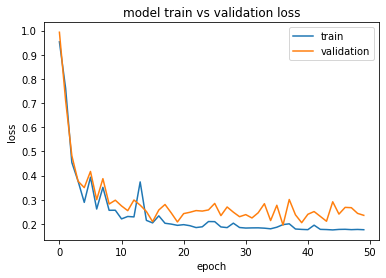

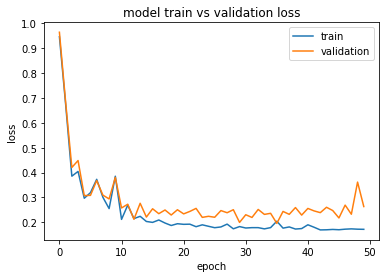

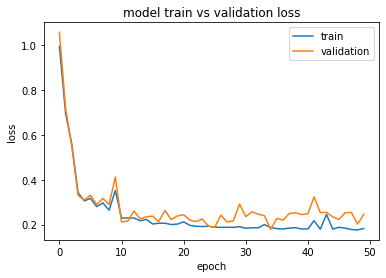

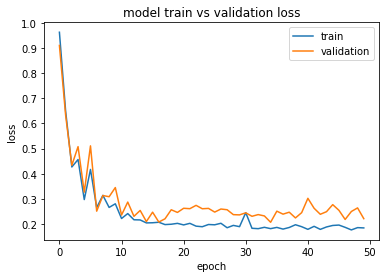

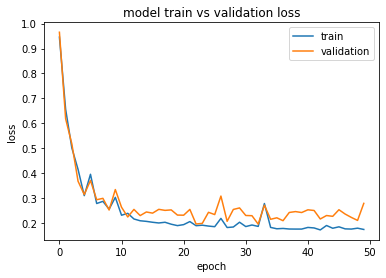

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

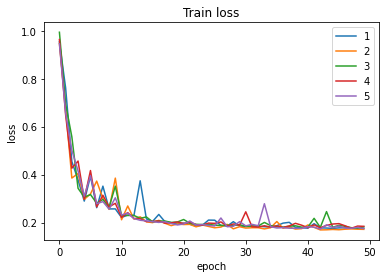

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

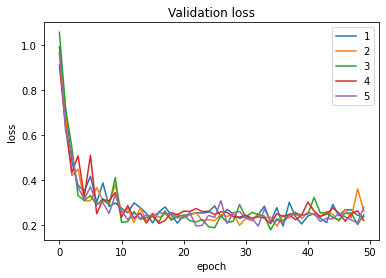

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

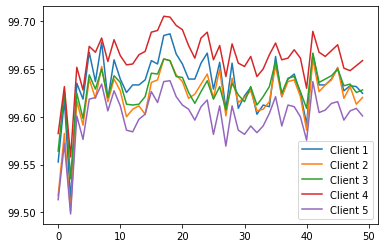

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

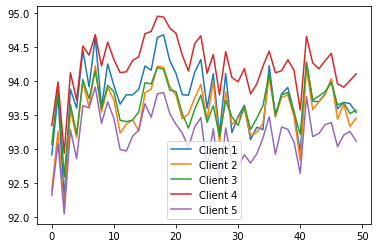

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()